In [31]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import os
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.layers as kl
import numpy as np
import cv2

> **Loading Audience Dataset**

Statistics and info
- Total number of photos: 26,580
- Total number of subjects: 2,284
- Number of age groups / labels: 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)
- Gender labels: Yes
- In the wild: Yes
- Subject labels: Yes

In [16]:
!pip3 install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.1/430.1 kB 706.7 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.8 MB/s eta 0:00:0000:0100:01
  Created wheel for deeplake: filename=deeplake-3.2.5-py3-none-any.whl size=525174 sha256=98d4ca15253f21b00d7192c4c60c8e2900e5be12f43470b59be4a1ce444a1c8a
  Stored in directory: /root/.cache/pip/wheels/0b/12/ad/ceee15f32542791ac85cad14dee03a75aa60ee2c95399eabac
Successfully built deeplake


In [19]:
import deeplake

Data Fields
- images: tensor containing the image
- ages: tensor containing ages (label) of an corresponding image
- gender: tensor containing gender of each image
- x: part of bounding box of the face in the original Flickr image
- y: part of bounding box of the face in the original Flickr image
- dx: part of bounding box of the face in the original Flickr image
- dy: part of bounding box of the face in the original Flickr image
- tilt_ang: pose of the face in the original Flickr image
- fiducial_yaw_angle: pose of the face in the original Flickr image
- fiducial_score: score of the landmark detector

In [20]:
audience_dataset_path = 'hub://activeloop/adience'
ds = deeplake.load(audience_dataset_path) # Returns a Deep Lake Dataset but does not download data locally

hub://activeloop/adience loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience


In [21]:
ds.summary()

Dataset(path='hub://activeloop/adience', read_only=True, tensors=['ages', 'dx', 'dy', 'fiducial_score', 'fiducial_yaw_angle', 'genders', 'images', 'tilt_ang', 'x', 'y'])

       tensor           htype               shape              dtype  compression
      -------          -------             -------            -------  ------- 
        ages         class_label          (19370, 1)          uint32    None   
         dx             text              (19370, 1)            str     None   
         dy             text              (19370, 1)            str     None   
   fiducial_score       text              (19370, 1)            str     None   
 fiducial_yaw_angle     text              (19370, 1)            str     None   
      genders        class_label          (19370, 1)          uint32    None   
       images           image     (19370, 80:932, 80:800, 3)   uint8    jpeg   
      tilt_ang          text              (19370, 1)            str     None   
         x              tex

In [ ]:
ds.visualize()

In [22]:
print(ds.tensors.keys()) # dict_keys(['images', 'labels'])
print(ds.tensors['ages'].numpy().size) 

dict_keys(['ages', 'dx', 'dy', 'fiducial_score', 'fiducial_yaw_angle', 'genders', 'images', 'tilt_ang', 'x', 'y'])
19370


(19370, None, None, 3)


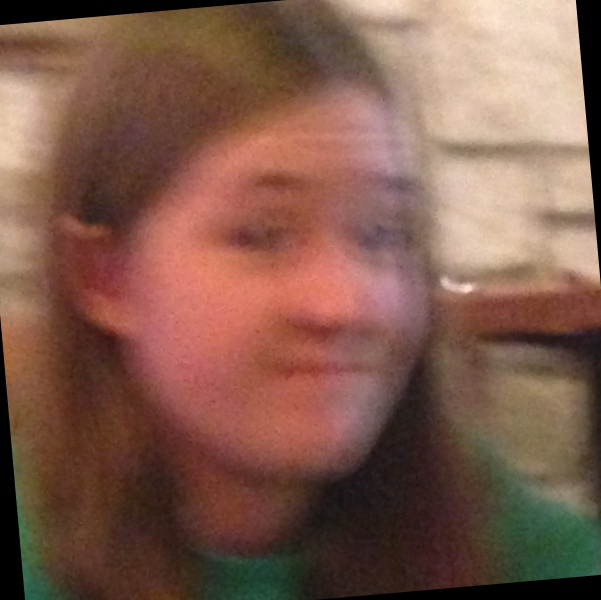

In [23]:
from PIL import Image
print(ds.tensors['images'].shape)
Image.fromarray(ds.images[0].numpy()) # Get the first image in the dataset

In [24]:
print("Genders: ", ds.genders.info)
print("Ages: ", ds.ages.info) # Should have 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-) but it has 30 classes because of the missing ages between each 2 classes

Genders:  {'class_names': ['m', 'f', 'u', 'None']}
Ages:  {'class_names': ['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)', '(48, 53)', '(8, 12)', '(0, 2)', 'None', '(38, 48)', '35', '3', '55', '58', '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)', '57', '56', '2', '29', '34', '42', '46', '32']}


In [42]:
# TESTING Tensorflow methods CELL

spare_ds = ds
print(spare_ds.tensors['ages'][0])
# spare_ds.tensors['ages'][0].numpy() = np.array([1])
# ABC = np.array([1])
ABC = spare_ds.tensors['ages'][0]
print(ABC.numpy())
ABC = tf.constant([1])
# spare_ds.tensors['ages'][0] = ABC
# print(type(spare_ds.tensors['ages'][0]))
print(ABC.numpy())

Tensor(key='ages', index=Index([0]))
[6]
[1]


> **Loading UTK Dataset**

Statistics and info
- consists of 20k+ face images in the wild (only single face in one image)
- provides the correspondingly aligned and cropped faces
- provides the corresponding landmarks (68 points)
- images are labelled by age, gender, and ethnicity

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [41]:
!conda install -y gdown

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [44]:
!gdown --id 1jyypWRZRWwHHHPLCpv4onrIWpVXyQWag # Part1
!gdown --id 1a2tAwDqVmbBAc0yqruaY4L32WLavETu9 # Part2
!gdown --id 1gfXlJKs_859fOJqWZAULQHBXsdoLKE1m # Part3

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1jyypWRZRWwHHHPLCpv4onrIWpVXyQWag
To: /kaggle/working/part1.tar.gz
100%|████████████████████████████████████████| 874M/874M [00:14<00:00, 60.8MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1a2tAwDqVmbBAc0yqruaY4L32WLavETu9
To: /kaggle/working/part2.tar.gz
100%|████████████████████████████████████████| 459M/459M [00:07<00:00, 62.1MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You do

In [45]:
!tar xvzf ./part1.tar.gz
!tar xvzf ./part2.tar.gz
!tar xvzf ./part3.tar.gz

part1/2_1_2_20161219202547820.jpg
part1/77_1_0_20170110122639530.jpg
part1/1_1_0_20170109190844250.jpg
part1/29_1_2_20170105164315483.jpg
part1/76_1_0_20170110131744527.jpg
part1/50_1_0_20170110154254311.jpg
part1/2_1_2_20161219152918020.jpg
part1/5_1_0_20170109194229104.jpg
part1/81_1_2_20170105174804349.jpg
part1/30_0_0_20170105164847516.jpg
part1/37_1_0_20170104171729234.jpg
part1/17_0_0_20170104003852806.jpg
part1/46_0_3_20170104210508188.jpg
part1/32_1_3_20170104223515310.jpg
part1/5_1_2_20161219151834275.jpg
part1/32_0_4_20170105163336092.jpg
part1/1_1_4_20170103210113314.jpg
part1/8_1_0_20170109203557851.jpg
part1/38_0_2_20170104194407752.jpg
part1/1_0_2_20161219155850477.jpg
part1/15_0_0_20170110232515682.jpg
part1/8_0_0_20170110222913531.jpg
part1/30_1_0_20170104165921257.jpg
part1/15_1_2_20170104013425867.jpg
part1/5_1_2_20161219200433267.jpg
part1/1_0_2_20161219212229166.jpg
part1/24_1_3_20170104231625010.jpg
part1/1_0_2_20161219154038141.jpg
part1/9_0_0_20170110224819698.jp

In [46]:
dataset_path1 = './part1' 
dataset_path2 = './part2' 
dataset_path3 = './part3' 

In [49]:
IMAGE_SIZE = 224
from scipy import fft
def create_dataset(path):
  dataset = []
  dic={}
  i = 0
  for img in tqdm(os.listdir(path)):
    path = os.path.join(dataset_path3, img)
    img_data = cv2.imread(path) # BGR IMAGE
    print(i)
    print(img_data)
    i=i+1
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_data = cv2.resize(img_data, (IMAGE_SIZE, IMAGE_SIZE)) #new
    img_data=fft.dct(np.array(img_data))
    print(img_data.shape)
    
    key = 'unknwon'
    label = np.array([0, 0, 0, 0, 0, 0])

    if key not in dic.keys():
      dic[key]=[]
    dic[key].append([np.array(img_data),label ])
  return dic

In [50]:
data=create_dataset(dataset_path3) # Does NOT Complete the whole process

  1%|          | 27/3253 [00:00<00:24, 132.75it/s]

0
[[[172 179 174]
  [178 185 180]
  [174 181 178]
  ...
  [160 172 176]
  [160 172 176]
  [161 173 177]]

 [[189 196 191]
  [194 201 196]
  [188 195 192]
  ...
  [162 174 178]
  [162 174 178]
  [162 174 178]]

 [[206 213 210]
  [209 216 213]
  [200 207 204]
  ...
  [165 177 181]
  [164 176 180]
  [163 175 179]]

 ...

 [[ 29  39  69]
  [ 31  39  68]
  [ 31  38  65]
  ...
  [ 13   8   7]
  [ 14   9   8]
  [ 14   9   8]]

 [[ 28  38  68]
  [ 31  39  68]
  [ 31  38  65]
  ...
  [ 14   9   8]
  [ 15  10   9]
  [ 15  10   9]]

 [[ 28  38  68]
  [ 32  40  69]
  [ 32  39  66]
  ...
  [ 14   9   8]
  [ 14   9   8]
  [ 14   9   8]]]
(224, 224, 3)
1
[[[251 244 247]
  [251 244 247]
  [251 244 247]
  ...
  [246 243 245]
  [246 243 245]
  [246 243 245]]

 [[251 244 247]
  [251 244 247]
  [251 244 247]
  ...
  [246 243 245]
  [246 243 245]
  [246 243 245]]

 [[251 244 247]
  [251 244 247]
  [251 244 247]
  ...
  [246 243 245]
  [246 243 245]
  [246 243 245]]

 ...

 [[ 22  22  40]
  [ 23  23  41]
  

  1%|▏         | 42/3253 [00:00<00:23, 137.94it/s]

(224, 224, 3)
28
[[[227 231 226]
  [227 231 226]
  [227 231 226]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]

 [[227 231 226]
  [227 231 226]
  [227 231 226]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]

 [[227 231 226]
  [227 231 226]
  [227 231 226]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]

 ...

 [[212 218 213]
  [212 218 213]
  [212 218 213]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]

 [[212 218 213]
  [212 218 213]
  [212 218 213]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]

 [[212 218 213]
  [212 218 213]
  [212 218 213]
  ...
  [244 245 241]
  [244 245 241]
  [244 245 241]]]
(224, 224, 3)
29
[[[ 9 15 10]
  [ 9 15 10]
  [ 9 15 10]
  ...
  [ 3 25 20]
  [ 2 24 19]
  [ 1 23 18]]

 [[ 9 15 10]
  [ 9 15 10]
  [ 9 15 10]
  ...
  [ 3 25 20]
  [ 2 24 19]
  [ 1 23 18]]

 [[ 9 15 10]
  [ 9 15 10]
  [ 9 15 10]
  ...
  [ 3 25 20]
  [ 2 24 19]
  [ 1 23 18]]

 ...

 [[12 22 16]
  [12 22 16]
  [12 22 16]
  ...
  [ 5 21 14]
  [ 4 20 13]
 

  2%|▏         | 70/3253 [00:00<00:24, 130.24it/s]

(224, 224, 3)
56
[[[  0  19  21]
  [  0  19  21]
  [  0  19  21]
  ...
  [ 45  58  72]
  [ 45  58  72]
  [ 45  58  72]]

 [[  8  31  33]
  [  8  31  33]
  [  8  31  33]
  ...
  [ 45  58  72]
  [ 45  58  72]
  [ 45  58  72]]

 [[ 18  41  43]
  [ 18  41  43]
  [ 19  42  44]
  ...
  [ 45  58  72]
  [ 45  58  72]
  [ 45  58  72]]

 ...

 [[146 169 171]
  [147 170 172]
  [150 173 175]
  ...
  [ 82 110 110]
  [101 127 127]
  [119 147 147]]

 [[147 170 172]
  [148 171 173]
  [150 173 175]
  ...
  [ 82 108 108]
  [ 98 124 124]
  [118 144 144]]

 [[149 172 174]
  [149 172 174]
  [149 172 174]
  ...
  [ 79 105 105]
  [ 96 122 122]
  [116 142 142]]]
(224, 224, 3)
57
[[[234 207 170]
  [231 205 165]
  [237 207 166]
  ...
  [237 204 159]
  [237 204 159]
  [237 204 159]]

 [[234 207 170]
  [231 205 165]
  [237 207 166]
  ...
  [238 205 160]
  [237 204 159]
  [237 204 159]]

 [[234 207 170]
  [231 205 165]
  [237 207 166]
  ...
  [238 205 160]
  [238 205 160]
  [238 205 160]]

 ...

 [[233 212 180]
  

  3%|▎         | 97/3253 [00:00<00:25, 124.58it/s]

81
[[[ 72  70  69]
  [ 72  70  69]
  [ 72  70  69]
  ...
  [101  99  98]
  [102 100  99]
  [102 100  99]]

 [[ 72  70  69]
  [ 72  70  69]
  [ 72  70  69]
  ...
  [101  99  98]
  [102 100  99]
  [102 100  99]]

 [[ 72  70  69]
  [ 72  70  69]
  [ 72  70  69]
  ...
  [101  99  98]
  [102 100  99]
  [102 100  99]]

 ...

 [[ 69  67  66]
  [ 69  67  66]
  [ 69  67  66]
  ...
  [102  96  97]
  [105  99 100]
  [105  99 100]]

 [[ 69  67  66]
  [ 69  67  66]
  [ 69  67  66]
  ...
  [ 98  92  93]
  [102  96  97]
  [102  96  97]]

 [[ 69  67  66]
  [ 69  67  66]
  [ 69  67  66]
  ...
  [ 95  89  90]
  [ 96  90  91]
  [ 96  90  91]]]
(224, 224, 3)
82
[[[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [225 227 228]
  [225 227 228]
  [225 227 228]]

 [[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [225 227 228]
  [225 227 228]
  [225 227 228]]

 [[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [225 227 228]
  [225 227 228]
  [225 227 228]]

 ...

 [[196 128  93]
  [193 128  90]


  4%|▍         | 125/3253 [00:01<00:27, 113.70it/s]

97
[[[111 131 132]
  [111 131 132]
  [111 131 132]
  ...
  [113 139 139]
  [113 139 139]
  [113 139 139]]

 [[111 131 132]
  [111 131 132]
  [111 131 132]
  ...
  [113 139 139]
  [113 139 139]
  [113 139 139]]

 [[112 132 133]
  [112 132 133]
  [112 132 133]
  ...
  [113 139 139]
  [113 139 139]
  [113 139 139]]

 ...

 [[ 91 107 114]
  [ 92 108 115]
  [ 93 109 116]
  ...
  [111 130 138]
  [111 129 140]
  [111 130 138]]

 [[ 91 107 114]
  [ 92 108 115]
  [ 93 109 116]
  ...
  [112 131 139]
  [112 131 139]
  [112 131 139]]

 [[ 91 107 114]
  [ 92 108 115]
  [ 93 109 116]
  ...
  [112 131 138]
  [112 131 138]
  [112 131 138]]]
(224, 224, 3)
98
[[[167 184 181]
  [167 184 181]
  [167 184 181]
  ...
  [196 211 213]
  [196 211 213]
  [196 211 213]]

 [[167 184 181]
  [167 184 181]
  [168 185 182]
  ...
  [196 211 213]
  [196 211 213]
  [196 211 213]]

 [[168 185 182]
  [168 185 182]
  [168 185 182]
  ...
  [196 211 213]
  [196 211 213]
  [196 211 213]]

 ...

 [[174 158 146]
  [163 149 137]


  5%|▍         | 153/3253 [00:01<00:24, 124.50it/s]

(224, 224, 3)
126
[[[233 255 255]
  [232 255 255]
  [230 253 255]
  ...
  [239 244 253]
  [234 235 245]
  [245 247 255]]

 [[232 255 255]
  [231 254 255]
  [229 252 254]
  ...
  [212 216 227]
  [224 226 236]
  [244 246 254]]

 [[229 252 254]
  [228 251 253]
  [226 249 251]
  ...
  [180 184 195]
  [208 210 220]
  [238 240 250]]

 ...

 [[254 255 251]
  [254 255 251]
  [254 255 253]
  ...
  [148 129 124]
  [203 191 185]
  [255 247 240]]

 [[254 255 251]
  [254 255 251]
  [254 255 253]
  ...
  [210 191 186]
  [231 222 218]
  [255 255 251]]

 [[254 255 251]
  [254 255 251]
  [255 255 254]
  ...
  [255 240 234]
  [245 239 234]
  [254 253 249]]]
(224, 224, 3)
127
[[[152 165 149]
  [152 165 149]
  [152 165 149]
  ...
  [171 182 166]
  [171 182 166]
  [171 182 166]]

 [[152 165 149]
  [152 165 149]
  [152 165 149]
  ...
  [171 182 166]
  [171 182 166]
  [171 182 166]]

 [[152 165 149]
  [152 165 149]
  [152 165 149]
  ...
  [171 182 166]
  [171 182 166]
  [171 182 166]]

 ...

 [[ 48  35  37]


  5%|▌         | 166/3253 [00:01<00:25, 121.42it/s]

153
[[[ 33  38  29]
  [ 33  38  29]
  [ 34  39  30]
  ...
  [ 77 124 145]
  [ 73 120 141]
  [ 73 120 141]]

 [[ 33  38  29]
  [ 33  38  29]
  [ 34  39  30]
  ...
  [ 74 121 142]
  [ 72 119 140]
  [ 70 120 140]]

 [[ 33  38  29]
  [ 33  38  29]
  [ 31  39  29]
  ...
  [ 69 119 139]
  [ 68 118 138]
  [ 67 118 138]]

 ...

 [[102 120 137]
  [103 121 138]
  [104 122 139]
  ...
  [ 70  86  99]
  [ 70  86  99]
  [ 70  86  99]]

 [[102 120 137]
  [102 120 137]
  [103 121 138]
  ...
  [ 70  86  99]
  [ 69  85  98]
  [ 69  85  98]]

 [[101 119 136]
  [102 120 137]
  [102 120 137]
  ...
  [ 70  86  99]
  [ 69  85  98]
  [ 69  85  98]]]
(224, 224, 3)
154
[[[225 244 241]
  [223 242 239]
  [221 240 237]
  ...
  [152 146 157]
  [191 185 196]
  [234 228 239]]

 [[225 244 241]
  [223 242 239]
  [221 240 237]
  ...
  [132 126 137]
  [170 164 175]
  [216 210 221]]

 [[225 244 241]
  [223 242 239]
  [221 240 237]
  ...
  [104  98 109]
  [149 143 154]
  [202 196 207]]

 ...

 [[224 236 242]
  [227 239 245

  6%|▌         | 193/3253 [00:01<00:24, 124.56it/s]

(224, 224, 3)
180
[[[112 130 137]
  [112 130 137]
  [112 130 137]
  ...
  [115 137 143]
  [115 137 143]
  [115 137 143]]

 [[112 130 137]
  [112 130 137]
  [112 130 137]
  ...
  [115 137 143]
  [115 137 143]
  [115 137 143]]

 [[112 130 137]
  [112 130 137]
  [112 130 137]
  ...
  [115 137 143]
  [115 137 143]
  [115 137 143]]

 ...

 [[ 90 108 115]
  [ 90 108 115]
  [ 91 109 116]
  ...
  [109 130 138]
  [109 130 138]
  [109 130 138]]

 [[ 89 107 114]
  [ 90 108 115]
  [ 90 108 115]
  ...
  [109 130 138]
  [109 130 138]
  [109 130 138]]

 [[ 89 107 114]
  [ 89 107 114]
  [ 90 108 115]
  ...
  [109 130 138]
  [109 130 138]
  [109 130 138]]]
(224, 224, 3)
181
[[[ 17  34  25]
  [ 17  34  25]
  [ 17  34  25]
  ...
  [ 25  39  37]
  [ 62  75  73]
  [107 120 118]]

 [[ 18  35  26]
  [ 18  35  26]
  [ 18  35  26]
  ...
  [ 25  39  37]
  [ 62  75  73]
  [106 119 117]]

 [[ 19  35  28]
  [ 19  35  28]
  [ 19  35  28]
  ...
  [ 25  39  37]
  [ 62  75  73]
  [106 119 117]]

 ...

 [[138 138 138]


  7%|▋         | 219/3253 [00:01<00:24, 125.57it/s]

205
[[[ 98 113 132]
  [ 98 113 132]
  [ 98 113 132]
  ...
  [179 200 228]
  [179 200 228]
  [179 200 228]]

 [[ 98 113 132]
  [ 98 113 132]
  [ 98 113 132]
  ...
  [179 200 228]
  [179 200 228]
  [179 200 228]]

 [[ 98 113 132]
  [ 98 113 132]
  [ 98 113 132]
  ...
  [179 200 228]
  [179 200 228]
  [179 200 228]]

 ...

 [[ 56  90 103]
  [115 149 162]
  [159 194 207]
  ...
  [ 24  36  64]
  [ 24  36  64]
  [ 24  36  64]]

 [[ 63  97 110]
  [120 155 168]
  [163 198 211]
  ...
  [ 24  36  64]
  [ 24  36  64]
  [ 24  36  64]]

 [[ 69 104 117]
  [122 157 170]
  [168 203 216]
  ...
  [ 22  36  64]
  [ 22  36  64]
  [ 22  36  64]]]
(224, 224, 3)
206
[[[ 80  76  58]
  [ 88  84  65]
  [ 91  87  68]
  ...
  [223 223 209]
  [220 220 208]
  [239 239 227]]

 [[147 143 124]
  [154 151 130]
  [163 160 139]
  ...
  [232 232 216]
  [233 233 217]
  [247 247 231]]

 [[197 193 169]
  [199 195 170]
  [207 203 178]
  ...
  [241 238 217]
  [241 240 219]
  [248 247 226]]

 ...

 [[252 252 240]
  [255 255 244

  8%|▊         | 247/3253 [00:01<00:23, 130.53it/s]

232
[[[ 93 110 161]
  [ 93 110 161]
  [ 91 108 159]
  ...
  [ 86 105 162]
  [ 87 106 163]
  [ 87 106 163]]

 [[ 91 108 159]
  [ 90 107 158]
  [ 89 106 157]
  ...
  [ 86 105 162]
  [ 87 106 163]
  [ 87 106 163]]

 [[ 88 105 156]
  [ 87 104 155]
  [ 86 103 154]
  ...
  [ 86 105 162]
  [ 87 106 163]
  [ 87 106 163]]

 ...

 [[215 212 208]
  [208 205 201]
  [205 202 198]
  ...
  [217 209 202]
  [220 212 205]
  [222 214 207]]

 [[211 208 204]
  [207 204 200]
  [205 202 198]
  ...
  [215 207 200]
  [219 211 204]
  [221 213 206]]

 [[211 208 204]
  [206 203 199]
  [205 202 198]
  ...
  [215 207 200]
  [219 211 204]
  [221 213 206]]]
(224, 224, 3)
233
[[[206 222 221]
  [204 220 219]
  [203 217 216]
  ...
  [112 140 147]
  [112 140 147]
  [112 140 147]]

 [[205 221 220]
  [204 220 219]
  [202 216 215]
  ...
  [112 140 147]
  [112 140 147]
  [112 140 147]]

 [[205 221 220]
  [203 219 218]
  [202 216 215]
  ...
  [112 140 147]
  [112 140 147]
  [112 140 147]]

 ...

 [[100  98  98]
  [ 77  78  76

  8%|▊         | 274/3253 [00:02<00:23, 126.39it/s]

(224, 224, 3)
258
[[[199 157 144]
  [200 158 145]
  [201 159 146]
  ...
  [240 228 222]
  [239 227 221]
  [239 227 221]]

 [[189 147 134]
  [189 147 134]
  [190 148 135]
  ...
  [237 225 219]
  [237 225 219]
  [237 225 219]]

 [[181 139 126]
  [181 139 126]
  [182 140 127]
  ...
  [234 222 216]
  [233 221 215]
  [233 221 215]]

 ...

 [[171 129 116]
  [171 129 116]
  [172 130 117]
  ...
  [ 68  43  41]
  [ 74  44  43]
  [ 77  46  43]]

 [[171 129 116]
  [172 130 117]
  [173 131 118]
  ...
  [ 68  43  41]
  [ 75  45  44]
  [ 78  47  44]]

 [[171 129 116]
  [172 130 117]
  [173 131 118]
  ...
  [ 68  43  41]
  [ 74  44  43]
  [ 78  47  44]]]
(224, 224, 3)
259
[[[178 186 186]
  [176 184 184]
  [174 182 182]
  ...
  [177 179 180]
  [177 179 180]
  [177 179 180]]

 [[176 184 184]
  [174 182 182]
  [171 179 179]
  ...
  [177 179 180]
  [177 179 180]
  [177 179 180]]

 [[174 182 182]
  [171 179 179]
  [169 177 177]
  ...
  [177 179 180]
  [177 179 180]
  [177 179 180]]

 ...

 [[151 156 155]


  9%|▉         | 301/3253 [00:02<00:22, 129.97it/s]

283
[[[ 10   4  23]
  [ 10   4  23]
  [ 10   4  23]
  ...
  [  9   3  22]
  [  9   3  22]
  [  9   3  22]]

 [[ 10   4  23]
  [ 10   4  23]
  [ 10   4  23]
  ...
  [  9   3  22]
  [  9   3  22]
  [  9   3  22]]

 [[ 10   4  23]
  [ 10   4  23]
  [ 10   4  23]
  ...
  [  9   3  22]
  [  9   3  22]
  [  9   3  22]]

 ...

 [[143 154 162]
  [140 151 159]
  [135 146 154]
  ...
  [187 202 205]
  [186 201 204]
  [186 201 204]]

 [[145 156 164]
  [140 151 159]
  [135 146 154]
  ...
  [187 202 205]
  [187 202 205]
  [187 202 205]]

 [[146 157 165]
  [141 152 160]
  [135 146 154]
  ...
  [187 202 205]
  [187 202 205]
  [187 202 205]]]
(224, 224, 3)
284
[[[202 178 142]
  [202 178 142]
  [202 177 143]
  ...
  [192 254 254]
  [192 254 254]
  [192 254 254]]

 [[202 178 142]
  [202 178 142]
  [202 177 143]
  ...
  [192 254 254]
  [192 254 254]
  [192 254 254]]

 [[202 178 142]
  [202 178 142]
  [202 177 143]
  ...
  [192 254 254]
  [192 254 254]
  [192 254 254]]

 ...

 [[189 218 227]
  [189 218 227

 10%|█         | 331/3253 [00:02<00:22, 131.73it/s]

312
[[[107 118 122]
  [107 118 122]
  [107 118 122]
  ...
  [ 92 129 149]
  [ 91 128 148]
  [ 90 127 147]]

 [[107 118 122]
  [107 118 122]
  [108 119 123]
  ...
  [ 92 129 149]
  [ 91 128 148]
  [ 91 128 148]]

 [[108 119 123]
  [108 119 123]
  [108 119 123]
  ...
  [ 92 129 149]
  [ 91 128 148]
  [ 91 128 148]]

 ...

 [[ 61  63  63]
  [ 61  63  63]
  [ 61  63  63]
  ...
  [ 73  90 109]
  [ 73  90 109]
  [ 73  90 109]]

 [[ 60  62  62]
  [ 60  62  62]
  [ 59  61  61]
  ...
  [ 73  90 109]
  [ 73  90 109]
  [ 73  90 109]]

 [[ 60  62  62]
  [ 60  62  62]
  [ 59  61  61]
  ...
  [ 73  90 109]
  [ 73  90 109]
  [ 73  90 109]]]
(224, 224, 3)
313
[[[251 251 251]
  [251 251 251]
  [253 251 251]
  ...
  [254 251 253]
  [254 251 253]
  [254 251 253]]

 [[253 255 255]
  [253 255 255]
  [255 255 255]
  ...
  [254 253 255]
  [254 253 255]
  [254 253 255]]

 [[245 249 250]
  [246 250 251]
  [248 250 251]
  ...
  [248 249 253]
  [248 249 253]
  [248 249 253]]

 ...

 [[ 47  73 103]
  [ 76 104 138

 11%|█         | 359/3253 [00:02<00:22, 129.42it/s]

(224, 224, 3)
338
[[[  0   1   2]
  [  5   7   8]
  [ 13  15  16]
  ...
  [155 167 169]
  [174 186 188]
  [187 199 201]]

 [[  0   1   2]
  [  5   7   8]
  [ 13  15  16]
  ...
  [155 167 169]
  [175 187 189]
  [187 199 201]]

 [[  0   1   2]
  [  4   6   7]
  [ 13  15  16]
  ...
  [155 167 169]
  [175 187 189]
  [189 201 203]]

 ...

 [[  5   1   6]
  [  4   0   5]
  [  4   0   5]
  ...
  [ 63  82 120]
  [ 73  93 134]
  [ 81 104 142]]

 [[  2   1   3]
  [  2   1   3]
  [  2   1   3]
  ...
  [ 74  87 119]
  [ 75  90 122]
  [ 76  94 125]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [ 75  87 115]
  [ 78  90 118]
  [ 79  93 121]]]
(224, 224, 3)
339
[[[ 19   1  14]
  [ 19   1  14]
  [ 19   1  14]
  ...
  [ 17   0   9]
  [ 16   1   9]
  [ 16   1   9]]

 [[ 19   1  14]
  [ 19   1  14]
  [ 19   1  14]
  ...
  [ 17   0   9]
  [ 16   1   9]
  [ 16   1   9]]

 [[ 19   1  14]
  [ 19   1  14]
  [ 19   1  14]
  ...
  [ 17   0   9]
  [ 16   1   9]
  [ 16   1   9]]

 ...

 [[ 80 131 141]


 12%|█▏        | 385/3253 [00:03<00:22, 125.75it/s]

(224, 224, 3)
365
[[[134 147 145]
  [132 145 143]
  [128 141 139]
  ...
  [ 26  33  52]
  [ 37  43  66]
  [ 37  43  66]]

 [[131 144 142]
  [130 143 141]
  [127 140 138]
  ...
  [ 26  33  52]
  [ 35  41  64]
  [ 35  41  64]]

 [[123 136 134]
  [124 137 135]
  [123 136 134]
  ...
  [ 25  32  51]
  [ 32  38  61]
  [ 32  38  61]]

 ...

 [[167 151 139]
  [158 142 130]
  [149 133 121]
  ...
  [151 144 141]
  [143 138 137]
  [142 137 136]]

 [[166 150 138]
  [156 140 128]
  [147 131 119]
  ...
  [149 142 139]
  [141 133 133]
  [138 133 132]]

 [[161 148 134]
  [150 137 123]
  [140 127 113]
  ...
  [143 136 133]
  [137 130 127]
  [132 125 122]]]
(224, 224, 3)
366
[[[240 246 255]
  [239 245 255]
  [238 244 255]
  ...
  [ 83  92 233]
  [ 92 102 240]
  [108 118 255]]

 [[232 238 251]
  [231 237 250]
  [231 237 250]
  ...
  [ 67  76 217]
  [ 76  86 224]
  [ 92 102 240]]

 [[222 228 239]
  [222 228 239]
  [223 229 240]
  ...
  [ 54  63 204]
  [ 63  72 213]
  [ 80  89 230]]

 ...

 [[ 77 131 218]


 13%|█▎        | 411/3253 [00:03<00:23, 123.40it/s]

389
[[[ 86 141 162]
  [ 86 141 162]
  [ 85 140 161]
  ...
  [ 19  73  96]
  [ 19  73  96]
  [ 19  73  96]]

 [[ 86 141 162]
  [ 86 141 162]
  [ 85 140 161]
  ...
  [ 19  73  96]
  [ 19  73  96]
  [ 19  73  96]]

 [[ 86 141 162]
  [ 86 141 162]
  [ 85 140 161]
  ...
  [ 19  73  96]
  [ 19  73  96]
  [ 19  73  96]]

 ...

 [[ 57  90  99]
  [ 28  64  72]
  [  3  40  48]
  ...
  [ 47 111 136]
  [ 47 111 136]
  [ 47 111 136]]

 [[ 56  93 101]
  [ 28  67  75]
  [  6  45  53]
  ...
  [ 47 111 136]
  [ 47 111 136]
  [ 47 111 136]]

 [[ 56  93 101]
  [ 30  69  77]
  [  9  48  56]
  ...
  [ 47 111 136]
  [ 47 111 136]
  [ 47 111 136]]]
(224, 224, 3)
390
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [252 254 255]
  [252 254 255]
  [252 254 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [252 254 255]
  [252 254 255]
  [252 254 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 253 255]
  [254 253 255]
  [254 253 255]]

 ...

 [[ 55 109  39]
  [ 56 110  40

 13%|█▎        | 437/3253 [00:03<00:23, 120.93it/s]

(224, 224, 3)
414
[[[  1   1   1]
  [  2   2   2]
  [  3   3   3]
  ...
  [  4   2   2]
  [  3   1   1]
  [  2   0   0]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  2   0   0]
  [  2   0   0]
  [  2   0   0]]

 [[  7   7   7]
  [  6   6   6]
  [  5   5   5]
  ...
  [  5   3   3]
  [  4   2   2]
  [  3   1   1]]

 ...

 [[150 166 183]
  [144 160 177]
  [140 156 173]
  ...
  [114 119 128]
  [114 119 128]
  [114 119 128]]

 [[149 165 182]
  [143 159 176]
  [140 156 173]
  ...
  [113 118 127]
  [113 118 127]
  [113 118 127]]

 [[149 165 182]
  [143 159 176]
  [140 156 173]
  ...
  [113 118 127]
  [113 118 127]
  [113 118 127]]]
(224, 224, 3)
415
[[[136 153 162]
  [135 152 161]
  [133 150 159]
  ...
  [101 110 119]
  [100 109 118]
  [100 109 118]]

 [[135 152 161]
  [134 151 160]
  [133 150 159]
  ...
  [105 114 123]
  [104 113 122]
  [104 113 122]]

 [[134 151 160]
  [133 150 159]
  [132 149 158]
  ...
  [106 115 124]
  [106 115 124]
  [105 114 123]]

 ...

 [[ 38  40  41]


 14%|█▍        | 463/3253 [00:03<00:22, 122.63it/s]

(224, 224, 3)
438
[[[189 187 186]
  [189 187 186]
  [189 187 186]
  ...
  [175 180 179]
  [175 180 179]
  [175 180 179]]

 [[189 187 186]
  [189 187 186]
  [189 187 186]
  ...
  [175 180 179]
  [175 180 179]
  [175 180 179]]

 [[189 187 186]
  [189 187 186]
  [189 187 186]
  ...
  [177 179 179]
  [177 179 179]
  [177 179 179]]

 ...

 [[155 157 157]
  [155 157 157]
  [155 157 157]
  ...
  [146 148 148]
  [146 148 148]
  [146 148 148]]

 [[154 156 156]
  [154 156 156]
  [154 156 156]
  ...
  [145 147 147]
  [145 147 147]
  [145 147 147]]

 [[154 156 156]
  [154 156 156]
  [154 156 156]
  ...
  [145 147 147]
  [145 147 147]
  [145 147 147]]]
(224, 224, 3)
439
[[[  3   0  11]
  [  3   0  11]
  [  3   0  11]
  ...
  [ 33  31  30]
  [ 33  31  30]
  [ 33  31  30]]

 [[  3   0  11]
  [  3   0  11]
  [  3   0  11]
  ...
  [ 33  31  30]
  [ 33  31  30]
  [ 33  31  30]]

 [[  3   0  11]
  [  3   0  11]
  [  3   0  11]
  ...
  [ 33  31  30]
  [ 33  31  30]
  [ 33  31  30]]

 ...

 [[223 240 253]


 15%|█▍        | 478/3253 [00:03<00:21, 127.24it/s]

463
[[[173 166 157]
  [160 153 144]
  [153 146 137]
  ...
  [255 250 239]
  [255 249 238]
  [255 249 238]]

 [[173 166 157]
  [160 153 144]
  [153 146 137]
  ...
  [230 224 213]
  [231 225 214]
  [231 225 214]]

 [[173 166 157]
  [160 153 144]
  [153 146 137]
  ...
  [202 196 185]
  [203 197 186]
  [203 197 186]]

 ...

 [[120 193 201]
  [122 195 203]
  [124 197 205]
  ...
  [147 205 224]
  [142 201 220]
  [140 199 218]]

 [[137 210 218]
  [139 212 220]
  [141 214 222]
  ...
  [149 205 224]
  [142 200 219]
  [139 198 217]]

 [[155 228 236]
  [159 232 240]
  [164 236 244]
  ...
  [149 205 224]
  [143 201 220]
  [141 199 218]]]
(224, 224, 3)
464
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255

 15%|█▌        | 504/3253 [00:04<00:21, 126.48it/s]

490
[[[124 180 169]
  [124 180 169]
  [121 180 166]
  ...
  [216 211 190]
  [216 211 190]
  [216 211 190]]

 [[124 180 169]
  [121 179 168]
  [121 180 166]
  ...
  [216 211 190]
  [216 211 190]
  [216 211 190]]

 [[122 180 169]
  [121 179 168]
  [120 179 165]
  ...
  [214 211 190]
  [214 211 190]
  [214 211 190]]

 ...

 [[118 123 154]
  [124 129 160]
  [114 120 149]
  ...
  [115 147 123]
  [117 149 125]
  [119 151 127]]

 [[110 115 146]
  [116 121 152]
  [105 111 140]
  ...
  [114 146 122]
  [116 148 124]
  [118 150 126]]

 [[106 111 142]
  [111 116 147]
  [100 106 135]
  ...
  [113 145 121]
  [115 147 123]
  [116 148 124]]]
(224, 224, 3)
491
[[[193 187 174]
  [197 191 178]
  [190 184 171]
  ...
  [189 186 178]
  [189 186 178]
  [189 186 178]]

 [[189 183 170]
  [184 178 165]
  [172 166 153]
  ...
  [186 183 175]
  [186 183 175]
  [186 183 175]]

 [[190 184 171]
  [173 167 154]
  [157 151 138]
  ...
  [183 180 172]
  [183 180 172]
  [183 180 172]]

 ...

 [[163 154 150]
  [136 127 123

 16%|█▋        | 530/3253 [00:04<00:22, 121.97it/s]

516
[[[176 190 218]
  [176 190 218]
  [176 190 218]
  ...
  [195 141  78]
  [195 141  78]
  [195 141  78]]

 [[177 191 219]
  [177 191 219]
  [177 191 219]
  ...
  [195 141  78]
  [195 141  78]
  [195 141  78]]

 [[181 195 223]
  [181 195 223]
  [181 195 223]
  ...
  [195 141  78]
  [195 141  78]
  [195 141  78]]

 ...

 [[192 142  82]
  [191 141  81]
  [190 141  79]
  ...
  [ 39  31  24]
  [ 36  28  21]
  [ 34  26  19]]

 [[191 141  81]
  [191 142  80]
  [190 141  79]
  ...
  [ 38  30  23]
  [ 37  29  22]
  [ 35  27  20]]

 [[191 141  81]
  [190 141  79]
  [189 140  78]
  ...
  [ 36  28  21]
  [ 37  29  22]
  [ 38  30  23]]]
(224, 224, 3)
517
[[[139 203 198]
  [134 198 193]
  [125 191 186]
  ...
  [ 30  97  82]
  [ 30  97  82]
  [ 30  97  82]]

 [[137 201 196]
  [132 196 191]
  [123 189 184]
  ...
  [ 30  97  82]
  [ 30  97  82]
  [ 30  97  82]]

 [[136 200 195]
  [131 195 190]
  [122 188 183]
  ...
  [ 31  97  85]
  [ 31  97  85]
  [ 31  97  85]]

 ...

 [[255 253 252]
  [255 253 252

 17%|█▋        | 555/3253 [00:04<00:26, 103.61it/s]

(224, 224, 3)
538
[[[125 169 193]
  [124 168 192]
  [123 167 191]
  ...
  [189 198 202]
  [191 200 204]
  [192 201 205]]

 [[126 170 194]
  [126 170 194]
  [125 169 193]
  ...
  [190 199 203]
  [191 200 204]
  [192 201 205]]

 [[131 173 196]
  [131 173 196]
  [130 172 195]
  ...
  [190 199 203]
  [191 200 204]
  [192 201 205]]

 ...

 [[ 60 105 139]
  [ 57 102 136]
  [ 54  99 132]
  ...
  [188 223 236]
  [188 223 236]
  [188 223 236]]

 [[ 58  99 131]
  [ 54  95 127]
  [ 50  91 123]
  ...
  [188 223 236]
  [188 223 236]
  [188 223 236]]

 [[ 56  96 125]
  [ 52  92 121]
  [ 47  87 116]
  ...
  [188 223 236]
  [188 223 236]
  [188 223 236]]]
(224, 224, 3)
539
[[[13 39 76]
  [17 43 80]
  [23 48 88]
  ...
  [47 52 53]
  [47 51 52]
  [47 51 52]]

 [[13 39 76]
  [17 43 80]
  [23 48 88]
  ...
  [46 51 52]
  [46 50 51]
  [46 50 51]]

 [[15 38 76]
  [19 42 80]
  [22 47 87]
  ...
  [45 50 51]
  [46 50 51]
  [46 50 51]]

 ...

 [[21 21 21]
  [21 21 21]
  [21 21 21]
  ...
  [ 8  8  8]
  [11 11 11]

 17%|█▋        | 566/3253 [00:04<00:26, 101.76it/s]

556
[[[ 30  32  32]
  [ 34  36  36]
  [ 43  45  45]
  ...
  [ 58  64  93]
  [ 54  61  88]
  [ 54  61  88]]

 [[ 30  32  32]
  [ 34  36  36]
  [ 43  45  45]
  ...
  [ 52  58  87]
  [ 49  56  83]
  [ 49  56  83]]

 [[ 30  32  32]
  [ 34  36  36]
  [ 43  45  45]
  ...
  [ 48  54  83]
  [ 47  54  81]
  [ 47  54  81]]

 ...

 [[ 95  93 112]
  [ 99  97 116]
  [105 103 122]
  ...
  [139 133 152]
  [128 122 141]
  [121 115 134]]

 [[ 84  82 101]
  [ 89  87 106]
  [ 94  92 111]
  ...
  [124 118 137]
  [113 107 126]
  [105  99 118]]

 [[ 70  69  85]
  [ 74  73  89]
  [ 79  78  94]
  ...
  [105  98 119]
  [ 91  84 105]
  [ 86  79 100]]]
(224, 224, 3)
557
[[[141 169 200]
  [141 169 200]
  [141 169 200]
  ...
  [ 79 105 145]
  [ 79 105 145]
  [ 80 106 146]]

 [[141 169 200]
  [141 169 200]
  [141 169 200]
  ...
  [ 78 104 144]
  [ 79 105 145]
  [ 79 105 145]]

 [[141 169 200]
  [141 169 200]
  [141 169 200]
  ...
  [ 79 104 144]
  [ 79 104 144]
  [ 79 104 144]]

 ...

 [[ 26  40  98]
  [ 37  51 109

 18%|█▊        | 587/3253 [00:04<00:28, 94.71it/s] 

(224, 224, 3)
575
[[[142 108  95]
  [142 108  95]
  [142 108  95]
  ...
  [192 170 152]
  [188 166 148]
  [188 166 148]]

 [[142 108  95]
  [142 108  95]
  [142 108  95]
  ...
  [193 171 153]
  [189 167 149]
  [189 167 149]]

 [[142 108  95]
  [142 108  95]
  [142 108  95]
  ...
  [194 172 154]
  [191 169 151]
  [191 169 151]]

 ...

 [[224 216 209]
  [224 216 209]
  [225 217 210]
  ...
  [239 220 213]
  [239 220 213]
  [239 220 213]]

 [[224 216 209]
  [224 216 209]
  [225 217 210]
  ...
  [239 220 213]
  [239 220 213]
  [239 220 213]]

 [[224 216 209]
  [224 216 209]
  [225 217 210]
  ...
  [239 220 215]
  [238 219 214]
  [238 219 214]]]
(224, 224, 3)
576
[[[205 203 202]
  [205 203 202]
  [205 203 202]
  ...
  [203 203 203]
  [203 203 203]
  [203 203 203]]

 [[205 203 202]
  [205 203 202]
  [205 203 202]
  ...
  [203 203 203]
  [203 203 203]
  [203 203 203]]

 [[205 203 202]
  [205 203 202]
  [205 203 202]
  ...
  [203 203 203]
  [203 203 203]
  [203 203 203]]

 ...

 [[144 142 132]


 19%|█▊        | 607/3253 [00:05<00:28, 92.11it/s]

(224, 224, 3)
593
[[[105 104  94]
  [102 101  91]
  [ 99  98  88]
  ...
  [237 225 215]
  [237 225 215]
  [237 225 215]]

 [[105 104  94]
  [102 101  91]
  [ 99  98  88]
  ...
  [237 225 215]
  [237 225 215]
  [237 225 215]]

 [[105 104  94]
  [102 101  91]
  [ 99  98  88]
  ...
  [237 225 215]
  [237 225 215]
  [237 225 215]]

 ...

 [[ 71  58  42]
  [ 69  56  40]
  [ 67  57  40]
  ...
  [ 99  90 103]
  [ 99  92 105]
  [104  97 110]]

 [[ 72  59  43]
  [ 69  56  40]
  [ 67  57  40]
  ...
  [ 93  84  97]
  [ 96  89 102]
  [103  96 109]]

 [[ 74  61  45]
  [ 70  57  41]
  [ 68  58  41]
  ...
  [ 91  82  95]
  [ 95  88 101]
  [104  97 110]]]
(224, 224, 3)
594
[[[230 224 255]
  [230 224 255]
  [230 224 255]
  ...
  [195 209 207]
  [168 182 180]
  [150 164 162]]

 [[230 224 255]
  [230 224 255]
  [230 224 255]
  ...
  [186 200 198]
  [188 202 200]
  [178 192 190]]

 [[230 224 255]
  [230 224 255]
  [230 224 255]
  ...
  [188 202 200]
  [202 216 214]
  [204 218 216]]

 ...

 [[115 147 142]


 19%|█▉        | 627/3253 [00:05<00:28, 92.37it/s]

611
[[[254 242 240]
  [230 218 216]
  [212 200 198]
  ...
  [233 219 231]
  [232 218 230]
  [231 217 229]]

 [[254 242 240]
  [229 217 215]
  [212 200 198]
  ...
  [209 195 207]
  [208 194 206]
  [208 194 206]]

 [[254 242 240]
  [229 217 215]
  [212 200 198]
  ...
  [193 179 191]
  [193 179 191]
  [192 178 190]]

 ...

 [[250 253 238]
  [249 252 237]
  [249 251 239]
  ...
  [250 255 253]
  [250 255 253]
  [250 255 253]]

 [[255 255 245]
  [255 255 245]
  [254 255 244]
  ...
  [250 255 253]
  [250 255 253]
  [250 255 253]]

 [[254 255 245]
  [254 255 245]
  [254 255 245]
  ...
  [250 255 251]
  [250 255 251]
  [250 255 251]]]
(224, 224, 3)
612
[[[209 212 227]
  [209 212 227]
  [209 212 227]
  ...
  [218 221 236]
  [218 221 236]
  [218 221 236]]

 [[209 212 227]
  [209 212 227]
  [209 212 227]
  ...
  [218 221 236]
  [218 221 236]
  [218 221 236]]

 [[209 212 227]
  [209 212 227]
  [209 212 227]
  ...
  [218 221 236]
  [218 221 236]
  [218 221 236]]

 ...

 [[ 64  68 126]
  [ 62  69 126

 20%|█▉        | 647/3253 [00:05<00:28, 90.66it/s]

630
[[[223 238 254]
  [223 238 254]
  [223 238 254]
  ...
  [220 235 251]
  [220 235 251]
  [220 235 251]]

 [[223 238 254]
  [223 238 254]
  [223 238 254]
  ...
  [220 235 251]
  [220 235 251]
  [220 235 251]]

 [[223 238 254]
  [223 238 254]
  [223 238 254]
  ...
  [220 235 251]
  [220 235 251]
  [220 235 251]]

 ...

 [[250 252 253]
  [250 252 253]
  [249 251 252]
  ...
  [249 251 251]
  [249 251 251]
  [250 252 252]]

 [[250 252 253]
  [250 252 253]
  [250 252 253]
  ...
  [249 251 251]
  [249 251 251]
  [250 252 252]]

 [[250 252 253]
  [250 252 253]
  [250 252 253]
  ...
  [249 251 251]
  [249 251 251]
  [250 252 252]]]
(224, 224, 3)
631
[[[185 205 206]
  [197 218 219]
  [204 225 227]
  ...
  [ 91 122 175]
  [ 90 121 174]
  [ 89 120 173]]

 [[186 206 207]
  [198 219 220]
  [204 225 227]
  ...
  [ 91 122 175]
  [ 90 121 174]
  [ 88 119 172]]

 [[187 207 208]
  [199 220 221]
  [205 226 228]
  ...
  [ 90 121 174]
  [ 89 120 173]
  [ 86 117 170]]

 ...

 [[170 184 183]
  [205 221 220

 20%|██        | 657/3253 [00:05<00:28, 89.59it/s]

648
[[[193 175  86]
  [193 175  86]
  [193 175  86]
  ...
  [180 162  69]
  [180 162  69]
  [180 162  69]]

 [[193 175  86]
  [193 175  86]
  [193 175  86]
  ...
  [180 162  69]
  [180 162  69]
  [180 162  69]]

 [[193 175  86]
  [193 175  86]
  [193 175  86]
  ...
  [180 162  69]
  [180 162  69]
  [180 162  69]]

 ...

 [[109 115 134]
  [111 117 136]
  [113 119 138]
  ...
  [130 137 152]
  [130 137 152]
  [130 137 152]]

 [[109 115 134]
  [111 117 136]
  [112 118 137]
  ...
  [130 137 152]
  [130 137 152]
  [130 137 152]]

 [[110 116 135]
  [112 118 137]
  [113 119 138]
  ...
  [130 137 152]
  [130 137 152]
  [130 137 152]]]
(224, 224, 3)
649
[[[222 191 152]
  [225 194 155]
  [227 198 161]
  ...
  [ 63  37  21]
  [ 63  37  21]
  [ 63  37  21]]

 [[224 193 154]
  [226 195 156]
  [230 198 162]
  ...
  [ 63  37  21]
  [ 63  37  21]
  [ 63  37  21]]

 [[225 192 153]
  [226 195 156]
  [230 199 160]
  ...
  [ 65  36  21]
  [ 65  36  21]
  [ 65  36  21]]

 ...

 [[ 73 127 144]
  [ 72 126 143

 21%|██        | 676/3253 [00:05<00:28, 89.02it/s]

(224, 224, 3)
667
[[[191 214 206]
  [191 214 206]
  [191 214 206]
  ...
  [221 237 230]
  [221 238 229]
  [221 238 229]]

 [[191 214 206]
  [191 214 206]
  [191 214 206]
  ...
  [221 237 230]
  [221 238 229]
  [221 238 229]]

 [[191 214 206]
  [191 214 206]
  [191 214 206]
  ...
  [221 237 230]
  [221 238 229]
  [221 238 229]]

 ...

 [[239 252 250]
  [239 252 250]
  [239 252 250]
  ...
  [245 238 229]
  [242 236 229]
  [240 236 231]]

 [[239 252 250]
  [239 252 250]
  [239 252 250]
  ...
  [249 243 232]
  [244 238 231]
  [242 238 233]]

 [[239 252 250]
  [239 252 250]
  [239 252 250]
  ...
  [254 248 235]
  [252 244 237]
  [250 244 239]]]
(224, 224, 3)
668
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]


 21%|██▏       | 696/3253 [00:06<00:28, 91.03it/s]

685
[[[168 169 160]
  [168 169 160]
  [167 168 159]
  ...
  [143 149 144]
  [144 150 145]
  [144 150 145]]

 [[168 169 160]
  [168 169 160]
  [167 168 159]
  ...
  [140 146 141]
  [141 147 142]
  [141 147 142]]

 [[168 169 160]
  [168 169 160]
  [168 169 160]
  ...
  [134 141 136]
  [136 143 138]
  [136 143 138]]

 ...

 [[219 227 234]
  [222 230 237]
  [225 233 240]
  ...
  [232 243 247]
  [233 242 246]
  [233 242 246]]

 [[222 228 235]
  [222 231 235]
  [227 233 240]
  ...
  [232 243 247]
  [233 242 246]
  [233 242 246]]

 [[225 229 234]
  [224 231 234]
  [229 233 238]
  ...
  [232 243 247]
  [233 242 246]
  [233 242 246]]]
(224, 224, 3)
686
[[[ 13  15  16]
  [ 13  15  16]
  [ 14  16  17]
  ...
  [137 136 140]
  [137 136 140]
  [137 136 140]]

 [[ 14  16  17]
  [ 14  16  17]
  [ 15  17  18]
  ...
  [137 136 140]
  [137 136 140]
  [137 136 140]]

 [[ 16  18  19]
  [ 16  18  19]
  [ 16  18  19]
  ...
  [137 136 140]
  [137 136 140]
  [137 136 140]]

 ...

 [[  1   0   2]
  [  1   0   2

 22%|██▏       | 716/3253 [00:06<00:29, 85.22it/s]

704
[[[ 29  19  31]
  [ 29  19  31]
  [ 29  19  31]
  ...
  [240 231 221]
  [240 231 221]
  [240 231 221]]

 [[ 29  19  31]
  [ 29  19  31]
  [ 29  19  31]
  ...
  [240 231 221]
  [240 231 221]
  [240 231 221]]

 [[ 29  19  31]
  [ 29  19  31]
  [ 29  19  31]
  ...
  [240 231 221]
  [240 231 221]
  [240 231 221]]

 ...

 [[ 71  74 112]
  [ 82  85 123]
  [ 91  93 133]
  ...
  [ 35  15  90]
  [ 34  15  88]
  [ 34  15  88]]

 [[ 61  64 102]
  [ 70  73 111]
  [ 77  79 119]
  ...
  [ 35  15  90]
  [ 35  16  89]
  [ 35  16  89]]

 [[ 47  48  86]
  [ 57  58  96]
  [ 65  65 105]
  ...
  [ 35  15  90]
  [ 35  16  89]
  [ 35  16  89]]]
(224, 224, 3)
705
[[[ 39  64  36]
  [ 34  59  31]
  [ 28  53  27]
  ...
  [ 52  66  42]
  [ 51  67  43]
  [ 50  66  42]]

 [[ 40  65  37]
  [ 36  61  33]
  [ 32  57  31]
  ...
  [ 54  68  44]
  [ 52  68  44]
  [ 51  67  43]]

 [[ 38  65  39]
  [ 37  64  38]
  [ 36  63  37]
  ...
  [ 55  71  47]
  [ 53  69  46]
  [ 53  69  46]]

 ...

 [[250 247 242]
  [249 246 241

 23%|██▎       | 735/3253 [00:06<00:29, 86.23it/s]

720
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(224, 224, 3)
721
[[[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [242 242 242]
  [242 242 242]
  [242 242 242]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [242 242 242]
  [242 242 242]
  [242 242 242]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [242 242 242]
  [242 242 242]
  [242 242 242]]

 ...

 [[229 226 218]
  [229 226 218

 23%|██▎       | 753/3253 [00:06<00:29, 85.65it/s]

739
[[[251 250 252]
  [251 250 252]
  [251 250 252]
  ...
  [251 250 252]
  [251 250 252]
  [251 250 252]]

 [[251 250 252]
  [251 250 252]
  [251 250 252]
  ...
  [251 250 252]
  [251 250 252]
  [251 250 252]]

 [[251 250 252]
  [251 250 252]
  [251 250 252]
  ...
  [251 250 252]
  [251 250 252]
  [251 250 252]]

 ...

 [[129 123 142]
  [132 126 145]
  [129 123 142]
  ...
  [ 93  87 104]
  [ 88  82  99]
  [ 85  79  96]]

 [[130 124 143]
  [134 128 147]
  [130 124 143]
  ...
  [ 88  82  99]
  [ 82  76  93]
  [ 80  74  91]]

 [[145 139 158]
  [134 128 147]
  [124 118 137]
  ...
  [ 80  74  91]
  [ 76  70  87]
  [ 75  69  86]]]
(224, 224, 3)
740
[[[ 51  43  50]
  [ 63  55  62]
  [ 79  71  78]
  ...
  [ 79  70  91]
  [121 111 128]
  [161 152 165]]

 [[ 45  37  44]
  [ 56  48  55]
  [ 64  56  63]
  ...
  [ 79  70  91]
  [121 111 128]
  [161 152 165]]

 [[ 39  32  37]
  [ 48  41  46]
  [ 48  41  46]
  ...
  [ 79  70  91]
  [121 111 128]
  [161 152 165]]

 ...

 [[ 36  31  33]
  [ 35  30  31

 24%|██▍       | 774/3253 [00:06<00:26, 92.10it/s]

(224, 224, 3)
757
[[[207 203 209]
  [207 203 209]
  [207 203 209]
  ...
  [189 187 193]
  [189 187 193]
  [189 187 193]]

 [[207 203 209]
  [207 203 209]
  [206 202 208]
  ...
  [189 187 193]
  [189 187 193]
  [189 187 193]]

 [[207 203 209]
  [206 202 208]
  [206 202 208]
  ...
  [189 187 193]
  [189 187 193]
  [189 187 193]]

 ...

 [[ 51  55  79]
  [ 51  55  79]
  [ 50  54  78]
  ...
  [156 147 144]
  [147 138 135]
  [147 138 135]]

 [[ 51  56  77]
  [ 51  56  77]
  [ 50  55  76]
  ...
  [150 141 138]
  [147 138 135]
  [147 138 135]]

 [[ 51  56  77]
  [ 51  56  77]
  [ 50  55  76]
  ...
  [144 135 132]
  [147 138 135]
  [147 138 135]]]
(224, 224, 3)
758
[[[167 183 199]
  [168 184 200]
  [172 188 204]
  ...
  [201 215 234]
  [203 217 236]
  [203 217 236]]

 [[167 183 199]
  [168 184 200]
  [173 189 205]
  ...
  [201 215 234]
  [203 217 236]
  [203 217 236]]

 [[167 183 199]
  [169 185 201]
  [173 189 205]
  ...
  [201 215 233]
  [203 217 235]
  [203 217 235]]

 ...

 [[ 27  17  17]


 24%|██▍       | 794/3253 [00:07<00:27, 90.45it/s]

(224, 224, 3)
777
[[[198 193 214]
  [198 193 214]
  [198 193 214]
  ...
  [207 202 223]
  [207 202 223]
  [207 202 223]]

 [[198 193 214]
  [198 193 214]
  [199 194 215]
  ...
  [208 203 224]
  [207 202 223]
  [207 202 223]]

 [[198 193 214]
  [199 194 215]
  [199 194 215]
  ...
  [208 203 224]
  [208 203 224]
  [207 202 223]]

 ...

 [[120 145 217]
  [120 145 217]
  [119 144 216]
  ...
  [ 84  75 191]
  [ 75  61 193]
  [ 73  57 195]]

 [[121 146 218]
  [120 145 217]
  [120 145 217]
  ...
  [ 78  68 188]
  [ 71  56 191]
  [ 75  57 200]]

 [[120 145 217]
  [120 145 217]
  [119 144 216]
  ...
  [ 72  62 182]
  [ 69  54 189]
  [ 81  63 206]]]
(224, 224, 3)
778
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 69  84 103]


 25%|██▍       | 804/3253 [00:07<00:27, 88.55it/s]

(224, 224, 3)
795
[[[246 248 248]
  [246 248 248]
  [247 249 249]
  ...
  [107 112 113]
  [107 112 113]
  [107 112 113]]

 [[249 251 251]
  [249 251 251]
  [250 252 252]
  ...
  [107 112 113]
  [107 112 113]
  [107 112 113]]

 [[253 255 255]
  [253 255 255]
  [253 255 255]
  ...
  [107 112 113]
  [107 112 113]
  [107 112 113]]

 ...

 [[ 17  15  15]
  [ 17  15  15]
  [ 17  15  15]
  ...
  [  8   8   8]
  [  8   8   8]
  [  8   8   8]]

 [[ 17  15  15]
  [ 17  15  15]
  [ 17  15  15]
  ...
  [  8   8   8]
  [  8   8   8]
  [  8   8   8]]

 [[ 17  15  15]
  [ 17  15  15]
  [ 17  15  15]
  ...
  [  8   8   8]
  [  8   8   8]
  [  8   8   8]]]
(224, 224, 3)
796
[[[189 151 119]
  [208 172 142]
  [231 193 169]
  ...
  [  6   1   0]
  [  6   1   0]
  [  7   2   1]]

 [[189 151 119]
  [208 172 142]
  [230 192 168]
  ...
  [  6   1   0]
  [  6   1   0]
  [  7   2   1]]

 [[187 149 117]
  [206 170 140]
  [229 191 167]
  ...
  [  5   1   0]
  [  5   1   0]
  [  6   2   1]]

 ...

 [[ 96  84 114]


 25%|██▌       | 824/3253 [00:07<00:26, 90.71it/s]

813
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[65 74 71]
  [66 75 72]
  [69 78 75]
  ...
  [39 46 43]
  [37 44 41]
  [37 44 41]]

 [[70 79 76]
  [72 81 78]
  [74 83 80]
  ...
  [38 45 42]
  [36 43 40]
  [36 43 40]]

 [[77 86 83]
  [77 86 83]
  [78 87 84]
  ...
  [37 44 41]
  [35 42 39]
  [35 42 39]]]
(224, 224, 3)
814
[[[230 222 229]
  [230 222 229]
  [230 222 229]
  ...
  [247 241 242]
  [247 241 242]
  [247 241 242]]

 [[230 222 229]
  [230 222 229]
  [230 222 229]
  ...
  [247 241 242]
  [247 241 242]
  [247 241 242]]

 [[230 222 229]
  [230 222 229]
  [230 222 229]
  ...
  [247 241 242]
  [247 241 242]
  [247 241 242]]

 ...

 [[222 214 221]
  [222 214 221]
  [222 214 221]
  ...
  [ 84  95 123]
  [107 116 143]
  [128 137 164]]

 [[222 214 221]
  [222 214 221]
  

 26%|██▌       | 843/3253 [00:07<00:26, 89.34it/s]

831
[[[180  41 128]
  [180  41 128]
  [180  41 128]
  ...
  [245 190 181]
  [246 191 182]
  [246 191 182]]

 [[180  41 128]
  [180  41 128]
  [181  42 129]
  ...
  [245 190 181]
  [246 191 182]
  [246 191 182]]

 [[180  41 128]
  [181  42 129]
  [181  42 129]
  ...
  [245 190 181]
  [246 191 182]
  [246 191 182]]

 ...

 [[ 83  56  65]
  [ 88  61  70]
  [ 96  69  78]
  ...
  [ 96 101 140]
  [ 96  98 138]
  [ 94  99 138]]

 [[ 80  53  62]
  [ 83  56  65]
  [ 87  60  69]
  ...
  [ 89  92 130]
  [ 86  89 127]
  [ 86  89 127]]

 [[ 80  53  62]
  [ 80  53  62]
  [ 80  53  62]
  ...
  [ 81  84 122]
  [ 76  79 117]
  [ 76  79 117]]]
(224, 224, 3)
832
[[[176 142 112]
  [176 142 112]
  [176 142 112]
  ...
  [225 180 136]
  [226 181 137]
  [226 181 137]]

 [[128  94  64]
  [128  94  64]
  [128  94  64]
  ...
  [171 126  82]
  [171 126  82]
  [171 126  82]]

 [[ 90  56  26]
  [ 90  56  26]
  [ 90  56  26]
  ...
  [115  70  26]
  [116  71  27]
  [116  71  27]]

 ...

 [[239 222 236]
  [241 224 238

 27%|██▋       | 863/3253 [00:07<00:26, 90.14it/s]

(224, 224, 3)
850
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [246 237 223]
  [255 251 238]
  [255 253 242]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [250 241 227]
  [255 251 238]
  [255 253 242]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 247 232]
  [255 252 238]
  [255 253 242]]

 ...

 [[227 240 218]
  [227 240 218]
  [227 240 218]
  ...
  [255 255 249]
  [253 253 247]
  [253 253 247]]

 [[227 240 218]
  [227 240 218]
  [227 240 218]
  ...
  [255 255 249]
  [254 254 248]
  [254 254 248]]

 [[228 241 219]
  [228 241 219]
  [228 241 219]
  ...
  [255 255 249]
  [254 254 248]
  [254 254 248]]]
(224, 224, 3)
851
[[[100 108 108]
  [100 108 108]
  [100 108 108]
  ...
  [103 114 118]
  [107 118 122]
  [108 119 123]]

 [[100 108 108]
  [100 108 108]
  [101 109 109]
  ...
  [103 114 118]
  [107 118 122]
  [108 119 123]]

 [[100 108 108]
  [101 109 109]
  [101 109 109]
  ...
  [103 114 118]
  [108 119 123]
  [108 119 123]]

 ...

 [[ 98  96  95]


 27%|██▋       | 883/3253 [00:08<00:25, 91.47it/s]

(224, 224, 3)
869
[[[ 14  43  88]
  [ 14  43  88]
  [ 14  43  88]
  ...
  [ 10  16  35]
  [ 12  16  34]
  [ 11  15  33]]

 [[ 14  43  88]
  [ 14  43  88]
  [ 14  43  88]
  ...
  [ 10  16  35]
  [ 12  16  34]
  [ 11  15  33]]

 [[ 15  44  89]
  [ 15  44  89]
  [ 15  44  89]
  ...
  [ 11  17  36]
  [ 12  16  34]
  [ 12  16  34]]

 ...

 [[160 187 183]
  [160 187 183]
  [158 185 181]
  ...
  [165 191 185]
  [168 194 188]
  [169 195 189]]

 [[162 189 185]
  [160 187 183]
  [157 184 180]
  ...
  [167 193 187]
  [169 195 189]
  [169 195 189]]

 [[166 193 189]
  [162 189 185]
  [157 184 180]
  ...
  [170 196 190]
  [170 196 190]
  [171 197 191]]]
(224, 224, 3)
870
[[[171 173 173]
  [171 173 173]
  [170 172 172]
  ...
  [134 140 145]
  [133 139 144]
  [132 138 143]]

 [[171 173 173]
  [170 172 172]
  [170 172 172]
  ...
  [134 140 145]
  [133 139 144]
  [132 138 143]]

 [[170 172 172]
  [170 172 172]
  [169 171 171]
  ...
  [135 141 146]
  [133 139 144]
  [132 138 143]]

 ...

 [[240 238 238]


 28%|██▊       | 903/3253 [00:08<00:25, 90.45it/s]

887
[[[144 182 194]
  [144 182 194]
  [144 182 194]
  ...
  [154 189 202]
  [154 189 202]
  [154 189 202]]

 [[144 182 194]
  [144 182 194]
  [144 182 194]
  ...
  [154 189 202]
  [154 189 202]
  [154 189 202]]

 [[144 182 194]
  [144 182 194]
  [144 182 194]
  ...
  [154 189 202]
  [154 189 202]
  [154 189 202]]

 ...

 [[188 178 178]
  [192 182 182]
  [197 187 187]
  ...
  [199 194 193]
  [195 185 185]
  [193 183 183]]

 [[188 178 178]
  [191 181 181]
  [194 184 184]
  ...
  [204 199 198]
  [200 190 190]
  [198 188 188]]

 [[191 181 181]
  [193 183 183]
  [193 183 183]
  ...
  [208 203 202]
  [206 196 196]
  [204 194 194]]]
(224, 224, 3)
888
[[[ 70  60  76]
  [ 77  67  83]
  [ 78  68  84]
  ...
  [148 217 250]
  [149 218 251]
  [149 218 251]]

 [[ 70  60  76]
  [ 75  65  81]
  [ 73  63  79]
  ...
  [147 216 249]
  [149 218 251]
  [149 218 251]]

 [[ 70  60  76]
  [ 70  60  76]
  [ 67  56  72]
  ...
  [149 216 249]
  [150 217 250]
  [151 218 251]]

 ...

 [[ 85  83 172]
  [ 84  85 173

 28%|██▊       | 913/3253 [00:08<00:26, 87.24it/s]

905
[[[ 0  1  2]
  [ 0  0  1]
  [ 0  2  3]
  ...
  [ 0  1  0]
  [ 3  5  5]
  [ 0  0  0]]

 [[ 0  1  2]
  [ 0  0  1]
  [ 0  2  3]
  ...
  [ 0  1  0]
  [ 3  5  5]
  [ 0  0  0]]

 [[ 0  1  2]
  [ 0  0  1]
  [ 0  2  3]
  ...
  [ 0  1  0]
  [ 3  5  5]
  [ 0  0  0]]

 ...

 [[ 2  1  0]
  [ 2  1  0]
  [ 5  4  0]
  ...
  [ 8  5  1]
  [ 4  1  0]
  [ 8  5  1]]

 [[ 2  1  0]
  [ 2  1  0]
  [ 4  3  0]
  ...
  [ 9  6  2]
  [ 4  1  0]
  [ 9  6  2]]

 [[ 2  1  0]
  [ 2  1  0]
  [ 5  4  0]
  ...
  [10  7  3]
  [ 5  2  0]
  [ 9  6  2]]]
(224, 224, 3)
906
[[[49 51 51]
  [49 51 51]
  [50 52 52]
  ...
  [66 65 74]
  [67 66 75]
  [66 65 74]]

 [[54 56 56]
  [54 56 56]
  [55 57 57]
  ...
  [69 68 77]
  [70 69 78]
  [69 68 77]]

 [[62 64 64]
  [62 64 64]
  [62 64 64]
  ...
  [73 72 81]
  [74 73 82]
  [72 71 80]]

 ...

 [[77 79 80]
  [76 78 78]
  [73 75 76]
  ...
  [41 47 70]
  [41 47 70]
  [41 47 70]]

 [[77 79 79]
  [76 78 78]
  [74 76 76]
  ...
  [36 42 65]
  [37 43 66]
  [37 43 66]]

 [[76 78 78]
  [75 7

 29%|██▊       | 931/3253 [00:08<00:27, 85.54it/s]

922
[[[ 76  84  74]
  [ 75  83  73]
  [ 74  82  72]
  ...
  [ 63  69  64]
  [ 70  76  71]
  [ 71  77  72]]

 [[ 76  84  74]
  [ 75  83  73]
  [ 74  82  72]
  ...
  [ 62  68  63]
  [ 67  73  68]
  [ 68  74  69]]

 [[ 76  84  74]
  [ 75  83  73]
  [ 73  81  71]
  ...
  [ 60  66  61]
  [ 62  68  63]
  [ 62  68  63]]

 ...

 [[128 127 129]
  [124 123 125]
  [116 116 116]
  ...
  [ 90  53  33]
  [ 91  54  32]
  [ 95  58  36]]

 [[110 107 109]
  [107 105 105]
  [103  98  99]
  ...
  [ 91  54  32]
  [ 89  52  30]
  [ 94  57  35]]

 [[ 94  88  89]
  [ 92  86  87]
  [ 91  83  84]
  ...
  [ 93  58  32]
  [ 94  55  33]
  [ 94  55  33]]]
(224, 224, 3)
923
[[[150 162 166]
  [150 162 166]
  [150 162 166]
  ...
  [  8  16  15]
  [  9  15  14]
  [  9  15  14]]

 [[150 162 166]
  [150 162 166]
  [150 162 166]
  ...
  [  8  16  15]
  [  9  15  14]
  [  9  15  14]]

 [[150 162 166]
  [150 162 166]
  [150 162 166]
  ...
  [  8  16  15]
  [  9  15  14]
  [  9  15  14]]

 ...

 [[189 179 191]
  [201 191 203

 29%|██▉       | 949/3253 [00:08<00:27, 84.22it/s]

(224, 224, 3)
939
[[[247 253 255]
  [245 251 255]
  [241 247 252]
  ...
  [229 233 244]
  [237 241 252]
  [247 251 255]]

 [[217 223 228]
  [215 221 226]
  [211 217 222]
  ...
  [201 205 216]
  [210 214 225]
  [221 225 236]]

 [[185 191 196]
  [183 189 194]
  [179 185 190]
  ...
  [173 177 188]
  [182 186 197]
  [194 198 209]]

 ...

 [[253 254 250]
  [251 252 248]
  [249 250 246]
  ...
  [255 255 250]
  [255 255 250]
  [255 255 250]]

 [[255 255 252]
  [255 255 252]
  [253 254 250]
  ...
  [255 255 251]
  [255 255 251]
  [255 255 250]]

 [[254 255 251]
  [254 255 251]
  [254 255 251]
  ...
  [254 255 251]
  [254 255 251]
  [254 255 251]]]
(224, 224, 3)
940
[[[247 253 248]
  [247 253 248]
  [249 253 248]
  ...
  [124 115 128]
  [ 96  87 100]
  [ 66  57  70]]

 [[247 253 248]
  [247 253 248]
  [249 253 248]
  ...
  [124 115 128]
  [ 96  87 100]
  [ 67  58  71]]

 [[247 253 248]
  [247 253 248]
  [249 253 248]
  ...
  [125 116 129]
  [ 97  88 101]
  [ 68  59  72]]

 ...

 [[248 227 229]


 30%|██▉       | 969/3253 [00:09<00:25, 89.67it/s]

956
[[[82 77 76]
  [82 77 76]
  [82 77 76]
  ...
  [59 67 66]
  [58 66 65]
  [57 65 64]]

 [[83 78 77]
  [83 78 77]
  [83 78 77]
  ...
  [59 67 66]
  [58 66 65]
  [57 65 64]]

 [[86 81 80]
  [86 81 80]
  [86 81 80]
  ...
  [59 67 66]
  [58 66 65]
  [57 65 64]]

 ...

 [[12 12 12]
  [13 13 13]
  [15 15 15]
  ...
  [51 41 53]
  [51 41 53]
  [61 51 63]]

 [[15 15 15]
  [16 16 16]
  [17 17 17]
  ...
  [42 32 44]
  [44 34 46]
  [56 46 58]]

 [[15 15 15]
  [17 17 17]
  [20 20 20]
  ...
  [34 24 37]
  [49 39 52]
  [60 50 63]]]
(224, 224, 3)
957
[[[250 255 254]
  [250 255 254]
  [250 255 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[250 255 254]
  [250 255 254]
  [249 254 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[250 255 254]
  [249 254 253]
  [249 254 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  

 30%|███       | 987/3253 [00:09<00:26, 85.22it/s]

975
[[[114 100  82]
  [114 100  82]
  [114 100  82]
  ...
  [ 92  84  77]
  [ 92  84  77]
  [ 92  84  77]]

 [[114 100  82]
  [114 100  82]
  [114 100  82]
  ...
  [ 92  84  77]
  [ 92  84  77]
  [ 92  84  77]]

 [[114 100  82]
  [114 100  82]
  [114 100  82]
  ...
  [ 92  84  77]
  [ 92  84  77]
  [ 92  84  77]]

 ...

 [[138 119 104]
  [138 119 104]
  [138 119 104]
  ...
  [244 232 220]
  [244 232 220]
  [244 232 220]]

 [[138 119 104]
  [138 119 104]
  [138 119 104]
  ...
  [244 232 220]
  [244 232 220]
  [244 232 220]]

 [[138 119 104]
  [138 119 104]
  [138 119 104]
  ...
  [244 232 220]
  [244 232 220]
  [244 232 220]]]
(224, 224, 3)
976
[[[147 145 144]
  [147 145 144]
  [147 145 144]
  ...
  [175 170 169]
  [175 170 169]
  [175 170 169]]

 [[147 145 144]
  [147 145 144]
  [147 145 144]
  ...
  [175 170 169]
  [175 170 169]
  [175 170 169]]

 [[147 145 144]
  [147 145 144]
  [147 145 144]
  ...
  [175 170 169]
  [175 170 169]
  [175 170 169]]

 ...

 [[ 21  24  28]
  [ 23  26  30

 31%|███       | 1005/3253 [00:09<00:26, 85.11it/s]

992
[[[135  80  35]
  [135  80  35]
  [135  80  35]
  ...
  [128  78  32]
  [129  79  33]
  [128  79  33]]

 [[135  80  35]
  [135  80  35]
  [135  80  35]
  ...
  [128  78  32]
  [129  79  33]
  [128  79  33]]

 [[135  80  35]
  [135  80  35]
  [135  80  35]
  ...
  [128  78  32]
  [129  79  33]
  [128  79  33]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [122  64  35]
  [125  66  34]
  [125  67  32]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [122  64  35]
  [125  66  34]
  [125  67  32]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [122  64  35]
  [125  66  34]
  [125  67  32]]]
(224, 224, 3)
993
[[[216 217 213]
  [216 217 213]
  [216 217 213]
  ...
  [251 251 251]
  [246 246 246]
  [246 246 246]]

 [[216 217 213]
  [216 217 213]
  [216 217 213]
  ...
  [231 231 231]
  [247 247 247]
  [247 247 247]]

 [[216 217 213]
  [216 217 213]
  [216 217 213]
  ...
  [240 240 240]
  [247 247 247]
  [247 247 247]]

 ...

 [[189 190 188]
  [204 205 203

 31%|███▏      | 1024/3253 [00:09<00:26, 85.06it/s]

1010
[[[113 122 112]
  [113 122 112]
  [114 122 112]
  ...
  [124 129 120]
  [124 129 120]
  [124 129 120]]

 [[113 122 112]
  [113 122 112]
  [114 122 112]
  ...
  [124 129 120]
  [124 129 120]
  [124 129 120]]

 [[113 122 112]
  [113 122 112]
  [114 122 112]
  ...
  [124 129 120]
  [124 129 120]
  [124 129 120]]

 ...

 [[ 70 107 227]
  [ 70 107 227]
  [ 72 107 227]
  ...
  [ 58  76 199]
  [ 59  77 200]
  [ 60  78 201]]

 [[ 70 107 227]
  [ 70 107 227]
  [ 72 107 227]
  ...
  [ 58  76 199]
  [ 59  77 200]
  [ 60  78 201]]

 [[ 70 107 227]
  [ 70 107 227]
  [ 72 107 227]
  ...
  [ 58  76 199]
  [ 59  77 200]
  [ 59  77 200]]]
(224, 224, 3)
1011
[[[176 176 176]
  [176 176 176]
  [176 176 176]
  ...
  [169 169 169]
  [170 170 170]
  [170 170 170]]

 [[176 176 176]
  [176 176 176]
  [176 176 176]
  ...
  [169 169 169]
  [170 170 170]
  [170 170 170]]

 [[176 176 176]
  [176 176 176]
  [176 176 176]
  ...
  [169 169 169]
  [170 170 170]
  [170 170 170]]

 ...

 [[177 177 177]
  [178 178 1

 32%|███▏      | 1042/3253 [00:10<00:25, 85.55it/s]

(224, 224, 3)
1028
[[[253 255 254]
  [252 255 253]
  [253 255 254]
  ...
  [244 243 239]
  [251 250 246]
  [255 255 252]]

 [[250 253 251]
  [243 246 244]
  [242 245 243]
  ...
  [233 232 228]
  [240 239 235]
  [251 250 246]]

 [[252 255 253]
  [239 242 240]
  [231 234 232]
  ...
  [221 220 216]
  [230 229 225]
  [242 241 237]]

 ...

 [[251 255 252]
  [211 217 212]
  [178 183 181]
  ...
  [156 161 160]
  [179 184 182]
  [201 207 202]]

 [[251 255 252]
  [221 227 222]
  [210 215 213]
  ...
  [190 195 194]
  [207 212 210]
  [225 231 226]]

 [[251 255 254]
  [247 252 250]
  [244 249 247]
  ...
  [226 230 231]
  [234 239 238]
  [246 251 249]]]
(224, 224, 3)
1029
[[[212 249 253]
  [212 249 253]
  [212 249 253]
  ...
  [172 209 247]
  [169 206 244]
  [167 204 242]]

 [[212 249 253]
  [212 249 253]
  [212 249 253]
  ...
  [151 188 226]
  [147 184 222]
  [144 181 219]]

 [[212 249 253]
  [212 249 253]
  [212 249 253]
  ...
  [138 175 213]
  [134 171 209]
  [131 168 206]]

 ...

 [[ 58  88 135

 33%|███▎      | 1060/3253 [00:10<00:26, 83.48it/s]

1045
[[[217 184 175]
  [214 181 172]
  [211 178 169]
  ...
  [185 177 170]
  [185 177 170]
  [185 177 170]]

 [[217 184 175]
  [214 181 172]
  [211 178 169]
  ...
  [185 177 170]
  [185 177 170]
  [185 177 170]]

 [[217 184 175]
  [214 181 172]
  [211 178 169]
  ...
  [185 177 170]
  [185 177 170]
  [185 177 170]]

 ...

 [[  0   1   2]
  [  0   1   2]
  [  0   1   2]
  ...
  [ 15  20  23]
  [ 16  21  24]
  [ 16  21  24]]

 [[  0   1   2]
  [  0   1   2]
  [  0   1   2]
  ...
  [ 15  20  23]
  [ 15  20  23]
  [ 15  20  23]]

 [[  0   0   1]
  [  0   1   2]
  [  0   1   2]
  ...
  [ 14  19  22]
  [ 14  19  22]
  [ 14  19  22]]]
(224, 224, 3)
1046
[[[ 49  51  61]
  [ 49  51  61]
  [ 49  51  61]
  ...
  [ 55  59  64]
  [ 54  58  63]
  [ 54  58  63]]

 [[ 49  51  61]
  [ 49  51  61]
  [ 49  51  61]
  ...
  [ 55  59  64]
  [ 54  58  63]
  [ 54  58  63]]

 [[ 49  51  61]
  [ 49  51  61]
  [ 49  51  61]
  ...
  [ 55  59  64]
  [ 54  58  63]
  [ 54  58  63]]

 ...

 [[103  93  93]
  [ 86  76  

 33%|███▎      | 1078/3253 [00:10<00:26, 83.32it/s]

(224, 224, 3)
1065
[[[253 252 238]
  [253 252 238]
  [253 252 238]
  ...
  [255 253 242]
  [255 253 242]
  [255 253 242]]

 [[253 252 238]
  [253 252 238]
  [253 252 238]
  ...
  [255 253 242]
  [255 253 242]
  [255 253 242]]

 [[253 252 238]
  [253 252 238]
  [253 252 238]
  ...
  [255 253 242]
  [255 253 242]
  [255 253 242]]

 ...

 [[135 148 194]
  [139 150 194]
  [142 152 192]
  ...
  [ 85 120 164]
  [ 80 115 159]
  [ 77 112 156]]

 [[127 150 196]
  [130 151 196]
  [130 150 191]
  ...
  [ 85 120 164]
  [ 80 115 159]
  [ 77 112 156]]

 [[123 151 198]
  [122 151 196]
  [123 148 190]
  ...
  [ 85 120 164]
  [ 80 115 159]
  [ 77 112 156]]]
(224, 224, 3)
1066
[[[ 15  19  30]
  [ 15  19  30]
  [ 17  18  32]
  ...
  [233 239 244]
  [235 235 235]
  [202 200 199]]

 [[ 15  19  30]
  [ 15  19  30]
  [ 17  18  32]
  ...
  [233 239 244]
  [235 235 235]
  [202 200 199]]

 [[ 15  19  30]
  [ 15  19  30]
  [ 17  18  32]
  ...
  [233 239 244]
  [235 235 235]
  [203 201 200]]

 ...

 [[ 16  19 100

 34%|███▎      | 1096/3253 [00:10<00:25, 83.90it/s]

(224, 224, 3)
1082
[[[138 189 222]
  [132 183 216]
  [124 175 208]
  ...
  [125 169 193]
  [127 167 192]
  [126 166 191]]

 [[134 185 218]
  [129 180 213]
  [122 173 206]
  ...
  [126 170 194]
  [125 165 190]
  [124 164 189]]

 [[129 180 213]
  [125 176 209]
  [120 171 204]
  ...
  [123 167 191]
  [119 159 184]
  [118 158 183]]

 ...

 [[120 163 202]
  [122 165 204]
  [125 168 207]
  ...
  [107 152 196]
  [113 158 202]
  [114 159 203]]

 [[120 163 202]
  [122 165 204]
  [126 169 208]
  ...
  [107 152 196]
  [113 158 202]
  [114 159 203]]

 [[120 163 202]
  [122 165 204]
  [126 169 208]
  ...
  [107 152 196]
  [113 158 202]
  [115 160 204]]]
(224, 224, 3)
1083
[[[244 243 239]
  [244 243 239]
  [244 243 239]
  ...
  [183 197 173]
  [185 199 175]
  [184 198 174]]

 [[241 240 236]
  [241 240 236]
  [241 240 236]
  ...
  [186 200 176]
  [187 201 177]
  [187 201 177]]

 [[237 236 232]
  [237 236 232]
  [237 236 232]
  ...
  [186 200 176]
  [187 201 177]
  [187 201 177]]

 ...

 [[192 196 197

 34%|███▍      | 1115/3253 [00:10<00:24, 85.62it/s]

(224, 224, 3)
1099
[[[ 94  88  99]
  [ 94  88  99]
  [ 94  88  99]
  ...
  [ 91  90 106]
  [ 92  91 107]
  [ 93  92 108]]

 [[ 93  87  98]
  [ 94  88  99]
  [ 94  88  99]
  ...
  [ 88  87 103]
  [ 89  88 104]
  [ 90  89 105]]

 [[ 93  87  98]
  [ 93  87  98]
  [ 93  87  98]
  ...
  [ 85  84 100]
  [ 86  85 101]
  [ 86  85 101]]

 ...

 [[157 161 179]
  [156 160 178]
  [157 159 177]
  ...
  [187 180 193]
  [177 170 183]
  [160 153 166]]

 [[157 161 179]
  [156 160 178]
  [157 159 177]
  ...
  [175 168 181]
  [170 163 176]
  [168 161 174]]

 [[157 161 179]
  [156 160 178]
  [155 159 177]
  ...
  [172 166 177]
  [171 165 176]
  [176 170 181]]]
(224, 224, 3)
1100
[[[ 37  40  55]
  [ 37  40  55]
  [ 37  40  55]
  ...
  [106 106 106]
  [108 108 108]
  [108 108 108]]

 [[ 37  40  55]
  [ 37  40  55]
  [ 37  40  55]
  ...
  [106 106 106]
  [108 108 108]
  [108 108 108]]

 [[ 37  40  55]
  [ 37  40  55]
  [ 37  40  55]
  ...
  [106 106 106]
  [108 108 108]
  [108 108 108]]

 ...

 [[209 214 217

 35%|███▍      | 1133/3253 [00:11<00:25, 82.39it/s]

1116
[[[  8   7  27]
  [  8   7  27]
  [  8   7  27]
  ...
  [ 10  12  23]
  [ 10  12  23]
  [ 11  13  24]]

 [[  8   7  27]
  [  8   7  27]
  [  9   8  28]
  ...
  [ 10  12  23]
  [ 10  12  23]
  [ 11  13  24]]

 [[  8   7  27]
  [  9   8  28]
  [  9   8  28]
  ...
  [ 10  12  23]
  [ 10  12  23]
  [ 11  13  24]]

 ...

 [[132  67  39]
  [132  67  39]
  [132  67  39]
  ...
  [ 44  23  15]
  [ 44  23  15]
  [ 44  23  15]]

 [[131  66  38]
  [132  67  39]
  [132  67  39]
  ...
  [ 44  23  15]
  [ 44  23  15]
  [ 44  23  15]]

 [[131  66  38]
  [131  66  38]
  [132  67  39]
  ...
  [ 44  23  15]
  [ 44  23  15]
  [ 44  23  15]]]
(224, 224, 3)
1117
[[[ 36  36  42]
  [ 38  38  44]
  [ 44  44  50]
  ...
  [ 64  69  78]
  [ 62  67  76]
  [ 61  66  75]]

 [[ 36  36  42]
  [ 38  38  44]
  [ 44  44  50]
  ...
  [ 64  69  78]
  [ 62  67  76]
  [ 61  66  75]]

 [[ 37  37  43]
  [ 38  38  44]
  [ 43  43  49]
  ...
  [ 64  69  78]
  [ 62  67  76]
  [ 61  66  75]]

 ...

 [[204 194 206]
  [204 194 2

 35%|███▌      | 1142/3253 [00:11<00:30, 68.34it/s]

(224, 224, 3)
1135
[[[239 210 196]
  [238 209 195]
  [237 208 194]
  ...
  [242 203 181]
  [242 203 181]
  [242 203 181]]

 [[239 210 196]
  [238 209 195]
  [237 208 194]
  ...
  [242 203 181]
  [242 203 181]
  [242 203 181]]

 [[239 210 196]
  [238 209 195]
  [237 208 194]
  ...
  [242 203 181]
  [242 203 181]
  [242 203 181]]

 ...

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [253 254 252]
  [253 254 252]
  [254 255 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [253 254 252]
  [253 254 252]
  [254 255 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [253 254 252]
  [253 254 252]
  [254 255 253]]]
(224, 224, 3)
1136
[[[130 130 130]
  [130 130 130]
  [130 130 130]
  ...
  [130 130 130]
  [130 130 130]
  [130 130 130]]

 [[130 130 130]
  [130 130 130]
  [130 130 130]
  ...
  [130 130 130]
  [130 130 130]
  [130 130 130]]

 [[130 130 130]
  [130 130 130]
  [130 130 130]
  ...
  [130 130 130]
  [130 130 130]
  [130 130 130]]

 ...

 [[152  69  67

 36%|███▌      | 1165/3253 [00:11<00:25, 82.40it/s]

(224, 224, 3)
1148
[[[80 82 92]
  [80 82 92]
  [79 81 91]
  ...
  [53 59 64]
  [53 59 64]
  [53 59 64]]

 [[81 83 93]
  [81 83 93]
  [80 82 92]
  ...
  [53 59 64]
  [53 59 64]
  [53 59 64]]

 [[82 84 94]
  [82 84 94]
  [81 83 93]
  ...
  [53 59 64]
  [53 59 64]
  [53 59 64]]

 ...

 [[66 72 77]
  [66 72 77]
  [66 72 77]
  ...
  [55 59 64]
  [55 59 64]
  [55 59 64]]

 [[65 71 76]
  [65 71 76]
  [66 72 77]
  ...
  [56 60 65]
  [56 60 65]
  [57 61 66]]

 [[66 72 77]
  [66 72 77]
  [67 73 78]
  ...
  [56 60 65]
  [57 61 66]
  [57 61 66]]]
(224, 224, 3)
1149
[[[ 14  16  16]
  [ 14  16  16]
  [ 14  16  16]
  ...
  [ 10  12  12]
  [ 10  12  12]
  [ 10  12  12]]

 [[ 14  16  16]
  [ 14  16  16]
  [ 14  16  16]
  ...
  [ 10  12  12]
  [ 10  12  12]
  [ 10  12  12]]

 [[ 14  16  16]
  [ 14  16  16]
  [ 14  16  16]
  ...
  [ 10  12  12]
  [ 10  12  12]
  [ 10  12  12]]

 ...

 [[158 115  82]
  [159 116  83]
  [160 117  84]
  ...
  [216 192 174]
  [215 190 174]
  [215 190 174]]

 [[154 111  78]
  

 36%|███▌      | 1174/3253 [00:11<00:27, 75.97it/s]

(224, 224, 3)
1167
[[[157 159 123]
  [155 157 121]
  [151 153 117]
  ...
  [136 137 103]
  [140 141 107]
  [140 141 107]]

 [[155 157 121]
  [153 155 119]
  [149 151 115]
  ...
  [134 135 101]
  [138 139 105]
  [139 140 106]]

 [[151 153 117]
  [149 151 115]
  [145 147 111]
  ...
  [130 131  97]
  [135 136 102]
  [136 137 103]]

 ...

 [[129 245 255]
  [127 245 255]
  [124 245 255]
  ...
  [112 216 223]
  [134 228 234]
  [151 241 248]]

 [[129 245 255]
  [127 245 255]
  [122 245 255]
  ...
  [112 218 225]
  [135 231 237]
  [153 245 250]]

 [[129 248 255]
  [127 248 255]
  [122 247 255]
  ...
  [115 222 229]
  [138 238 242]
  [157 252 255]]]
(224, 224, 3)
1168
[[[ 30  62  61]
  [ 30  62  61]
  [ 30  61  62]
  ...
  [ 60 105  79]
  [ 56 101  75]
  [ 46  91  65]]

 [[ 28  60  59]
  [ 29  61  60]
  [ 31  62  63]
  ...
  [ 54  99  73]
  [ 49  94  68]
  [ 40  85  59]]

 [[ 25  58  54]
  [ 27  60  56]
  [ 31  63  62]
  ...
  [ 48  90  65]
  [ 42  87  61]
  [ 34  79  53]]

 ...

 [[ 98 117 154

 37%|███▋      | 1191/3253 [00:11<00:26, 78.05it/s]

1180
[[[155 202 164]
  [154 201 163]
  [155 199 162]
  ...
  [155 166 164]
  [154 165 163]
  [154 165 163]]

 [[155 202 164]
  [154 201 163]
  [155 199 162]
  ...
  [182 193 191]
  [182 193 191]
  [182 193 191]]

 [[157 201 164]
  [157 201 164]
  [156 200 164]
  ...
  [205 216 214]
  [207 218 216]
  [207 218 216]]

 ...

 [[146 188 253]
  [147 188 251]
  [149 186 248]
  ...
  [189 215 251]
  [189 215 251]
  [189 215 251]]

 [[144 186 251]
  [144 185 248]
  [145 182 244]
  ...
  [189 215 251]
  [189 215 251]
  [189 215 251]]

 [[144 186 251]
  [144 185 248]
  [144 181 243]
  ...
  [189 215 251]
  [189 215 251]
  [189 215 251]]]
(224, 224, 3)
1181
[[[191 191 237]
  [191 191 237]
  [191 191 237]
  ...
  [228 233 234]
  [226 229 233]
  [226 229 233]]

 [[191 191 237]
  [191 191 237]
  [191 191 237]
  ...
  [228 233 234]
  [226 229 233]
  [226 229 233]]

 [[191 191 237]
  [191 191 237]
  [191 191 237]
  ...
  [228 234 233]
  [226 230 231]
  [228 230 231]]

 ...

 [[163  50  40]
  [161  53  

 37%|███▋      | 1209/3253 [00:12<00:25, 80.33it/s]

1197
[[[ 61 143 238]
  [ 61 143 238]
  [ 61 141 236]
  ...
  [180 245 254]
  [192 250 255]
  [194 250 255]]

 [[ 57 135 228]
  [ 56 134 227]
  [ 53 131 224]
  ...
  [180 246 255]
  [188 247 255]
  [187 245 251]]

 [[ 57 130 222]
  [ 56 129 221]
  [ 53 126 218]
  ...
  [170 239 255]
  [174 235 249]
  [169 229 241]]

 ...

 [[ 49  36  50]
  [ 24  11  25]
  [ 21   8  22]
  ...
  [ 31   9 191]
  [ 32  14 191]
  [ 35  18 193]]

 [[ 37  24  38]
  [ 32  19  33]
  [ 25  12  26]
  ...
  [ 29   7 189]
  [ 31  13 190]
  [ 35  18 193]]

 [[ 29  14  28]
  [ 48  33  47]
  [ 44  29  43]
  ...
  [ 26   7 188]
  [ 31  13 190]
  [ 35  18 193]]]
(224, 224, 3)
1198
[[[243 242 244]
  [252 251 253]
  [254 253 255]
  ...
  [241 240 236]
  [153 152 148]
  [ 62  61  57]]

 [[191 190 192]
  [214 213 215]
  [236 235 237]
  ...
  [241 240 236]
  [153 152 148]
  [ 61  60  56]]

 [[147 146 148]
  [187 186 188]
  [230 229 231]
  ...
  [243 242 238]
  [154 153 149]
  [ 62  61  57]]

 ...

 [[249 247 246]
  [248 246 2

 38%|███▊      | 1227/3253 [00:12<00:24, 82.05it/s]

1214
[[[251 250 236]
  [251 250 236]
  [251 250 236]
  ...
  [253 252 242]
  [252 253 244]
  [253 254 245]]

 [[251 250 236]
  [251 250 236]
  [251 250 236]
  ...
  [253 252 242]
  [252 253 244]
  [253 254 245]]

 [[251 250 236]
  [251 250 236]
  [251 250 236]
  ...
  [253 252 242]
  [252 253 244]
  [253 254 245]]

 ...

 [[235 244 254]
  [235 244 254]
  [234 243 253]
  ...
  [175 190 192]
  [208 220 220]
  [241 253 253]]

 [[235 244 254]
  [235 244 254]
  [234 243 253]
  ...
  [177 190 192]
  [208 220 220]
  [241 253 253]]

 [[234 244 254]
  [233 243 253]
  [233 243 253]
  ...
  [176 189 191]
  [207 219 219]
  [242 252 252]]]
(224, 224, 3)
1215
[[[ 86 252 253]
  [ 86 252 253]
  [ 88 251 253]
  ...
  [ 78 222 234]
  [ 79 223 235]
  [ 80 224 236]]

 [[ 86 252 253]
  [ 86 252 253]
  [ 88 251 253]
  ...
  [ 78 222 234]
  [ 79 223 235]
  [ 80 224 236]]

 [[ 86 252 253]
  [ 86 252 253]
  [ 88 251 253]
  ...
  [ 78 222 234]
  [ 79 223 235]
  [ 80 224 236]]

 ...

 [[ 29 129 107]
  [ 27 128 1

 38%|███▊      | 1249/3253 [00:12<00:22, 91.03it/s]

1232
[[[11 18 21]
  [ 0 12 14]
  [19 35 41]
  ...
  [53 61 61]
  [71 79 79]
  [84 92 92]]

 [[12 19 22]
  [ 2 14 16]
  [22 38 44]
  ...
  [54 62 62]
  [69 77 77]
  [80 88 88]]

 [[13 20 23]
  [ 5 17 19]
  [25 44 49]
  ...
  [57 65 65]
  [67 75 75]
  [75 83 83]]

 ...

 [[35 31 30]
  [30 27 29]
  [27 26 35]
  ...
  [10 46 54]
  [ 9 45 53]
  [ 9 45 53]]

 [[30 30 24]
  [26 27 23]
  [24 26 26]
  ...
  [10 46 54]
  [ 9 45 51]
  [ 9 45 51]]

 [[26 27 18]
  [23 25 19]
  [21 24 22]
  ...
  [10 46 54]
  [10 46 52]
  [ 9 45 51]]]
(224, 224, 3)
1233
[[[182 185 199]
  [206 209 223]
  [225 228 242]
  ...
  [196 186 199]
  [206 196 209]
  [208 198 211]]

 [[127 130 144]
  [152 155 169]
  [173 176 190]
  ...
  [140 130 146]
  [149 138 154]
  [150 140 156]]

 [[ 72  75  89]
  [ 98 101 115]
  [122 125 139]
  ...
  [ 88  80  97]
  [ 96  86 103]
  [ 96  88 105]]

 ...

 [[ 11   4   7]
  [ 16   9  12]
  [ 23  16  19]
  ...
  [127 133 162]
  [125 133 163]
  [117 125 155]]

 [[ 12   5   8]
  [ 18  11  14]


 39%|███▉      | 1268/3253 [00:12<00:23, 86.09it/s]

(224, 224, 3)
1252
[[[ 41  54  70]
  [ 41  54  70]
  [ 42  55  71]
  ...
  [ 36  45  58]
  [ 37  46  59]
  [ 38  47  60]]

 [[ 41  54  70]
  [ 41  54  70]
  [ 42  55  71]
  ...
  [ 36  45  58]
  [ 36  45  58]
  [ 37  46  59]]

 [[ 41  54  70]
  [ 41  54  70]
  [ 42  55  71]
  ...
  [ 35  44  57]
  [ 35  44  57]
  [ 35  44  57]]

 ...

 [[231 217 223]
  [222 210 216]
  [214 206 213]
  ...
  [175 183 190]
  [182 186 191]
  [190 194 199]]

 [[232 218 224]
  [216 204 210]
  [208 200 207]
  ...
  [179 186 195]
  [188 191 199]
  [197 201 206]]

 [[228 214 220]
  [220 208 214]
  [211 203 210]
  ...
  [184 191 200]
  [193 196 204]
  [201 204 212]]]
(224, 224, 3)
1253
[[[ 33  79 174]
  [ 33  79 174]
  [ 33  79 174]
  ...
  [ 76  61  15]
  [ 76  61  15]
  [ 76  61  15]]

 [[ 33  79 174]
  [ 33  79 174]
  [ 33  79 174]
  ...
  [ 76  61  15]
  [ 76  61  15]
  [ 76  61  15]]

 [[ 32  78 173]
  [ 32  78 173]
  [ 32  78 173]
  ...
  [ 77  61  15]
  [ 77  61  15]
  [ 77  61  15]]

 ...

 [[ 60 132 204

 39%|███▉      | 1277/3253 [00:12<00:23, 83.59it/s]

(224, 224, 3)
1269
[[[249 247 236]
  [249 247 236]
  [248 246 235]
  ...
  [181 152 155]
  [186 155 158]
  [190 158 159]]

 [[220 218 208]
  [219 217 206]
  [219 217 207]
  ...
  [180 151 154]
  [186 155 158]
  [190 158 159]]

 [[189 186 178]
  [189 187 177]
  [188 185 177]
  ...
  [180 151 154]
  [186 155 158]
  [189 157 158]]

 ...

 [[249 241 234]
  [250 242 235]
  [251 243 236]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[251 243 236]
  [251 243 236]
  [250 242 235]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[252 244 237]
  [251 243 236]
  [250 242 235]
  ...
  [255 255 255]
  [254 254 254]
  [253 253 253]]]
(224, 224, 3)
1270
[[[  2   0   0]
  [  2   0   0]
  [  2   0   0]
  ...
  [ 95  97  98]
  [114 118 119]
  [132 136 137]]

 [[  2   0   0]
  [  2   0   0]
  [  2   0   0]
  ...
  [ 87  89  90]
  [103 107 108]
  [122 126 127]]

 [[  2   0   0]
  [  2   0   0]
  [  2   0   0]
  ...
  [ 76  78  79]
  [ 96 100 101]
  [115 119 120]]

 ...

 [[ 36  43  52

 40%|███▉      | 1296/3253 [00:13<00:22, 87.11it/s]

1285
[[[253 252 254]
  [253 252 254]
  [253 252 255]
  ...
  [ 31  36  45]
  [ 31  36  45]
  [ 30  35  44]]

 [[253 252 254]
  [253 252 254]
  [253 252 255]
  ...
  [ 33  38  47]
  [ 32  37  46]
  [ 32  37  46]]

 [[251 252 255]
  [251 252 255]
  [251 252 255]
  ...
  [ 36  41  50]
  [ 35  40  49]
  [ 34  39  48]]

 ...

 [[229 238 247]
  [229 238 247]
  [229 238 247]
  ...
  [ 39  51  61]
  [ 35  47  57]
  [ 30  42  52]]

 [[227 236 245]
  [227 236 245]
  [227 236 245]
  ...
  [ 39  51  61]
  [ 35  47  57]
  [ 29  41  51]]

 [[225 235 245]
  [225 235 245]
  [225 235 245]
  ...
  [ 39  51  61]
  [ 34  46  56]
  [ 28  40  50]]]
(224, 224, 3)
1286
[[[255 241 254]
  [255 245 251]
  [254 251 243]
  ...
  [255 255 254]
  [255 254 255]
  [255 254 255]]

 [[255 241 254]
  [255 245 251]
  [254 251 243]
  ...
  [255 255 254]
  [255 254 255]
  [255 254 255]]

 [[255 242 255]
  [255 244 252]
  [255 251 246]
  ...
  [255 255 254]
  [255 254 255]
  [255 254 255]]

 ...

 [[249 245 250]
  [251 248 2

 40%|████      | 1314/3253 [00:13<00:23, 84.20it/s]

1304
[[[  7  13  18]
  [  9  15  20]
  [ 10  17  26]
  ...
  [ 82 148 227]
  [ 84 150 229]
  [ 87 153 232]]

 [[  7  13  18]
  [  9  15  20]
  [ 10  17  26]
  ...
  [ 75 141 220]
  [ 77 143 222]
  [ 80 146 225]]

 [[  7  13  18]
  [  9  15  20]
  [ 10  17  26]
  ...
  [ 70 136 215]
  [ 72 138 217]
  [ 74 140 219]]

 ...

 [[  0   0  39]
  [  0   0  38]
  [  0   0  39]
  ...
  [ 18  31  53]
  [  7  20  42]
  [  4  17  39]]

 [[ 33  34  92]
  [ 33  34  90]
  [ 33  34  92]
  ...
  [ 67  80 102]
  [ 57  70  92]
  [ 54  67  89]]

 [[ 60  57 129]
  [ 60  58 128]
  [ 60  57 129]
  ...
  [102 115 137]
  [ 92 105 127]
  [ 90 103 125]]]
(224, 224, 3)
1305
[[[  0   2   2]
  [  0   0   0]
  [  9  11  11]
  ...
  [  9   9   9]
  [  6   6   6]
  [  0   0   0]]

 [[  8  10  10]
  [ 40  42  42]
  [ 93  95  95]
  ...
  [101 101 101]
  [ 58  58  58]
  [ 11  11  11]]

 [[ 28  30  30]
  [102 104 104]
  [197 199 199]
  ...
  [197 197 197]
  [115 115 115]
  [ 29  29  29]]

 ...

 [[  7   8  34]
  [ 42  46  

 41%|████      | 1332/3253 [00:13<00:26, 71.58it/s]

(224, 224, 3)
1321
[[[ 53  65  67]
  [ 52  64  66]
  [ 50  62  64]
  ...
  [107 129 111]
  [109 131 113]
  [109 131 113]]

 [[ 52  64  66]
  [ 52  64  66]
  [ 50  62  64]
  ...
  [108 130 112]
  [110 132 114]
  [110 132 114]]

 [[ 52  64  66]
  [ 51  63  65]
  [ 50  62  64]
  ...
  [110 132 114]
  [112 134 116]
  [112 134 116]]

 ...

 [[119  79 167]
  [135  95 183]
  [145 104 196]
  ...
  [111  47 207]
  [112  48 207]
  [110  46 205]]

 [[125  84 176]
  [139  97 192]
  [147 104 201]
  ...
  [114  50 210]
  [112  48 207]
  [110  46 205]]

 [[132  91 183]
  [145 103 198]
  [149 105 204]
  ...
  [117  53 213]
  [112  48 207]
  [110  46 205]]]
(224, 224, 3)
1322
[[[  0   4   0]
  [ 46  52  47]
  [ 82  88  83]
  ...
  [ 88  88  88]
  [ 51  51  51]
  [ 11  11  11]]

 [[ 49  55  50]
  [107 113 108]
  [158 164 159]
  ...
  [159 159 159]
  [110 110 110]
  [ 58  58  58]]

 [[ 99 106 101]
  [173 180 175]
  [244 250 245]
  ...
  [234 234 234]
  [169 169 169]
  [103 103 103]]

 ...

 [[ 82  75  78

 41%|████▏     | 1343/3253 [00:13<00:24, 79.18it/s]

(224, 224, 3)
1333
[[[181 123  48]
  [181 123  48]
  [181 123  47]
  ...
  [248 239 206]
  [255 255 230]
  [254 255 232]]

 [[185 127  52]
  [184 126  50]
  [184 126  50]
  ...
  [248 239 206]
  [255 255 230]
  [254 255 232]]

 [[188 130  54]
  [187 130  51]
  [186 129  50]
  ...
  [248 239 206]
  [255 255 230]
  [254 255 232]]

 ...

 [[ 28  34  45]
  [ 26  33  42]
  [ 21  30  39]
  ...
  [169 176 219]
  [220 231 255]
  [198 212 235]]

 [[ 22  28  41]
  [ 26  32  43]
  [ 24  31  40]
  ...
  [170 177 220]
  [219 230 255]
  [196 212 235]]

 [[ 16  22  35]
  [ 20  26  37]
  [ 18  25  34]
  ...
  [170 177 220]
  [217 231 255]
  [196 212 235]]]
(224, 224, 3)
1334
[[[ 97  55  42]
  [ 96  54  41]
  [ 98  54  41]
  ...
  [ 45  57  85]
  [ 44  56  90]
  [ 47  61  97]]

 [[100  57  42]
  [100  57  42]
  [ 99  56  41]
  ...
  [ 47  58  88]
  [ 46  61  94]
  [ 50  66 102]]

 [[104  61  40]
  [104  61  40]
  [103  60  39]
  ...
  [ 44  57  89]
  [ 47  63  99]
  [ 50  68 105]]

 ...

 [[ 34  45  49

 42%|████▏     | 1361/3253 [00:13<00:23, 79.57it/s]

(224, 224, 3)
1352
[[[255 251 250]
  [255 251 250]
  [255 251 250]
  ...
  [255 251 250]
  [255 251 250]
  [255 251 250]]

 [[255 251 250]
  [255 251 250]
  [255 251 250]
  ...
  [255 251 250]
  [255 251 250]
  [255 251 250]]

 [[255 251 250]
  [255 251 250]
  [255 251 250]
  ...
  [255 251 250]
  [255 251 250]
  [255 251 250]]

 ...

 [[ 61  36 158]
  [ 61  36 158]
  [ 61  36 158]
  ...
  [ 68  42 156]
  [ 70  44 158]
  [ 71  45 159]]

 [[ 61  36 158]
  [ 61  36 158]
  [ 61  36 158]
  ...
  [ 59  33 147]
  [ 61  35 149]
  [ 62  36 150]]

 [[ 61  36 158]
  [ 61  36 158]
  [ 61  36 158]
  ...
  [ 53  27 141]
  [ 55  29 143]
  [ 56  30 144]]]
(224, 224, 3)
1353
[[[114  53  19]
  [114  53  19]
  [114  53  19]
  ...
  [103  43  19]
  [102  42  18]
  [101  41  17]]

 [[114  53  19]
  [114  53  19]
  [115  54  20]
  ...
  [103  43  19]
  [102  42  18]
  [102  42  18]]

 [[114  53  19]
  [115  54  20]
  [115  54  20]
  ...
  [103  43  19]
  [102  42  18]
  [102  42  18]]

 ...

 [[ 91  37  20

 42%|████▏     | 1378/3253 [00:14<00:24, 77.58it/s]

(224, 224, 3)
1367
[[[239 244 243]
  [239 244 243]
  [239 244 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[239 244 243]
  [239 244 243]
  [239 244 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[239 244 243]
  [239 244 243]
  [239 244 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[220 240 241]
  [220 240 241]
  [222 240 241]
  ...
  [ 15  14  16]
  [ 16  15  17]
  [ 17  16  18]]

 [[220 240 241]
  [220 240 241]
  [222 240 241]
  ...
  [ 15  14  16]
  [ 16  15  17]
  [ 17  16  18]]

 [[220 240 241]
  [220 240 241]
  [222 240 241]
  ...
  [ 15  14  16]
  [ 16  15  17]
  [ 17  16  18]]]
(224, 224, 3)
1368
[[[240 163  40]
  [240 163  40]
  [240 162  39]
  ...
  [ 63  47  11]
  [ 60  44   8]
  [ 62  46  10]]

 [[241 164  41]
  [240 163  40]
  [240 162  39]
  ...
  [ 66  50  14]
  [ 62  46  10]
  [ 64  48  12]]

 [[242 163  42]
  [241 162  41]
  [240 161  40]
  ...
  [ 70  54  18]
  [ 66  50  14]
  [ 68  52  16]]

 ...

 [[193 208 227

 43%|████▎     | 1394/3253 [00:14<00:24, 77.44it/s]

(224, 224, 3)
1383
[[[162 173 177]
  [162 173 177]
  [162 173 177]
  ...
  [ 73  86 112]
  [ 72  85 111]
  [ 71  84 110]]

 [[162 173 177]
  [162 173 177]
  [162 173 177]
  ...
  [ 73  86 112]
  [ 72  85 111]
  [ 72  85 111]]

 [[162 173 177]
  [162 173 177]
  [162 173 177]
  ...
  [ 73  86 112]
  [ 72  85 111]
  [ 72  85 111]]

 ...

 [[ 20  18  18]
  [ 20  18  18]
  [ 20  18  18]
  ...
  [ 30  28  28]
  [ 30  28  28]
  [ 30  28  28]]

 [[ 20  18  18]
  [ 20  18  18]
  [ 20  18  18]
  ...
  [ 30  28  28]
  [ 30  28  28]
  [ 30  28  28]]

 [[ 20  18  18]
  [ 20  18  18]
  [ 20  18  18]
  ...
  [ 30  28  28]
  [ 30  28  28]
  [ 30  28  28]]]
(224, 224, 3)
1384
[[[249 249 249]
  [249 249 249]
  [249 249 249]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[249 249 249]
  [249 249 249]
  [249 249 249]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 ...

 [[254 254 254

 43%|████▎     | 1410/3253 [00:14<00:23, 77.18it/s]

(224, 224, 3)
1399
[[[218 223 221]
  [218 223 221]
  [218 223 221]
  ...
  [218 223 221]
  [218 223 221]
  [218 223 221]]

 [[218 223 221]
  [218 223 221]
  [218 223 221]
  ...
  [218 223 221]
  [218 223 221]
  [218 223 221]]

 [[218 223 221]
  [218 223 221]
  [218 223 221]
  ...
  [218 223 221]
  [218 223 221]
  [218 223 221]]

 ...

 [[182 219 223]
  [182 219 223]
  [181 218 222]
  ...
  [211 241 246]
  [207 237 242]
  [204 234 239]]

 [[179 216 220]
  [179 216 220]
  [179 216 220]
  ...
  [205 235 240]
  [201 231 236]
  [198 228 233]]

 [[177 214 218]
  [177 214 218]
  [177 214 218]
  ...
  [202 232 237]
  [197 227 232]
  [193 223 228]]]
(224, 224, 3)
1400
[[[240 247 242]
  [240 247 242]
  [240 247 242]
  ...
  [243 249 244]
  [244 250 245]
  [244 250 245]]

 [[240 247 242]
  [240 247 242]
  [240 247 242]
  ...
  [243 249 244]
  [244 250 245]
  [244 250 245]]

 [[240 247 242]
  [240 247 242]
  [240 247 242]
  ...
  [243 249 244]
  [243 249 244]
  [243 249 244]]

 ...

 [[ 48  62  60

 44%|████▍     | 1427/3253 [00:14<00:23, 77.54it/s]

(224, 224, 3)
1415
[[[136 160 158]
  [136 160 158]
  [136 160 158]
  ...
  [ 78 105 102]
  [ 77 104 101]
  [ 77 104 101]]

 [[136 160 158]
  [136 160 158]
  [136 160 158]
  ...
  [ 78 105 102]
  [ 77 104 101]
  [ 77 104 101]]

 [[136 160 158]
  [136 160 158]
  [136 160 158]
  ...
  [ 78 105 102]
  [ 77 104 101]
  [ 77 104 101]]

 ...

 [[228 205 189]
  [228 205 189]
  [228 205 189]
  ...
  [211 194 173]
  [205 191 169]
  [204 191 169]]

 [[228 205 189]
  [228 205 189]
  [228 205 189]
  ...
  [213 196 175]
  [206 192 170]
  [205 192 170]]

 [[228 205 189]
  [228 205 189]
  [228 205 189]
  ...
  [211 197 174]
  [207 194 172]
  [207 194 172]]]
(224, 224, 3)
1416
[[[ 47  48  46]
  [ 47  48  46]
  [ 47  48  46]
  ...
  [ 26  26  32]
  [ 26  26  32]
  [ 26  26  32]]

 [[ 47  48  46]
  [ 47  48  46]
  [ 47  48  46]
  ...
  [ 26  26  32]
  [ 26  26  32]
  [ 26  26  32]]

 [[ 47  48  46]
  [ 47  48  46]
  [ 48  49  47]
  ...
  [ 26  26  32]
  [ 26  26  32]
  [ 27  27  33]]

 ...

 [[229 203 186

 44%|████▍     | 1444/3253 [00:15<00:22, 78.90it/s]

(224, 224, 3)
1431
[[[ 56  55  71]
  [ 56  55  71]
  [ 56  55  71]
  ...
  [ 60 151 249]
  [ 60 151 249]
  [ 61 152 250]]

 [[ 56  55  71]
  [ 56  55  71]
  [ 57  56  72]
  ...
  [ 60 151 249]
  [ 61 152 250]
  [ 61 152 250]]

 [[ 56  55  71]
  [ 57  56  72]
  [ 57  56  72]
  ...
  [ 60 151 249]
  [ 61 152 250]
  [ 61 152 250]]

 ...

 [[ 11  12   3]
  [  5   6   0]
  [  0   2   0]
  ...
  [  6  13  52]
  [  6  13  52]
  [  6  13  52]]

 [[ 11  12   3]
  [  5   6   0]
  [  0   2   0]
  ...
  [  6  13  52]
  [  6  13  52]
  [  6  13  52]]

 [[ 11  12   3]
  [  4   5   0]
  [  0   3   0]
  ...
  [  6  13  52]
  [  6  13  52]
  [  6  13  52]]]
(224, 224, 3)
1432
[[[187 196 210]
  [187 196 210]
  [187 196 210]
  ...
  [196 206 216]
  [196 206 216]
  [196 206 216]]

 [[187 196 210]
  [187 196 210]
  [187 196 210]
  ...
  [196 206 216]
  [196 206 216]
  [196 206 216]]

 [[187 196 210]
  [187 196 210]
  [187 196 210]
  ...
  [196 206 216]
  [196 206 216]
  [196 206 216]]

 ...

 [[ 83 124 173

 45%|████▌     | 1464/3253 [00:15<00:20, 85.50it/s]

(224, 224, 3)
1448
[[[ 32  22  38]
  [ 37  27  43]
  [ 38  28  44]
  ...
  [253 255 255]
  [252 254 254]
  [250 255 254]]

 [[ 35  25  41]
  [ 41  32  45]
  [ 41  31  47]
  ...
  [253 255 255]
  [252 254 254]
  [250 255 254]]

 [[ 42  32  45]
  [ 47  37  49]
  [ 49  39  52]
  ...
  [253 255 255]
  [252 254 254]
  [250 255 254]]

 ...

 [[112 121 164]
  [108 120 162]
  [106 117 161]
  ...
  [ 38  58  45]
  [ 38  58  45]
  [ 37  57  45]]

 [[116 124 164]
  [111 121 161]
  [107 119 161]
  ...
  [ 38  58  45]
  [ 38  58  45]
  [ 37  57  44]]

 [[117 125 165]
  [112 122 162]
  [110 119 162]
  ...
  [ 38  58  45]
  [ 38  58  45]
  [ 37  57  44]]]
(224, 224, 3)
1449
[[[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[251 253 253

 46%|████▌     | 1482/3253 [00:15<00:20, 84.86it/s]

1466
[[[ 86 129 108]
  [ 86 129 108]
  [ 82 125 104]
  ...
  [ 68 135 104]
  [ 74 138 108]
  [ 74 138 108]]

 [[ 88 129 108]
  [ 82 123 102]
  [ 71 112  91]
  ...
  [ 75 142 111]
  [ 76 143 112]
  [ 76 143 112]]

 [[ 93 130 110]
  [ 80 117  97]
  [ 60  99  78]
  ...
  [ 82 150 119]
  [ 79 147 116]
  [ 79 147 116]]

 ...

 [[ 78  79  77]
  [ 77  78  76]
  [ 77  78  76]
  ...
  [165 143 171]
  [164 142 170]
  [164 142 170]]

 [[ 85  86  84]
  [ 82  83  81]
  [ 79  80  78]
  ...
  [165 143 171]
  [164 142 170]
  [164 142 170]]

 [[ 92  93  91]
  [ 89  90  88]
  [ 85  86  84]
  ...
  [164 142 170]
  [164 142 170]
  [164 142 170]]]
(224, 224, 3)
1467
[[[246 251 249]
  [237 242 240]
  [246 249 247]
  ...
  [255 254 243]
  [255 254 243]
  [255 254 243]]

 [[249 254 252]
  [229 234 232]
  [218 223 221]
  ...
  [250 246 235]
  [250 246 235]
  [250 246 235]]

 [[242 249 244]
  [212 219 214]
  [184 190 185]
  ...
  [243 239 228]
  [243 239 228]
  [243 239 228]]

 ...

 [[255 255 248]
  [248 249 2

 46%|████▋     | 1507/3253 [00:15<00:17, 102.45it/s]

(224, 224, 3)
1484
[[[130 135 144]
  [130 135 144]
  [130 135 144]
  ...
  [131 136 145]
  [131 136 145]
  [131 136 145]]

 [[130 135 144]
  [130 135 144]
  [130 135 144]
  ...
  [131 136 145]
  [131 136 145]
  [131 136 145]]

 [[130 135 144]
  [130 135 144]
  [130 135 144]
  ...
  [131 136 145]
  [131 136 145]
  [131 136 145]]

 ...

 [[167 178 182]
  [167 178 182]
  [167 178 182]
  ...
  [181 192 196]
  [158 169 173]
  [138 149 153]]

 [[167 178 182]
  [167 178 182]
  [167 178 182]
  ...
  [195 206 210]
  [174 185 189]
  [158 169 173]]

 [[167 178 182]
  [167 178 182]
  [167 178 182]
  ...
  [209 220 224]
  [185 196 200]
  [168 179 183]]]
(224, 224, 3)
1485
[[[ 0  7 24]
  [ 1  8 25]
  [ 1  8 25]
  ...
  [ 0  1  1]
  [ 0  1  1]
  [ 0  1  1]]

 [[ 3 10 27]
  [ 3 10 27]
  [ 3 10 27]
  ...
  [ 0  1  1]
  [ 0  1  1]
  [ 0  1  1]]

 [[ 8 12 30]
  [ 8 12 30]
  [ 7 14 31]
  ...
  [ 0  1  1]
  [ 0  1  1]
  [ 0  1  1]]

 ...

 [[76 49 52]
  [76 49 52]
  [76 49 52]
  ...
  [72 51 50]
  [72 51 5

 47%|████▋     | 1530/3253 [00:15<00:16, 107.04it/s]

(224, 224, 3)
1509
[[[107 102  99]
  [107 102  99]
  [107 102  99]
  ...
  [102  92  85]
  [102  92  85]
  [102  92  85]]

 [[107 102  99]
  [107 102  99]
  [107 102  99]
  ...
  [102  92  85]
  [102  92  85]
  [102  92  85]]

 [[107 102  99]
  [107 102  99]
  [107 102  99]
  ...
  [102  92  85]
  [102  92  85]
  [102  92  85]]

 ...

 [[ 90  80  80]
  [ 90  80  80]
  [ 90  80  80]
  ...
  [ 91  73  72]
  [ 91  73  72]
  [ 91  73  72]]

 [[ 90  80  80]
  [ 90  80  80]
  [ 90  80  80]
  ...
  [ 91  73  72]
  [ 91  73  72]
  [ 91  73  72]]

 [[ 90  80  80]
  [ 90  80  80]
  [ 90  80  80]
  ...
  [ 90  72  71]
  [ 90  72  71]
  [ 90  72  71]]]
(224, 224, 3)
1510
[[[252 252 252]
  [252 252 252]
  [252 252 252]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 [[252 252 252]
  [252 252 252]
  [252 252 252]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 [[252 252 252]
  [252 252 252]
  [252 252 252]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 ...

 [[130 147 126

 48%|████▊     | 1553/3253 [00:16<00:15, 109.68it/s]

(224, 224, 3)
1532
[[[17 17 17]
  [18 18 18]
  [20 20 20]
  ...
  [45 45 45]
  [45 45 45]
  [45 45 45]]

 [[15 15 15]
  [16 16 16]
  [18 18 18]
  ...
  [45 45 45]
  [45 45 45]
  [45 45 45]]

 [[12 12 12]
  [13 13 13]
  [15 15 15]
  ...
  [45 45 45]
  [45 45 45]
  [45 45 45]]

 ...

 [[28 28 28]
  [28 28 28]
  [28 28 28]
  ...
  [70 70 70]
  [65 65 65]
  [59 59 59]]

 [[28 28 28]
  [28 28 28]
  [28 28 28]
  ...
  [63 63 63]
  [58 58 58]
  [53 53 53]]

 [[28 28 28]
  [28 28 28]
  [28 28 28]
  ...
  [60 60 60]
  [55 55 55]
  [50 50 50]]]
(224, 224, 3)
1533
[[[209 204 203]
  [209 204 203]
  [208 203 202]
  ...
  [184 179 178]
  [186 181 180]
  [186 181 180]]

 [[209 204 203]
  [209 204 203]
  [208 203 202]
  ...
  [184 179 178]
  [186 181 180]
  [186 181 180]]

 [[209 204 203]
  [209 204 203]
  [208 203 202]
  ...
  [184 179 178]
  [186 181 180]
  [186 181 180]]

 ...

 [[ 31  24  29]
  [ 31  24  29]
  [ 31  24  29]
  ...
  [ 17  13  18]
  [ 18  14  19]
  [ 18  14  19]]

 [[ 31  24  29]
  

 49%|████▊     | 1579/3253 [00:16<00:14, 117.45it/s]

(224, 224, 3)
1555
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(224, 224, 3)
1556
[[[  5   0   1]
  [  5   0   1]
  [  5   0   1]
  ...
  [ 54  79 111]
  [ 56  79 111]
  [ 56  79 111]]

 [[  5   0   1]
  [  5   0   1]
  [  5   0   1]
  ...
  [ 54  79 111]
  [ 56  79 111]
  [ 56  79 111]]

 [[  5   0   1]
  [  5   0   1]
  [  5   0   1]
  ...
  [ 53  78 110]
  [ 53  78 110]
  [ 53  78 110]]

 ...

 [[ 62  62  80

 49%|████▉     | 1606/3253 [00:16<00:13, 121.47it/s]

1580
[[[189 194 192]
  [189 194 192]
  [189 194 192]
  ...
  [175 184 181]
  [175 184 181]
  [175 184 181]]

 [[189 194 192]
  [189 194 192]
  [189 194 192]
  ...
  [175 184 181]
  [175 184 181]
  [175 184 181]]

 [[189 194 192]
  [189 194 192]
  [189 194 192]
  ...
  [175 184 181]
  [175 184 181]
  [175 184 181]]

 ...

 [[114 101 253]
  [113 100 252]
  [113  99 255]
  ...
  [141 165 165]
  [141 165 163]
  [141 165 163]]

 [[113  98 255]
  [113  98 255]
  [112  95 255]
  ...
  [141 165 165]
  [141 165 165]
  [141 165 163]]

 [[111  96 254]
  [111  96 254]
  [111  94 255]
  ...
  [141 165 165]
  [141 165 165]
  [141 165 163]]]
(224, 224, 3)
1581
[[[155 156 147]
  [155 156 147]
  [155 156 147]
  ...
  [127 130 121]
  [126 129 120]
  [125 128 119]]

 [[155 156 147]
  [155 156 147]
  [155 156 147]
  ...
  [127 130 121]
  [126 129 120]
  [125 128 119]]

 [[155 156 147]
  [155 156 147]
  [155 156 147]
  ...
  [127 130 121]
  [126 129 120]
  [125 128 119]]

 ...

 [[ 77  70  73]
  [ 73  66  

 50%|████▉     | 1619/3253 [00:16<00:13, 121.49it/s]

1606
[[[56 74 81]
  [57 75 82]
  [58 76 83]
  ...
  [44 84 83]
  [40 80 79]
  [37 79 78]]

 [[60 78 85]
  [60 78 85]
  [61 79 86]
  ...
  [46 84 84]
  [42 82 81]
  [39 81 80]]

 [[65 84 91]
  [66 85 92]
  [66 85 92]
  ...
  [46 84 84]
  [42 82 81]
  [41 81 80]]

 ...

 [[41 23 46]
  [46 28 51]
  [50 34 57]
  ...
  [84 86 86]
  [81 81 81]
  [72 74 74]]

 [[39 23 41]
  [47 31 49]
  [53 39 57]
  ...
  [84 84 84]
  [81 79 79]
  [72 72 72]]

 [[39 23 40]
  [47 31 48]
  [55 42 58]
  ...
  [85 83 83]
  [83 78 79]
  [74 72 72]]]
(224, 224, 3)
1607
[[[ 84  60  40]
  [ 85  61  41]
  [ 86  62  42]
  ...
  [ 59  43  31]
  [ 59  43  30]
  [ 59  43  30]]

 [[ 84  60  40]
  [ 85  61  41]
  [ 86  62  42]
  ...
  [ 59  43  31]
  [ 59  43  30]
  [ 59  43  30]]

 [[ 84  60  40]
  [ 85  61  41]
  [ 86  62  42]
  ...
  [ 59  43  31]
  [ 59  43  30]
  [ 59  43  30]]

 ...

 [[105 112 137]
  [104 111 136]
  [101 108 133]
  ...
  [164 114  92]
  [142  92  70]
  [127  79  55]]

 [[ 99 108 135]
  [ 98 107 134]


 51%|█████     | 1646/3253 [00:16<00:12, 125.62it/s]

(224, 224, 3)
1632
[[[173 154 163]
  [173 154 163]
  [173 154 163]
  ...
  [255 251 255]
  [255 251 255]
  [255 251 255]]

 [[173 154 163]
  [173 154 163]
  [173 154 163]
  ...
  [255 251 255]
  [255 251 255]
  [255 251 255]]

 [[173 154 163]
  [173 154 163]
  [173 154 163]
  ...
  [255 251 255]
  [255 251 255]
  [255 251 255]]

 ...

 [[247 249 249]
  [251 253 253]
  [252 254 254]
  ...
  [236 246 246]
  [240 250 250]
  [245 255 255]]

 [[248 250 250]
  [251 253 253]
  [252 254 254]
  ...
  [217 229 229]
  [223 235 235]
  [231 243 243]]

 [[248 250 250]
  [251 253 253]
  [252 254 254]
  ...
  [199 211 211]
  [209 221 221]
  [219 231 231]]]
(224, 224, 3)
1633
[[[135 155 173]
  [133 153 171]
  [130 150 168]
  ...
  [144 153 162]
  [144 153 162]
  [144 153 162]]

 [[135 155 173]
  [133 153 171]
  [130 150 168]
  ...
  [144 153 162]
  [144 153 162]
  [144 153 162]]

 [[135 155 173]
  [133 153 171]
  [131 151 169]
  ...
  [144 153 162]
  [144 153 162]
  [144 153 162]]

 ...

 [[ 85 129 146

 51%|█████▏    | 1673/3253 [00:17<00:12, 128.00it/s]

(224, 224, 3)
1659
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(224, 224, 3)
1660
[[[160 148 146]
  [162 150 148]
  [162 153 150]
  ...
  [153 150 142]
  [152 150 142]
  [152 150 142]]

 [[164 152 150]
  [166 154 152]
  [166 157 154]
  ...
  [166 163 155]
  [165 163 155]
  [165 163 155]]

 [[169 160 157]
  [170 161 158]
  [172 163 160]
  ...
  [178 176 168]
  [178 176 168]
  [178 176 168]]

 ...

 [[ 98  97 106

 52%|█████▏    | 1699/3253 [00:17<00:12, 125.90it/s]

1684
[[[208 229 255]
  [208 230 255]
  [208 230 255]
  ...
  [206 239 255]
  [206 239 255]
  [205 240 255]]

 [[170 189 232]
  [170 190 231]
  [171 192 230]
  ...
  [170 200 229]
  [169 200 231]
  [168 202 232]]

 [[140 157 206]
  [140 157 206]
  [138 158 205]
  ...
  [139 165 201]
  [141 168 205]
  [140 169 206]]

 ...

 [[ 50  49 159]
  [ 55  53 166]
  [ 63  60 175]
  ...
  [125 144 219]
  [ 95 112 193]
  [ 67  83 166]]

 [[ 41  40 150]
  [ 46  45 155]
  [ 53  51 164]
  ...
  [ 99 118 193]
  [ 73  90 171]
  [ 45  61 144]]

 [[ 33  33 141]
  [ 38  37 147]
  [ 44  42 155]
  ...
  [ 70  89 164]
  [ 51  68 149]
  [ 23  39 122]]]
(224, 224, 3)
1685
[[[104 134 153]
  [103 133 152]
  [103 133 152]
  ...
  [110 111 121]
  [110 110 122]
  [114 114 128]]

 [[104 134 153]
  [103 133 152]
  [102 132 151]
  ...
  [109 110 120]
  [109 109 121]
  [114 114 128]]

 [[103 133 152]
  [102 132 151]
  [102 132 151]
  ...
  [107 108 118]
  [107 107 119]
  [112 112 126]]

 ...

 [[ 52  84 103]
  [ 46  78  

 53%|█████▎    | 1725/3253 [00:17<00:12, 126.06it/s]

1710
[[[201 221 209]
  [201 221 209]
  [201 221 209]
  ...
  [177 197 178]
  [175 197 179]
  [175 196 181]]

 [[201 221 209]
  [201 221 209]
  [201 221 209]
  ...
  [177 197 178]
  [175 197 179]
  [175 196 181]]

 [[201 221 209]
  [201 221 209]
  [201 221 209]
  ...
  [178 198 179]
  [175 197 179]
  [175 196 181]]

 ...

 [[ 92 112 153]
  [ 90 112 153]
  [ 90 110 151]
  ...
  [ 15  28  50]
  [ 18  30  54]
  [ 18  30  54]]

 [[ 88 107 145]
  [ 87 106 144]
  [ 86 105 143]
  ...
  [ 35  48  70]
  [ 36  47  74]
  [ 36  47  74]]

 [[ 83 102 140]
  [ 82 101 139]
  [ 81 100 138]
  ...
  [ 52  65  87]
  [ 52  63  90]
  [ 52  63  90]]]
(224, 224, 3)
1711
[[[ 89 117 134]
  [ 87 115 132]
  [ 84 112 129]
  ...
  [122 131 121]
  [120 129 119]
  [118 127 117]]

 [[ 89 117 134]
  [ 87 115 132]
  [ 83 111 128]
  ...
  [119 128 118]
  [117 126 116]
  [116 125 115]]

 [[ 89 118 133]
  [ 87 116 131]
  [ 83 112 127]
  ...
  [115 124 114]
  [113 122 112]
  [112 121 111]]

 ...

 [[147 137 130]
  [150 142 1

 54%|█████▍    | 1751/3253 [00:17<00:12, 122.35it/s]

(224, 224, 3)
1736
[[[161 207 215]
  [161 207 215]
  [161 207 215]
  ...
  [141 181 186]
  [140 180 185]
  [140 180 185]]

 [[161 207 215]
  [161 207 215]
  [161 207 215]
  ...
  [141 181 186]
  [140 180 185]
  [140 180 185]]

 [[161 207 215]
  [161 207 215]
  [161 207 215]
  ...
  [141 181 186]
  [140 180 185]
  [140 180 185]]

 ...

 [[155 193 198]
  [155 193 198]
  [155 193 198]
  ...
  [148 185 189]
  [149 186 190]
  [149 186 190]]

 [[155 193 198]
  [155 193 198]
  [155 193 198]
  ...
  [148 185 189]
  [149 186 190]
  [149 186 190]]

 [[155 193 198]
  [155 193 198]
  [155 193 198]
  ...
  [148 185 189]
  [149 186 190]
  [149 186 190]]]
(224, 224, 3)
1737
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 27  21  22

 55%|█████▍    | 1780/3253 [00:17<00:11, 129.34it/s]

(224, 224, 3)
1760
[[[136 141 150]
  [136 141 150]
  [136 141 150]
  ...
  [133 136 141]
  [133 136 141]
  [133 136 141]]

 [[136 141 150]
  [136 141 150]
  [136 141 150]
  ...
  [133 136 141]
  [133 136 141]
  [133 136 141]]

 [[136 141 150]
  [136 141 150]
  [136 141 150]
  ...
  [133 136 141]
  [133 136 141]
  [133 136 141]]

 ...

 [[123 118 120]
  [123 118 120]
  [123 118 120]
  ...
  [135 129 130]
  [135 129 130]
  [135 129 130]]

 [[123 118 119]
  [123 118 119]
  [123 118 119]
  ...
  [135 129 130]
  [135 129 130]
  [135 129 130]]

 [[123 118 119]
  [123 118 119]
  [123 118 119]
  ...
  [135 129 130]
  [135 129 130]
  [135 129 130]]]
(224, 224, 3)
1761
[[[237 158  37]
  [236 158  35]
  [235 157  34]
  ...
  [234 169  37]
  [234 169  37]
  [237 169  40]]

 [[241 162  41]
  [240 162  39]
  [238 161  35]
  ...
  [233 168  36]
  [233 168  36]
  [235 167  38]]

 [[243 165  42]
  [242 164  41]
  [240 163  37]
  ...
  [233 168  36]
  [232 167  35]
  [234 166  37]]

 ...

 [[138  96  37

 56%|█████▌    | 1808/3253 [00:18<00:11, 129.57it/s]

1788
[[[ 64  88 112]
  [ 61  85 109]
  [ 55  81 105]
  ...
  [ 63  51 111]
  [ 63  51 111]
  [ 62  50 110]]

 [[ 78 102 126]
  [ 73  97 121]
  [ 60  86 110]
  ...
  [ 61  49 109]
  [ 61  49 109]
  [ 61  49 109]]

 [[ 70  94 118]
  [ 69  93 117]
  [ 55  81 105]
  ...
  [ 59  47 107]
  [ 59  47 107]
  [ 59  47 107]]

 ...

 [[ 56  58  58]
  [ 60  62  62]
  [ 66  68  68]
  ...
  [128 154 166]
  [127 153 165]
  [126 152 164]]

 [[ 66  68  68]
  [ 68  70  70]
  [ 71  73  73]
  ...
  [128 154 166]
  [127 153 165]
  [127 153 165]]

 [[ 74  76  76]
  [ 74  76  76]
  [ 74  76  76]
  ...
  [129 155 167]
  [128 154 166]
  [127 153 165]]]
(224, 224, 3)
1789
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 59  61  62]
  [ 58  60  

 56%|█████▋    | 1834/3253 [00:18<00:11, 128.65it/s]

1814
[[[142 138 144]
  [129 125 131]
  [117 113 118]
  ...
  [255 253 249]
  [255 255 251]
  [255 255 251]]

 [[116 112 118]
  [103  99 105]
  [ 91  87  92]
  ...
  [226 223 219]
  [231 227 222]
  [231 227 222]]

 [[ 98  94 100]
  [ 84  80  86]
  [ 72  68  73]
  ...
  [205 201 196]
  [208 204 199]
  [208 204 199]]

 ...

 [[155 143 165]
  [127 115 137]
  [110  98 120]
  ...
  [249 248 252]
  [251 250 254]
  [251 250 254]]

 [[187 178 198]
  [154 145 165]
  [129 120 140]
  ...
  [248 250 251]
  [249 251 252]
  [249 251 252]]

 [[213 207 224]
  [176 170 187]
  [145 137 154]
  ...
  [249 251 252]
  [249 251 252]
  [249 251 252]]]
(224, 224, 3)
1815
[[[124 127 118]
  [124 127 118]
  [124 127 118]
  ...
  [133 125 118]
  [133 125 118]
  [133 125 118]]

 [[124 127 118]
  [124 127 118]
  [124 127 118]
  ...
  [133 125 118]
  [133 125 118]
  [133 125 118]]

 [[124 127 118]
  [124 127 118]
  [124 127 118]
  ...
  [133 125 118]
  [133 125 118]
  [133 125 118]]

 ...

 [[137 160  62]
  [137 160  

 57%|█████▋    | 1862/3253 [00:18<00:10, 132.52it/s]

(224, 224, 3)
1842
[[[138 109 142]
  [138 109 142]
  [138 109 142]
  ...
  [204 179 139]
  [204 179 139]
  [204 179 139]]

 [[138 109 142]
  [138 109 142]
  [138 109 142]
  ...
  [205 180 140]
  [206 181 141]
  [207 182 142]]

 [[138 110 140]
  [138 110 140]
  [138 110 140]
  ...
  [202 177 137]
  [204 179 139]
  [205 180 140]]

 ...

 [[219 142 115]
  [219 142 115]
  [222 143 116]
  ...
  [118 110 117]
  [117 109 116]
  [121 113 120]]

 [[218 141 114]
  [218 141 114]
  [221 142 115]
  ...
  [118 110 117]
  [117 109 116]
  [121 113 120]]

 [[217 140 113]
  [217 140 113]
  [220 141 114]
  ...
  [119 111 118]
  [118 110 117]
  [122 114 121]]]
(224, 224, 3)
1843
[[[ 49  86 108]
  [ 49  86 108]
  [ 49  86 108]
  ...
  [193 187 188]
  [193 187 188]
  [193 187 188]]

 [[ 49  86 108]
  [ 49  86 108]
  [ 49  86 108]
  ...
  [193 187 188]
  [193 187 188]
  [193 187 188]]

 [[ 49  86 108]
  [ 49  86 108]
  [ 49  86 108]
  ...
  [191 186 187]
  [191 186 187]
  [191 186 187]]

 ...

 [[ 71  99 110

 58%|█████▊    | 1889/3253 [00:18<00:10, 128.35it/s]

1868
[[[ 87  78  75]
  [ 87  78  75]
  [ 87  78  75]
  ...
  [ 77  77  77]
  [165 165 165]
  [255 255 255]]

 [[ 87  78  75]
  [ 87  78  75]
  [ 87  78  75]
  ...
  [ 77  77  77]
  [165 165 165]
  [255 255 255]]

 [[ 87  78  75]
  [ 87  78  75]
  [ 87  78  75]
  ...
  [ 77  77  77]
  [165 165 165]
  [255 255 255]]

 ...

 [[122 120 126]
  [123 121 127]
  [123 121 127]
  ...
  [245 245 245]
  [249 249 249]
  [253 253 253]]

 [[122 120 126]
  [123 121 127]
  [123 121 127]
  ...
  [245 245 245]
  [249 249 249]
  [253 253 253]]

 [[122 120 126]
  [123 121 127]
  [123 121 127]
  ...
  [243 243 243]
  [247 247 247]
  [252 252 252]]]
(224, 224, 3)
1869
[[[179 172 187]
  [181 173 190]
  [184 175 195]
  ...
  [223 217 218]
  [222 216 217]
  [222 216 217]]

 [[179 171 188]
  [177 171 188]
  [178 169 190]
  ...
  [223 217 218]
  [222 216 217]
  [222 216 217]]

 [[177 171 190]
  [171 166 187]
  [166 157 183]
  ...
  [224 218 219]
  [223 217 218]
  [223 217 218]]

 ...

 [[ 46  50 162]
  [ 46  50 1

 59%|█████▉    | 1916/3253 [00:18<00:10, 126.02it/s]

1894
[[[ 40  40  40]
  [ 48  48  48]
  [ 55  55  55]
  ...
  [  0   0   0]
  [  3   3   3]
  [  0   0   0]]

 [[ 40  40  40]
  [ 48  48  48]
  [ 55  55  55]
  ...
  [  0   0   0]
  [  3   3   3]
  [  0   0   0]]

 [[ 39  39  39]
  [ 46  46  46]
  [ 53  53  53]
  ...
  [  0   0   0]
  [  2   2   2]
  [  0   0   0]]

 ...

 [[125 125 125]
  [126 126 126]
  [128 128 128]
  ...
  [162 178 207]
  [146 165 198]
  [123 143 178]]

 [[125 125 125]
  [126 126 126]
  [128 128 128]
  ...
  [167 183 212]
  [150 169 202]
  [121 143 178]]

 [[132 132 132]
  [133 133 133]
  [134 134 134]
  ...
  [166 185 212]
  [155 176 207]
  [121 146 178]]]
(224, 224, 3)
1895
[[[210 212 190]
  [160 162 140]
  [113 116  91]
  ...
  [142 146  51]
  [151 152  58]
  [151 152  58]]

 [[203 205 183]
  [152 155 130]
  [106 109  84]
  ...
  [139 143  48]
  [146 147  53]
  [146 147  53]]

 [[190 193 168]
  [139 142 116]
  [ 95  98  72]
  ...
  [134 138  43]
  [139 140  46]
  [139 140  46]]

 ...

 [[202 215 231]
  [194 210 2

 60%|█████▉    | 1943/3253 [00:19<00:10, 127.01it/s]

(224, 224, 3)
1920
[[[ 83  83  83]
  [128 128 128]
  [167 167 167]
  ...
  [171 171 171]
  [130 130 130]
  [ 88  88  88]]

 [[130 130 130]
  [176 176 176]
  [215 215 215]
  ...
  [214 214 214]
  [173 173 173]
  [131 131 131]]

 [[166 166 166]
  [212 212 212]
  [251 251 251]
  ...
  [251 251 251]
  [209 209 209]
  [166 166 166]]

 ...

 [[ 67 124 145]
  [103 162 182]
  [134 193 213]
  ...
  [128 190 206]
  [ 97 159 175]
  [ 61 123 139]]

 [[ 35  92 113]
  [ 71 128 149]
  [102 161 181]
  ...
  [ 99 161 177]
  [ 68 130 146]
  [ 33  95 111]]

 [[  2  59  80]
  [ 39  96 117]
  [ 70 127 148]
  ...
  [ 71 133 149]
  [ 42 103 117]
  [  7  68  82]]]
(224, 224, 3)
1921
[[[253 255 240]
  [253 255 240]
  [253 255 240]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 255 241]
  [253 255 240]
  [253 255 241]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 255 243]
  [253 255 241]
  [253 255 243]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[253 253 253

 61%|██████    | 1969/3253 [00:19<00:10, 126.18it/s]

(224, 224, 3)
1946
[[[ 93  90 115]
  [ 94  91 116]
  [ 96  93 118]
  ...
  [ 26  37  57]
  [ 28  38  56]
  [ 28  38  56]]

 [[ 93  90 115]
  [ 94  91 116]
  [ 96  93 118]
  ...
  [ 25  36  56]
  [ 27  37  55]
  [ 27  37  55]]

 [[ 94  92 114]
  [ 95  93 115]
  [ 96  94 116]
  ...
  [ 24  35  55]
  [ 26  35  55]
  [ 26  35  55]]

 ...

 [[ 80 129 109]
  [ 78 124 105]
  [ 77 120 105]
  ...
  [ 36  45  42]
  [ 36  41  39]
  [ 37  40  38]]

 [[ 84 133 113]
  [ 79 127 109]
  [ 78 122 109]
  ...
  [ 36  41  39]
  [ 36  37  35]
  [ 34  35  33]]

 [[ 83 133 115]
  [ 80 128 110]
  [ 76 120 107]
  ...
  [ 32  35  33]
  [ 35  33  32]
  [ 38  36  35]]]
(224, 224, 3)
1947
[[[233 229 240]
  [232 229 238]
  [230 229 238]
  ...
  [236 230 231]
  [233 229 228]
  [237 235 234]]

 [[219 218 228]
  [217 216 225]
  [215 218 223]
  ...
  [220 215 214]
  [228 224 223]
  [232 230 229]]

 [[208 210 218]
  [204 208 213]
  [202 209 212]
  ...
  [212 208 207]
  [224 220 219]
  [229 226 222]]

 ...

 [[209 213 208

 61%|██████    | 1982/3253 [00:19<00:10, 123.51it/s]

(224, 224, 3)
1971
[[[247 230 243]
  [249 232 245]
  [250 233 246]
  ...
  [ 25  62 176]
  [ 28  65 179]
  [ 28  65 179]]

 [[247 230 243]
  [249 232 245]
  [251 234 247]
  ...
  [ 28  65 179]
  [ 28  65 179]
  [ 28  65 179]]

 [[248 231 244]
  [249 232 245]
  [251 234 247]
  ...
  [ 28  68 181]
  [ 28  65 179]
  [ 28  65 179]]

 ...

 [[ 33 120 216]
  [ 33 120 216]
  [ 33 120 216]
  ...
  [ 20  79 178]
  [ 21  80 179]
  [ 21  80 179]]

 [[ 33 120 216]
  [ 33 120 216]
  [ 33 120 216]
  ...
  [ 19  78 177]
  [ 20  79 178]
  [ 20  79 178]]

 [[ 33 120 216]
  [ 33 120 216]
  [ 33 120 216]
  ...
  [ 17  76 175]
  [ 20  79 178]
  [ 20  79 178]]]
(224, 224, 3)
1972
[[[188 183 182]
  [188 183 182]
  [188 183 182]
  ...
  [220 210 210]
  [220 210 210]
  [220 210 210]]

 [[188 183 182]
  [188 183 182]
  [189 184 183]
  ...
  [220 210 210]
  [220 210 210]
  [220 210 210]]

 [[188 183 182]
  [189 184 183]
  [189 184 183]
  ...
  [220 210 210]
  [220 210 210]
  [220 210 210]]

 ...

 [[  9   9   9

 62%|██████▏   | 2008/3253 [00:19<00:10, 120.31it/s]

(224, 224, 3)
1995
[[[ 99 174 200]
  [104 179 205]
  [112 186 212]
  ...
  [ 95 173 210]
  [ 81 156 194]
  [ 62 137 175]]

 [[106 178 202]
  [110 182 206]
  [119 189 213]
  ...
  [120 198 235]
  [109 184 222]
  [ 92 167 205]]

 [[122 190 209]
  [126 194 213]
  [133 199 218]
  ...
  [142 217 255]
  [133 206 244]
  [118 191 229]]

 ...

 [[225 242 245]
  [233 250 253]
  [239 254 255]
  ...
  [  8  14  13]
  [  6  12  11]
  [  6  12  11]]

 [[221 238 241]
  [228 245 248]
  [234 249 252]
  ...
  [  7  13  12]
  [  6  12  11]
  [  5  11  10]]

 [[216 233 236]
  [224 241 244]
  [228 245 248]
  ...
  [  7  13  12]
  [  6  12  11]
  [  5  11  10]]]
(224, 224, 3)
1996
[[[29 28 30]
  [28 27 29]
  [28 27 29]
  ...
  [47 44 46]
  [47 44 46]
  [47 44 46]]

 [[29 28 30]
  [29 28 30]
  [28 27 29]
  ...
  [47 44 46]
  [47 44 46]
  [47 44 46]]

 [[29 28 30]
  [29 28 30]
  [28 27 29]
  ...
  [46 43 45]
  [47 44 46]
  [47 44 46]]

 ...

 [[49 47 46]
  [53 51 50]
  [54 52 51]
  ...
  [74 69 66]
  [75 70 6

 63%|██████▎   | 2034/3253 [00:19<00:10, 121.38it/s]

2020
[[[202 210 209]
  [202 210 209]
  [202 210 209]
  ...
  [172 184 184]
  [172 184 184]
  [172 184 184]]

 [[202 210 209]
  [202 210 209]
  [202 210 209]
  ...
  [172 184 184]
  [172 184 184]
  [172 184 184]]

 [[202 210 209]
  [202 210 209]
  [202 210 209]
  ...
  [172 184 184]
  [172 184 184]
  [172 184 184]]

 ...

 [[128 146 153]
  [128 146 153]
  [128 146 153]
  ...
  [ 74  63  59]
  [ 77  62  59]
  [ 77  63  57]]

 [[128 144 151]
  [126 142 148]
  [124 140 146]
  ...
  [ 76  64  60]
  [ 74  62  58]
  [ 76  62  56]]

 [[127 146 151]
  [123 142 145]
  [117 136 139]
  ...
  [ 74  62  58]
  [ 73  61  57]
  [ 73  61  55]]]
(224, 224, 3)
2021
[[[230 230 230]
  [230 230 230]
  [230 230 230]
  ...
  [208 218 218]
  [208 218 218]
  [208 218 218]]

 [[230 230 230]
  [230 230 230]
  [230 230 230]
  ...
  [208 218 218]
  [208 218 218]
  [208 218 218]]

 [[230 230 230]
  [230 230 230]
  [230 230 230]
  ...
  [206 216 216]
  [206 216 216]
  [206 216 216]]

 ...

 [[ 80  93 119]
  [ 77  91 1

 63%|██████▎   | 2060/3253 [00:20<00:09, 123.36it/s]

2045
[[[223 248 244]
  [223 248 244]
  [223 248 244]
  ...
  [212 233 241]
  [212 233 241]
  [213 234 242]]

 [[223 248 244]
  [223 248 244]
  [224 249 245]
  ...
  [212 233 241]
  [212 233 241]
  [213 234 242]]

 [[225 248 244]
  [226 249 245]
  [226 249 245]
  ...
  [212 233 241]
  [212 233 241]
  [213 234 242]]

 ...

 [[189 189 189]
  [192 192 192]
  [195 195 195]
  ...
  [193 193 193]
  [192 192 192]
  [192 192 192]]

 [[192 192 192]
  [193 193 193]
  [194 194 194]
  ...
  [193 193 193]
  [192 192 192]
  [192 192 192]]

 [[192 192 192]
  [193 193 193]
  [194 194 194]
  ...
  [193 193 193]
  [192 192 192]
  [192 192 192]]]
(224, 224, 3)
2046
[[[ 90  92  86]
  [ 91  93  87]
  [ 93  95  89]
  ...
  [ 27  36  33]
  [ 32  41  38]
  [ 35  44  41]]

 [[ 87  89  83]
  [ 89  91  85]
  [ 90  92  86]
  ...
  [ 30  39  36]
  [ 35  44  41]
  [ 38  47  44]]

 [[ 83  85  79]
  [ 84  86  80]
  [ 86  88  82]
  ...
  [ 32  41  38]
  [ 38  47  44]
  [ 41  50  47]]

 ...

 [[105  92 100]
  [112  99 1

 64%|██████▍   | 2086/3253 [00:20<00:09, 122.88it/s]

2071
[[[149 135 107]
  [148 134 106]
  [158 141 114]
  ...
  [ 90  74 127]
  [ 70  55 106]
  [ 51  37  85]]

 [[142 128 100]
  [144 130 102]
  [153 136 109]
  ...
  [ 85  69 122]
  [ 65  50 101]
  [ 46  32  80]]

 [[132 118  90]
  [139 125  97]
  [147 130 103]
  ...
  [ 78  62 115]
  [ 59  44  95]
  [ 40  26  74]]

 ...

 [[176 174 166]
  [207 205 197]
  [232 230 222]
  ...
  [114 122 139]
  [110 119 133]
  [108 119 133]]

 [[177 175 167]
  [211 209 201]
  [238 236 228]
  ...
  [117 125 142]
  [113 122 136]
  [111 122 136]]

 [[175 173 165]
  [210 208 200]
  [239 237 229]
  ...
  [114 123 137]
  [110 119 133]
  [108 119 133]]]
(224, 224, 3)
2072
[[[102 204 227]
  [102 204 227]
  [102 204 227]
  ...
  [ 95 197 216]
  [ 95 197 216]
  [ 95 197 216]]

 [[102 204 227]
  [102 204 227]
  [102 204 227]
  ...
  [ 95 197 216]
  [ 95 197 216]
  [ 95 197 216]]

 [[102 204 226]
  [102 204 226]
  [102 204 226]
  ...
  [ 95 197 216]
  [ 95 197 216]
  [ 95 197 216]]

 ...

 [[174 174 158]
  [183 183 1

 65%|██████▍   | 2112/3253 [00:20<00:09, 120.51it/s]

(224, 224, 3)
2096
[[[ 93 124 125]
  [ 97 128 129]
  [ 89 119 120]
  ...
  [110 132 137]
  [106 131 135]
  [106 131 135]]

 [[ 81 112 113]
  [ 87 118 119]
  [ 81 112 113]
  ...
  [113 135 140]
  [109 134 138]
  [109 134 138]]

 [[ 72 106 106]
  [ 82 116 116]
  [ 81 115 115]
  ...
  [119 141 146]
  [113 137 143]
  [111 137 143]]

 ...

 [[ 71  85 104]
  [ 71  85 104]
  [ 71  85 107]
  ...
  [ 64  72  85]
  [ 74  80  91]
  [ 76  82  93]]

 [[ 67  81 100]
  [ 67  81 100]
  [ 67  81 103]
  ...
  [ 72  80  93]
  [ 82  88  99]
  [ 84  90 101]]

 [[ 65  79  98]
  [ 69  83 102]
  [ 70  84 106]
  ...
  [ 76  84  97]
  [ 87  93 104]
  [ 92  98 109]]]
(224, 224, 3)
2097
[[[ 25 102 129]
  [ 22  99 126]
  [ 16  93 120]
  ...
  [ 12  39  83]
  [ 10  37  81]
  [  9  36  80]]

 [[ 25 102 129]
  [ 21  98 125]
  [ 14  91 118]
  ...
  [ 12  39  83]
  [  9  36  80]
  [  7  34  78]]

 [[ 22 101 128]
  [ 17  96 123]
  [  8  87 114]
  ...
  [ 15  41  87]
  [ 12  38  84]
  [  9  35  81]]

 ...

 [[122 152 209

 66%|██████▌   | 2138/3253 [00:20<00:09, 120.95it/s]

(224, 224, 3)
2119
[[[188 114  18]
  [188 114  18]
  [188 114  18]
  ...
  [187 113  17]
  [188 114  18]
  [188 114  18]]

 [[188 114  18]
  [188 114  18]
  [187 113  17]
  ...
  [187 113  17]
  [188 114  18]
  [188 114  18]]

 [[188 114  18]
  [187 113  17]
  [187 113  17]
  ...
  [187 113  17]
  [188 114  18]
  [188 114  18]]

 ...

 [[209 211 189]
  [209 211 189]
  [209 211 189]
  ...
  [208 210 190]
  [207 209 189]
  [207 209 189]]

 [[210 212 190]
  [210 212 190]
  [210 212 190]
  ...
  [209 211 191]
  [208 210 190]
  [208 210 190]]

 [[210 212 190]
  [210 212 190]
  [210 212 190]
  ...
  [209 211 191]
  [208 210 190]
  [208 210 190]]]
(224, 224, 3)
2120
[[[149 174 218]
  [137 162 206]
  [132 157 201]
  ...
  [164 197 216]
  [164 196 219]
  [164 196 219]]

 [[139 164 208]
  [132 157 201]
  [132 157 201]
  ...
  [164 197 216]
  [164 196 219]
  [164 196 219]]

 [[127 152 196]
  [128 153 197]
  [134 159 201]
  ...
  [164 197 216]
  [164 196 219]
  [164 196 219]]

 ...

 [[ 69  25  24

 67%|██████▋   | 2164/3253 [00:20<00:09, 120.59it/s]

(224, 224, 3)
2144
[[[201 223 251]
  [201 223 251]
  [201 223 251]
  ...
  [190 211 238]
  [189 210 237]
  [189 210 237]]

 [[201 223 251]
  [201 223 251]
  [201 223 251]
  ...
  [190 211 238]
  [189 210 237]
  [189 210 237]]

 [[199 223 251]
  [199 223 251]
  [199 223 251]
  ...
  [190 211 238]
  [189 210 237]
  [189 210 237]]

 ...

 [[147 152 183]
  [156 160 189]
  [162 165 193]
  ...
  [105 130 164]
  [106 131 165]
  [106 131 165]]

 [[149 154 185]
  [157 161 190]
  [164 167 195]
  ...
  [104 129 163]
  [105 130 164]
  [105 130 164]]

 [[149 155 184]
  [158 162 190]
  [167 171 196]
  ...
  [104 129 163]
  [105 130 164]
  [105 130 164]]]
(224, 224, 3)
2145
[[[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[248 247 255

 67%|██████▋   | 2190/3253 [00:21<00:08, 124.66it/s]

(224, 224, 3)
2168
[[[ 60  72 168]
  [ 62  71 168]
  [ 64  72 166]
  ...
  [232 245 247]
  [241 250 253]
  [241 250 253]]

 [[ 60  72 168]
  [ 60  72 168]
  [ 64  72 166]
  ...
  [234 247 249]
  [240 249 252]
  [238 247 250]]

 [[ 57  71 167]
  [ 59  71 167]
  [ 64  72 166]
  ...
  [238 251 253]
  [241 250 253]
  [234 243 246]]

 ...

 [[ 83 108 128]
  [ 84 109 129]
  [ 87 112 132]
  ...
  [ 62  72 102]
  [ 71  79 109]
  [ 72  80 110]]

 [[ 82 107 127]
  [ 84 109 129]
  [ 86 111 131]
  ...
  [ 61  71 101]
  [ 71  79 109]
  [ 70  78 108]]

 [[ 82 107 127]
  [ 83 108 128]
  [ 87 112 132]
  ...
  [ 61  71 101]
  [ 66  74 104]
  [ 69  77 107]]]
(224, 224, 3)
2169
[[[235 236 232]
  [235 236 232]
  [235 236 232]
  ...
  [194 228 251]
  [202 235 254]
  [211 244 255]]

 [[235 236 232]
  [235 236 232]
  [235 236 232]
  ...
  [179 215 239]
  [192 225 245]
  [200 233 252]]

 [[235 236 232]
  [235 236 232]
  [235 236 232]
  ...
  [155 189 219]
  [181 214 240]
  [189 223 247]]

 ...

 [[251 249 241

 68%|██████▊   | 2216/3253 [00:21<00:08, 119.16it/s]

2194
[[[73 52 51]
  [73 52 51]
  [73 52 51]
  ...
  [80 51 54]
  [80 51 54]
  [80 51 54]]

 [[73 52 51]
  [73 52 51]
  [73 52 51]
  ...
  [80 51 54]
  [80 51 54]
  [80 51 54]]

 [[73 52 51]
  [73 52 51]
  [73 52 51]
  ...
  [80 51 54]
  [80 51 54]
  [80 51 54]]

 ...

 [[45 19 12]
  [45 19 12]
  [45 19 12]
  ...
  [19  5  0]
  [17  5  1]
  [16  4  0]]

 [[45 19 12]
  [45 19 12]
  [45 19 12]
  ...
  [19  5  0]
  [17  5  1]
  [16  4  0]]

 [[45 19 12]
  [45 19 12]
  [45 19 12]
  ...
  [19  5  0]
  [17  5  1]
  [16  4  0]]]
(224, 224, 3)
2195
[[[82 88 93]
  [82 88 93]
  [82 88 93]
  ...
  [69 76 95]
  [68 75 94]
  [67 74 93]]

 [[82 88 93]
  [82 88 93]
  [82 88 93]
  ...
  [69 76 95]
  [68 75 94]
  [68 75 94]]

 [[82 88 93]
  [82 88 93]
  [82 88 93]
  ...
  [69 76 95]
  [68 75 94]
  [68 75 94]]

 ...

 [[ 8  9  5]
  [ 8  9  5]
  [ 8  9  5]
  ...
  [11 12 10]
  [11 12 10]
  [11 12 10]]

 [[ 8  9  5]
  [ 8  9  5]
  [ 8  9  5]
  ...
  [11 12 10]
  [11 12 10]
  [11 12 10]]

 [[ 8  9  5]
  [ 8

 68%|██████▊   | 2228/3253 [00:21<00:08, 114.15it/s]

2217
[[[150 134 135]
  [150 134 135]
  [150 134 135]
  ...
  [153 136 139]
  [192 178 180]
  [237 223 225]]

 [[150 134 135]
  [150 134 135]
  [150 134 135]
  ...
  [153 136 139]
  [192 178 180]
  [237 223 225]]

 [[150 134 135]
  [150 134 135]
  [150 134 135]
  ...
  [153 136 139]
  [192 178 180]
  [237 223 225]]

 ...

 [[236 209 205]
  [235 208 204]
  [234 207 203]
  ...
  [234 212 207]
  [246 227 222]
  [255 242 236]]

 [[247 222 218]
  [246 221 217]
  [245 220 216]
  ...
  [241 221 216]
  [253 237 231]
  [255 250 244]]

 [[255 240 238]
  [255 239 237]
  [255 239 236]
  ...
  [252 237 234]
  [255 243 239]
  [255 252 248]]]
(224, 224, 3)
2218
[[[ 71  81  35]
  [ 71  81  35]
  [ 71  81  35]
  ...
  [ 56  73  39]
  [ 53  70  36]
  [ 53  70  36]]

 [[107 117  71]
  [107 117  71]
  [107 117  71]
  ...
  [ 74  91  57]
  [ 77  94  60]
  [ 77  94  60]]

 [[139 149 103]
  [139 149 103]
  [139 149 103]
  ...
  [ 95 113  76]
  [ 94 112  75]
  [ 94 112  75]]

 ...

 [[105  89  47]
  [ 90  74  

 69%|██████▉   | 2254/3253 [00:21<00:08, 121.07it/s]

(224, 224, 3)
2241
[[[ 86 105 148]
  [ 85 104 147]
  [ 85 104 147]
  ...
  [103 124 121]
  [103 124 121]
  [103 124 121]]

 [[ 86 105 148]
  [ 85 104 147]
  [ 85 104 147]
  ...
  [103 124 121]
  [103 124 121]
  [103 124 121]]

 [[ 86 105 148]
  [ 85 104 147]
  [ 85 104 147]
  ...
  [103 124 121]
  [103 124 121]
  [103 124 121]]

 ...

 [[ 91 101 131]
  [ 90 100 130]
  [ 89  99 129]
  ...
  [ 94 116 111]
  [ 94 116 111]
  [ 94 116 111]]

 [[ 90 100 130]
  [ 90 100 130]
  [ 89  99 129]
  ...
  [ 94 116 111]
  [ 94 116 111]
  [ 94 116 111]]

 [[ 90 100 130]
  [ 90 100 130]
  [ 89  99 129]
  ...
  [ 94 116 111]
  [ 94 116 111]
  [ 94 116 111]]]
(224, 224, 3)
2242
[[[  0  20  88]
  [  1  22  90]
  [  3  23  94]
  ...
  [ 21  24  29]
  [ 21  24  29]
  [ 21  24  29]]

 [[  6  27  95]
  [  7  28  96]
  [  9  29 100]
  ...
  [ 21  24  29]
  [ 21  24  29]
  [ 21  24  29]]

 [[ 16  36 107]
  [ 17  37 108]
  [ 17  39 111]
  ...
  [ 21  24  29]
  [ 21  24  29]
  [ 21  24  29]]

 ...

 [[ 10   9  11

 70%|███████   | 2279/3253 [00:21<00:08, 117.27it/s]

(224, 224, 3)
2266
[[[187 170 144]
  [209 192 166]
  [220 204 181]
  ...
  [111 120  77]
  [111 121  79]
  [111 121  79]]

 [[192 175 149]
  [210 193 167]
  [218 202 179]
  ...
  [111 120  77]
  [111 121  79]
  [111 121  79]]

 [[197 180 153]
  [211 194 168]
  [216 200 177]
  ...
  [111 120  77]
  [111 121  79]
  [111 121  79]]

 ...

 [[213 205 222]
  [213 205 222]
  [213 205 222]
  ...
  [138 151 177]
  [133 144 172]
  [135 146 174]]

 [[213 205 222]
  [213 205 222]
  [213 205 222]
  ...
  [137 150 176]
  [139 150 178]
  [141 152 180]]

 [[213 205 222]
  [213 205 222]
  [213 205 222]
  ...
  [135 148 174]
  [142 153 181]
  [145 156 184]]]
(224, 224, 3)
2267
[[[235 235 235]
  [235 235 235]
  [235 235 235]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[235 235 235]
  [235 235 235]
  [235 235 235]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[235 235 235]
  [235 235 235]
  [235 235 235]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 ...

 [[235 235 235

 71%|███████   | 2306/3253 [00:22<00:07, 122.08it/s]

(224, 224, 3)
2290
[[[174 193 208]
  [175 194 209]
  [174 195 210]
  ...
  [ 67  43  15]
  [ 59  35   7]
  [ 55  31   3]]

 [[165 184 199]
  [164 185 200]
  [165 186 201]
  ...
  [ 67  43  15]
  [ 59  35   7]
  [ 55  31   3]]

 [[155 176 191]
  [154 177 192]
  [154 177 192]
  ...
  [ 68  41  15]
  [ 61  34   8]
  [ 56  29   3]]

 ...

 [[187 196 193]
  [188 197 194]
  [189 198 195]
  ...
  [ 18  17   3]
  [ 18  16   6]
  [ 21  19  11]]

 [[189 198 195]
  [188 197 194]
  [188 197 194]
  ...
  [ 19  18   4]
  [ 18  16   6]
  [ 21  19  11]]

 [[190 199 196]
  [189 198 195]
  [188 197 194]
  ...
  [ 20  20   4]
  [ 20  18   8]
  [ 23  21  13]]]
(224, 224, 3)
2291
[[[203 184 176]
  [203 184 176]
  [203 184 176]
  ...
  [209 190 182]
  [209 190 182]
  [209 190 182]]

 [[203 184 176]
  [203 184 176]
  [203 184 176]
  ...
  [209 190 182]
  [209 190 182]
  [209 190 182]]

 [[203 184 176]
  [203 184 176]
  [203 184 176]
  ...
  [209 190 182]
  [209 190 182]
  [209 190 182]]

 ...

 [[ 33  28  25

 72%|███████▏  | 2332/3253 [00:22<00:07, 121.29it/s]

(224, 224, 3)
2316
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[226 214 126]
  [226 212 123]
  [226 210 121]
  ...
  [210 182 182]
  [222 189 174]
  [225 191 167]]

 [[231 214 135]
  [231 212 131]
  [230 211 124]
  ...
  [209 181 181]
  [221 190 175]
  [226 191 171]]

 [[239 206 156]
  [237 207 148]
  [236 209 135]
  ...
  [212 184 183]
  [221 189 176]
  [225 192 173]]]
(224, 224, 3)
2317
[[[207 175 126]
  [207 175 126]
  [207 175 126]
  ...
  [241 209 160]
  [241 209 160]
  [241 209 160]]

 [[207 175 126]
  [207 175 126]
  [207 175 126]
  ...
  [241 209 160]
  [241 209 160]
  [241 209 160]]

 [[207 175 126]
  [207 175 126]
  [207 175 126]
  ...
  [241 209 160]
  [241 209 160]
  [241 209 160]]

 ...

 [[ 27  39  67

 72%|███████▏  | 2358/3253 [00:22<00:07, 120.07it/s]

2339
[[[253 215 203]
  [253 215 203]
  [253 215 203]
  ...
  [254 216 204]
  [254 216 204]
  [254 216 204]]

 [[253 215 203]
  [253 215 203]
  [253 215 203]
  ...
  [254 216 204]
  [254 216 204]
  [254 216 204]]

 [[253 215 203]
  [253 215 203]
  [253 215 203]
  ...
  [254 216 204]
  [254 216 204]
  [254 216 204]]

 ...

 [[ 46  46  46]
  [ 46  46  46]
  [ 46  46  46]
  ...
  [ 46  46  46]
  [ 44  44  44]
  [ 43  43  43]]

 [[ 46  46  46]
  [ 46  46  46]
  [ 46  46  46]
  ...
  [ 46  46  46]
  [ 44  44  44]
  [ 43  43  43]]

 [[ 46  46  46]
  [ 46  46  46]
  [ 46  46  46]
  ...
  [ 46  46  46]
  [ 44  44  44]
  [ 43  43  43]]]
(224, 224, 3)
2340
[[[ 48  88 107]
  [ 48  88 107]
  [ 50  87 107]
  ...
  [103 146 149]
  [103 146 149]
  [103 146 149]]

 [[ 50  90 109]
  [ 50  90 109]
  [ 52  89 109]
  ...
  [117 158 161]
  [114 155 158]
  [114 155 158]]

 [[ 53  93 112]
  [ 54  94 113]
  [ 55  92 112]
  ...
  [127 165 169]
  [125 163 167]
  [125 163 167]]

 ...

 [[ 35  49  72]
  [ 45  59  

 73%|███████▎  | 2383/3253 [00:22<00:07, 110.65it/s]

(224, 224, 3)
2362
[[[161 160 176]
  [173 172 188]
  [193 193 211]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 174 190]
  [185 185 201]
  [202 202 220]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[187 187 203]
  [192 195 210]
  [202 204 222]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(224, 224, 3)
2363
[[[244 245 243]
  [244 245 243]
  [244 245 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[244 245 243]
  [244 245 243]
  [244 245 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[244 245 243]
  [244 245 243]
  [244 245 243]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[152 166 184

 74%|███████▎  | 2397/3253 [00:22<00:07, 116.15it/s]

2384
[[[210 232 238]
  [210 232 238]
  [210 232 238]
  ...
  [127 187 186]
  [147 207 206]
  [190 250 249]]

 [[210 232 238]
  [210 232 238]
  [210 232 238]
  ...
  [139 199 198]
  [151 211 210]
  [179 239 238]]

 [[210 232 238]
  [210 232 238]
  [210 232 238]
  ...
  [150 210 209]
  [155 215 214]
  [168 228 227]]

 ...

 [[ 73 111 113]
  [ 88 126 128]
  [ 88 128 127]
  ...
  [123 115  68]
  [123 115  68]
  [123 115  68]]

 [[ 75 113 115]
  [ 89 127 129]
  [ 90 130 129]
  ...
  [123 115  68]
  [123 115  68]
  [123 115  68]]

 [[ 76 114 116]
  [ 90 128 130]
  [ 91 131 130]
  ...
  [123 115  68]
  [123 115  68]
  [122 114  67]]]
(224, 224, 3)
2385
[[[255 253 248]
  [255 255 250]
  [254 254 248]
  ...
  [189 177 143]
  [189 177 143]
  [189 177 143]]

 [[255 253 248]
  [255 255 250]
  [254 254 248]
  ...
  [189 177 143]
  [189 177 143]
  [189 177 143]]

 [[255 253 248]
  [255 255 250]
  [254 254 248]
  ...
  [190 178 142]
  [190 178 142]
  [190 178 142]]

 ...

 [[251 250 240]
  [251 250 2

 74%|███████▍  | 2422/3253 [00:23<00:07, 116.36it/s]

(224, 224, 3)
2410
[[[241 246 245]
  [243 248 247]
  [246 251 250]
  ...
  [249 243 244]
  [250 245 246]
  [255 251 252]]

 [[241 246 245]
  [243 248 247]
  [246 251 250]
  ...
  [234 228 229]
  [242 237 238]
  [247 242 243]]

 [[241 246 245]
  [243 248 247]
  [246 251 250]
  ...
  [230 225 226]
  [240 235 236]
  [246 241 242]]

 ...

 [[247 255 244]
  [245 251 240]
  [242 245 236]
  ...
  [255 248 240]
  [255 246 242]
  [255 246 242]]

 [[250 255 245]
  [246 252 241]
  [243 246 237]
  ...
  [255 248 240]
  [255 246 242]
  [255 246 242]]

 [[252 255 245]
  [248 252 241]
  [243 246 237]
  ...
  [255 249 241]
  [255 246 242]
  [255 246 242]]]
(224, 224, 3)
2411
[[[121 152 175]
  [121 152 175]
  [121 152 175]
  ...
  [ 24  27  25]
  [ 24  27  25]
  [ 24  27  25]]

 [[121 152 175]
  [121 152 175]
  [121 152 175]
  ...
  [ 24  27  25]
  [ 24  27  25]
  [ 24  27  25]]

 [[121 152 175]
  [121 152 175]
  [121 152 175]
  ...
  [ 23  26  24]
  [ 23  26  24]
  [ 23  26  24]]

 ...

 [[109 112 143

 75%|███████▌  | 2447/3253 [00:23<00:06, 119.10it/s]

2434
[[[21 40 55]
  [24 43 58]
  [30 49 64]
  ...
  [50 60 60]
  [49 59 59]
  [49 59 59]]

 [[25 44 59]
  [28 47 62]
  [32 51 66]
  ...
  [54 64 64]
  [54 64 64]
  [54 64 64]]

 [[32 51 66]
  [33 52 67]
  [35 54 69]
  ...
  [62 71 74]
  [61 70 73]
  [61 70 73]]

 ...

 [[ 8 12 17]
  [ 7 11 16]
  [ 7 10 14]
  ...
  [ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]]

 [[ 9 13 18]
  [ 8 12 17]
  [ 7 10 14]
  ...
  [ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]]

 [[ 7 11 16]
  [ 6 10 15]
  [ 6  9 13]
  ...
  [ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]]]
(224, 224, 3)
2435
[[[247 243 254]
  [245 241 252]
  [237 233 244]
  ...
  [159 167 184]
  [153 164 178]
  [152 164 176]]

 [[248 244 255]
  [246 242 253]
  [240 236 247]
  ...
  [160 168 185]
  [151 162 176]
  [151 163 175]]

 [[250 247 255]
  [249 246 255]
  [244 240 251]
  ...
  [161 169 186]
  [150 161 175]
  [150 161 175]]

 ...

 [[159 150 160]
  [168 159 169]
  [174 165 175]
  ...
  [172 171 187]
  [172 170 189]
  [174 172 191]]

 [[153 144 154]
  [166 157 167]


 76%|███████▌  | 2472/3253 [00:23<00:06, 118.45it/s]

(224, 224, 3)
2458
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[252 251 253]
  [252 251 253]
  [252 251 253]
  ...
  [248 250 251]
  [245 247 248]
  [245 247 248]]

 [[252 251 253]
  [252 251 253]
  [252 251 253]
  ...
  [247 249 250]
  [244 246 247]
  [244 246 247]]

 [[252 251 253]
  [252 251 253]
  [252 251 253]
  ...
  [245 247 248]
  [242 244 245]
  [242 244 245]]]
(224, 224, 3)
2459
[[[136 145 142]
  [138 145 142]
  [134 139 138]
  ...
  [185 180 181]
  [142 140 140]
  [ 93  92  96]]

 [[145 151 150]
  [147 153 152]
  [150 152 152]
  ...
  [203 198 200]
  [163 160 162]
  [116 115 117]]

 [[ 71  75  76]
  [ 82  86  87]
  [102 101 103]
  ...
  [197 192 194]
  [163 160 162]
  [118 117 119]]

 ...

 [[ 15  10  11

 77%|███████▋  | 2497/3253 [00:23<00:06, 116.68it/s]

2481
[[[118 117 103]
  [118 117 103]
  [118 117 103]
  ...
  [112 112  94]
  [112 112  94]
  [112 112  94]]

 [[118 117 103]
  [118 117 103]
  [118 117 103]
  ...
  [112 112  94]
  [112 112  94]
  [112 112  94]]

 [[118 117 103]
  [118 117 103]
  [118 117 103]
  ...
  [112 112  94]
  [112 112  94]
  [112 112  94]]

 ...

 [[ 64 118 183]
  [ 63 117 182]
  [ 61 115 180]
  ...
  [ 86  94  84]
  [ 84  91  84]
  [ 84  91  84]]

 [[ 63 117 182]
  [ 62 116 181]
  [ 61 115 180]
  ...
  [ 85  93  83]
  [ 85  92  85]
  [ 85  92  85]]

 [[ 61 115 180]
  [ 61 115 180]
  [ 60 114 179]
  ...
  [ 84  92  82]
  [ 85  92  85]
  [ 85  92  85]]]
(224, 224, 3)
2482
[[[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [207 207 207]
  [207 207 207]
  [207 207 207]]

 [[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [207 207 207]
  [207 207 207]
  [207 207 207]]

 [[222 224 225]
  [222 224 225]
  [222 224 225]
  ...
  [207 207 207]
  [207 207 207]
  [207 207 207]]

 ...

 [[233 241 241]
  [234 242 2

 77%|███████▋  | 2521/3253 [00:23<00:06, 116.23it/s]

(224, 224, 3)
2506
[[[25 31 14]
  [28 34 17]
  [31 40 20]
  ...
  [30 50 37]
  [35 52 39]
  [35 52 38]]

 [[27 33 16]
  [28 36 19]
  [33 42 22]
  ...
  [31 51 38]
  [35 54 39]
  [36 53 39]]

 [[28 37 17]
  [31 40 20]
  [35 44 24]
  ...
  [32 52 39]
  [36 55 40]
  [36 55 40]]

 ...

 [[30 52 28]
  [30 52 28]
  [30 52 28]
  ...
  [50 34 21]
  [66 50 37]
  [82 66 53]]

 [[30 52 28]
  [30 52 28]
  [30 52 28]
  ...
  [48 32 19]
  [66 50 37]
  [81 65 52]]

 [[30 52 28]
  [30 52 28]
  [30 52 28]
  ...
  [49 33 20]
  [67 51 38]
  [82 66 53]]]
(224, 224, 3)
2507
[[[  4  76 124]
  [  4  76 124]
  [  5  77 125]
  ...
  [ 21  64  81]
  [ 27  67  85]
  [ 29  70  85]]

 [[  5  77 125]
  [  5  77 125]
  [  5  77 125]
  ...
  [ 21  64  81]
  [ 27  67  85]
  [ 29  70  85]]

 [[  7  77 124]
  [  7  77 124]
  [  7  77 124]
  ...
  [ 21  64  81]
  [ 27  67  85]
  [ 29  70  85]]

 ...

 [[ 68  69  67]
  [ 63  64  62]
  [ 57  58  56]
  ...
  [ 45  46  42]
  [ 44  45  41]
  [ 44  45  41]]

 [[147 148 146]
  

 78%|███████▊  | 2545/3253 [00:24<00:06, 116.33it/s]

2528
[[[227 226 222]
  [227 226 222]
  [227 226 222]
  ...
  [245 243 243]
  [245 243 243]
  [245 243 243]]

 [[227 226 222]
  [227 226 222]
  [227 226 222]
  ...
  [245 243 243]
  [245 243 243]
  [245 243 243]]

 [[227 226 222]
  [227 226 222]
  [227 226 222]
  ...
  [245 243 243]
  [245 243 243]
  [245 243 243]]

 ...

 [[158 154 129]
  [158 154 129]
  [157 153 128]
  ...
  [200 205 190]
  [197 203 186]
  [197 203 186]]

 [[158 154 129]
  [158 154 129]
  [157 153 128]
  ...
  [201 206 191]
  [198 204 187]
  [198 204 187]]

 [[158 154 129]
  [158 154 129]
  [157 153 128]
  ...
  [199 204 189]
  [198 204 187]
  [198 204 187]]]
(224, 224, 3)
2529
[[[  2  40  75]
  [  1  39  74]
  [  0  36  71]
  ...
  [168 168 168]
  [169 169 169]
  [171 171 171]]

 [[  2  40  75]
  [  1  39  74]
  [  0  37  72]
  ...
  [168 168 168]
  [169 169 169]
  [171 171 171]]

 [[  1  40  78]
  [  0  38  76]
  [  0  37  72]
  ...
  [168 168 168]
  [169 169 169]
  [171 171 171]]

 ...

 [[121 138 117]
  [119 136 1

 79%|███████▉  | 2570/3253 [00:24<00:05, 118.47it/s]

(224, 224, 3)
2552
[[[229 214 205]
  [229 214 205]
  [229 214 205]
  ...
  [240 228 218]
  [240 228 218]
  [240 228 218]]

 [[229 214 205]
  [229 214 205]
  [229 214 205]
  ...
  [240 228 218]
  [240 228 218]
  [240 228 218]]

 [[229 214 205]
  [229 214 205]
  [229 214 205]
  ...
  [240 228 218]
  [240 228 218]
  [240 228 218]]

 ...

 [[124 122 122]
  [124 122 122]
  [124 122 122]
  ...
  [247 235 225]
  [247 235 225]
  [247 235 225]]

 [[124 122 122]
  [124 122 122]
  [124 122 122]
  ...
  [247 235 225]
  [247 235 225]
  [247 235 225]]

 [[124 122 122]
  [124 122 122]
  [124 122 122]
  ...
  [247 235 225]
  [247 235 225]
  [247 235 225]]]
(224, 224, 3)
2553
[[[166 171 192]
  [166 171 192]
  [166 172 191]
  ...
  [ 84  76 141]
  [ 84  76 139]
  [ 85  77 140]]

 [[166 171 192]
  [166 171 192]
  [166 172 191]
  ...
  [ 84  76 141]
  [ 84  76 139]
  [ 85  77 140]]

 [[167 172 193]
  [167 172 193]
  [167 173 192]
  ...
  [ 84  76 141]
  [ 84  76 139]
  [ 85  77 140]]

 ...

 [[ 36  50  78

 80%|███████▉  | 2594/3253 [00:24<00:05, 117.44it/s]

2576
[[[46 44 44]
  [46 44 44]
  [46 44 44]
  ...
  [42 42 42]
  [42 42 42]
  [42 42 42]]

 [[46 44 44]
  [46 44 44]
  [46 44 44]
  ...
  [42 42 42]
  [42 42 42]
  [42 42 42]]

 [[46 44 44]
  [46 44 44]
  [46 44 44]
  ...
  [42 42 42]
  [42 42 42]
  [42 42 42]]

 ...

 [[69 44 34]
  [69 44 34]
  [69 44 34]
  ...
  [94 64 47]
  [94 64 47]
  [94 64 47]]

 [[69 44 34]
  [69 44 34]
  [69 44 34]
  ...
  [94 64 47]
  [94 64 47]
  [94 64 47]]

 [[69 44 34]
  [69 44 34]
  [69 44 34]
  ...
  [94 64 45]
  [94 64 45]
  [94 64 45]]]
(224, 224, 3)
2577
[[[148 162 158]
  [147 161 157]
  [145 159 153]
  ...
  [ 75  95  66]
  [ 76  96  67]
  [ 75  97  69]]

 [[150 164 160]
  [149 163 159]
  [147 161 155]
  ...
  [ 74  94  65]
  [ 75  95  66]
  [ 74  96  68]]

 [[153 167 161]
  [152 166 160]
  [150 164 158]
  ...
  [ 72  92  63]
  [ 73  93  64]
  [ 72  94  66]]

 ...

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  1   1   1]
  [  1   1   1]
  [  2   2   2]]

 [[  1   1   1]
  [  1   1   1]


 81%|████████  | 2620/3253 [00:24<00:05, 122.76it/s]

(224, 224, 3)
2601
[[[ 72 125 105]
  [ 68 121 101]
  [ 61 113  96]
  ...
  [176 209 225]
  [162 193 216]
  [148 179 204]]

 [[ 74 127 107]
  [ 69 122 102]
  [ 63 115  98]
  ...
  [176 209 225]
  [161 192 215]
  [147 178 203]]

 [[ 75 128 108]
  [ 71 124 104]
  [ 65 117 100]
  ...
  [175 208 224]
  [160 191 214]
  [145 176 201]]

 ...

 [[199 204 202]
  [205 210 208]
  [204 209 207]
  ...
  [164 172 171]
  [159 167 166]
  [158 166 165]]

 [[202 207 205]
  [206 211 209]
  [203 208 206]
  ...
  [162 170 169]
  [157 165 164]
  [156 164 163]]

 [[208 215 212]
  [205 212 209]
  [204 211 208]
  ...
  [162 171 168]
  [157 166 163]
  [156 165 162]]]
(224, 224, 3)
2602
[[[146 146 146]
  [147 147 147]
  [148 148 148]
  ...
  [155 155 155]
  [156 156 156]
  [156 156 156]]

 [[147 147 147]
  [147 147 147]
  [148 148 148]
  ...
  [155 155 155]
  [156 156 156]
  [156 156 156]]

 [[148 148 148]
  [149 149 149]
  [149 149 149]
  ...
  [155 155 155]
  [156 156 156]
  [156 156 156]]

 ...

 [[150 144 149

 81%|████████▏ | 2646/3253 [00:25<00:05, 115.47it/s]

2627
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(224, 224, 3)
2628
[[[218 222 227]
  [219 223 228]
  [220 224 229]
  ...
  [150 170 205]
  [151 172 204]
  [151 172 204]]

 [[218 222 227]
  [219 223 228]
  [220 224 229]
  ...
  [152 172 207]
  [154 175 207]
  [154 175 207]]

 [[218 222 227]
  [219 223 228]
  [220 224 229]
  ...
  [157 177 212]
  [158 179 211]
  [158 179 210]]

 ...

 [[ 34  39  54]
  [ 34  39  54]
  [ 33  38  53]
  ...
  [167 174 171]
  [170 177 174]
  [170 177 174]]

 [[ 34  39  54]
  [ 34  39  54]
  [ 33  38  53]
  ...
  [173 180 177]
  [175 182 179]
  [175 182 179]]

 [[ 35  40  55]
  [ 35  40  55]
  [ 

 82%|████████▏ | 2658/3253 [00:25<00:05, 109.15it/s]

(224, 224, 3)
2649
[[[ 71 130 115]
  [ 86 145 130]
  [ 95 155 144]
  ...
  [121 174 184]
  [123 171 183]
  [125 170 184]]

 [[ 80 139 125]
  [ 91 150 136]
  [ 93 153 142]
  ...
  [126 179 189]
  [129 177 189]
  [131 176 190]]

 [[ 81 139 128]
  [ 90 148 137]
  [ 90 147 138]
  ...
  [133 184 194]
  [136 181 194]
  [137 180 195]]

 ...

 [[ 39  52  78]
  [ 37  50  76]
  [ 35  46  73]
  ...
  [146 192 216]
  [151 192 217]
  [151 192 217]]

 [[ 37  48  75]
  [ 36  47  74]
  [ 33  44  71]
  ...
  [145 191 215]
  [151 192 217]
  [151 192 217]]

 [[ 32  41  68]
  [ 36  45  72]
  [ 37  46  73]
  ...
  [146 192 216]
  [151 192 217]
  [152 193 218]]]
(224, 224, 3)
2650
[[[212 213 211]
  [212 213 211]
  [212 213 211]
  ...
  [218 216 215]
  [218 216 215]
  [218 216 215]]

 [[212 213 211]
  [212 213 211]
  [212 213 211]
  ...
  [218 216 215]
  [218 216 215]
  [218 216 215]]

 [[212 213 211]
  [212 213 211]
  [212 213 211]
  ...
  [218 216 215]
  [218 216 215]
  [218 216 215]]

 ...

 [[170 172 173

 82%|████████▏ | 2670/3253 [00:25<00:05, 102.56it/s]

(224, 224, 3)
2668
[[[235 234 230]
  [235 234 230]
  [235 234 230]
  ...
  [199 197 196]
  [200 198 197]
  [200 198 197]]

 [[235 234 230]
  [235 234 230]
  [235 234 230]
  ...
  [199 197 196]
  [200 198 197]
  [200 198 197]]

 [[235 234 230]
  [235 234 230]
  [235 234 230]
  ...
  [199 197 196]
  [200 198 197]
  [200 198 197]]

 ...

 [[192 180 170]
  [193 181 171]
  [189 177 167]
  ...
  [193 191 183]
  [194 192 184]
  [194 192 184]]

 [[195 183 173]
  [196 184 174]
  [191 179 169]
  ...
  [192 190 182]
  [194 192 184]
  [194 192 184]]

 [[195 183 173]
  [197 185 175]
  [193 181 171]
  ...
  [192 190 182]
  [194 192 184]
  [194 192 184]]]
(224, 224, 3)
2669
[[[ 18  22  27]
  [ 15  19  24]
  [ 11  15  20]
  ...
  [ 12  17  18]
  [ 11  16  19]
  [ 11  16  19]]

 [[ 17  21  26]
  [ 14  18  23]
  [ 10  14  19]
  ...
  [ 12  17  18]
  [ 11  16  19]
  [ 12  17  20]]

 [[ 16  19  24]
  [ 13  16  21]
  [ 10  13  18]
  ...
  [ 13  18  19]
  [ 12  17  20]
  [ 12  17  20]]

 ...

 [[143 151 164

 83%|████████▎ | 2694/3253 [00:25<00:06, 85.53it/s] 

2676
[[[195 215 226]
  [193 215 226]
  [193 215 226]
  ...
  [193 219 225]
  [192 216 222]
  [192 216 222]]

 [[196 216 227]
  [194 216 227]
  [194 216 227]
  ...
  [192 218 224]
  [192 216 222]
  [192 216 222]]

 [[196 216 227]
  [194 216 227]
  [194 216 227]
  ...
  [191 217 223]
  [192 216 222]
  [192 216 222]]

 ...

 [[190 219 234]
  [191 220 235]
  [191 220 235]
  ...
  [181 209 210]
  [184 209 213]
  [184 209 213]]

 [[190 219 234]
  [190 219 234]
  [190 219 234]
  ...
  [180 208 209]
  [185 210 214]
  [185 210 214]]

 [[189 218 233]
  [189 218 233]
  [190 219 234]
  ...
  [179 207 208]
  [186 211 215]
  [186 211 215]]]
(224, 224, 3)
2677
[[[ 8  7 17]
  [ 8  7 17]
  [ 8  7 17]
  ...
  [ 8  9 13]
  [ 8  9 13]
  [ 8  9 13]]

 [[ 8  7 17]
  [ 8  7 17]
  [ 8  7 17]
  ...
  [ 8  9 13]
  [ 8  9 13]
  [ 8  9 13]]

 [[ 8  7 17]
  [ 8  7 17]
  [ 8  7 17]
  ...
  [ 8  9 13]
  [ 8  9 13]
  [ 8  9 13]]

 ...

 [[79 53 53]
  [77 51 51]
  [72 46 46]
  ...
  [33 31 30]
  [32 30 29]
  [36 34 33

 83%|████████▎ | 2705/3253 [00:25<00:06, 89.30it/s]

2699
[[[ 21  17  23]
  [ 21  17  23]
  [ 21  17  23]
  ...
  [ 17  15  14]
  [ 17  15  14]
  [ 18  16  15]]

 [[ 21  17  23]
  [ 21  17  23]
  [ 21  17  23]
  ...
  [ 17  15  14]
  [ 17  15  14]
  [ 18  16  15]]

 [[ 21  17  23]
  [ 21  17  23]
  [ 21  17  23]
  ...
  [ 17  15  14]
  [ 17  15  14]
  [ 18  16  15]]

 ...

 [[ 32 126 172]
  [ 32 126 172]
  [ 32 126 172]
  ...
  [ 56 114 143]
  [ 39  89 117]
  [ 21  70  96]]

 [[ 32 126 172]
  [ 32 126 172]
  [ 32 126 172]
  ...
  [ 80 136 165]
  [ 82 132 160]
  [ 78 125 152]]

 [[ 32 126 172]
  [ 32 126 172]
  [ 32 126 172]
  ...
  [103 159 188]
  [123 173 201]
  [129 176 203]]]
(224, 224, 3)
2700
[[[206 227 224]
  [206 227 224]
  [206 227 224]
  ...
  [234 248 242]
  [234 248 242]
  [234 248 242]]

 [[206 227 224]
  [206 227 224]
  [206 227 224]
  ...
  [234 248 242]
  [234 248 242]
  [234 248 242]]

 [[206 227 224]
  [206 227 224]
  [206 227 224]
  ...
  [234 248 242]
  [234 248 242]
  [234 248 242]]

 ...

 [[  4   6   6]
  [  5   7  

 84%|████████▍ | 2729/3253 [00:26<00:05, 89.86it/s]

(224, 224, 3)
2711
[[[ 81 102 103]
  [ 82 103 104]
  [ 83 104 105]
  ...
  [157 198 237]
  [157 198 237]
  [155 198 237]]

 [[ 82 103 104]
  [ 83 104 105]
  [ 84 105 106]
  ...
  [158 199 238]
  [156 199 238]
  [156 199 238]]

 [[ 84 105 106]
  [ 85 106 107]
  [ 86 107 108]
  ...
  [159 200 239]
  [156 198 240]
  [156 198 240]]

 ...

 [[154 160 171]
  [181 187 198]
  [209 214 223]
  ...
  [142 145 253]
  [138 141 249]
  [138 141 249]]

 [[160 166 177]
  [186 192 203]
  [213 218 227]
  ...
  [142 144 252]
  [139 141 249]
  [139 141 249]]

 [[163 169 180]
  [189 195 206]
  [215 220 229]
  ...
  [142 144 252]
  [139 141 249]
  [139 141 249]]]
(224, 224, 3)
2712
[[[158 146 128]
  [158 146 128]
  [158 146 128]
  ...
  [154 141 125]
  [154 141 125]
  [154 141 125]]

 [[158 146 128]
  [158 146 128]
  [158 146 128]
  ...
  [154 141 125]
  [154 141 125]
  [154 141 125]]

 [[158 146 128]
  [158 146 128]
  [158 146 128]
  ...
  [154 141 125]
  [154 141 125]
  [154 141 125]]

 ...

 [[202 203 201

 85%|████████▍ | 2755/3253 [00:26<00:04, 105.99it/s]

2737
[[[ 46  66  84]
  [ 46  66  84]
  [ 46  66  84]
  ...
  [114 122 121]
  [113 121 120]
  [113 121 120]]

 [[ 46  66  84]
  [ 46  66  84]
  [ 46  66  84]
  ...
  [114 122 121]
  [113 121 120]
  [113 121 120]]

 [[ 46  66  84]
  [ 46  66  84]
  [ 46  66  84]
  ...
  [114 122 121]
  [113 121 120]
  [113 121 120]]

 ...

 [[  8  21  35]
  [  8  21  35]
  [  8  21  35]
  ...
  [ 56  68  96]
  [ 56  68  96]
  [ 57  69  97]]

 [[  8  21  35]
  [  8  21  35]
  [  8  21  35]
  ...
  [ 56  68  96]
  [ 56  68  96]
  [ 57  69  97]]

 [[ 10  23  37]
  [  9  22  36]
  [  8  21  35]
  ...
  [ 57  69  97]
  [ 57  69  97]
  [ 57  69  97]]]
(224, 224, 3)
2738
[[[252 255 248]
  [251 255 247]
  [252 255 245]
  ...
  [247 250 241]
  [247 252 243]
  [247 252 243]]

 [[246 253 248]
  [246 253 246]
  [246 253 246]
  ...
  [247 250 241]
  [248 251 242]
  [246 251 242]]

 [[239 251 251]
  [240 253 251]
  [242 253 250]
  ...
  [247 251 240]
  [252 255 245]
  [252 255 245]]

 ...

 [[251 252 255]
  [250 251 2

 85%|████████▌ | 2781/3253 [00:26<00:04, 117.03it/s]

(224, 224, 3)
2763
[[[145 155 165]
  [145 155 165]
  [145 155 165]
  ...
  [151 161 171]
  [149 159 169]
  [148 158 168]]

 [[145 155 165]
  [145 155 165]
  [146 156 166]
  ...
  [150 160 170]
  [148 158 168]
  [148 158 168]]

 [[146 156 166]
  [146 156 166]
  [146 156 166]
  ...
  [148 158 168]
  [148 158 168]
  [148 158 168]]

 ...

 [[ 28  17  19]
  [ 27  16  18]
  [ 27  16  18]
  ...
  [140 169 183]
  [139 168 182]
  [138 167 181]]

 [[ 28  17  19]
  [ 27  16  18]
  [ 27  16  18]
  ...
  [139 168 182]
  [138 167 181]
  [138 167 181]]

 [[ 28  17  19]
  [ 27  16  18]
  [ 27  16  18]
  ...
  [139 168 182]
  [138 167 181]
  [137 166 180]]]
(224, 224, 3)
2764
[[[140 140 140]
  [137 137 137]
  [133 133 133]
  ...
  [230 230 230]
  [231 231 231]
  [231 231 231]]

 [[159 159 159]
  [154 154 154]
  [147 147 147]
  ...
  [230 230 230]
  [231 231 231]
  [231 231 231]]

 [[174 174 174]
  [168 168 168]
  [160 160 160]
  ...
  [230 230 230]
  [231 231 231]
  [231 231 231]]

 ...

 [[171 171 171

 86%|████████▋ | 2807/3253 [00:26<00:03, 119.57it/s]

2788
[[[ 75  84  63]
  [ 75  84  63]
  [ 75  84  63]
  ...
  [ 90 109 100]
  [ 91 110 101]
  [ 90 109 100]]

 [[ 75  84  63]
  [ 75  84  63]
  [ 75  84  63]
  ...
  [ 81 100  91]
  [ 81 100  91]
  [ 81 100  91]]

 [[ 75  84  63]
  [ 75  84  63]
  [ 75  84  63]
  ...
  [ 76  95  86]
  [ 75  94  85]
  [ 76  95  86]]

 ...

 [[132 174 227]
  [132 174 227]
  [133 174 229]
  ...
  [151 188 238]
  [152 189 239]
  [153 190 240]]

 [[132 174 227]
  [130 174 227]
  [133 174 229]
  ...
  [154 191 241]
  [152 189 239]
  [150 187 237]]

 [[131 175 228]
  [130 177 229]
  [132 176 230]
  ...
  [155 195 243]
  [152 192 240]
  [150 190 238]]]
(224, 224, 3)
2789
[[[138 134 145]
  [137 133 144]
  [133 129 140]
  ...
  [166 177 181]
  [166 177 181]
  [165 176 180]]

 [[122 118 129]
  [121 117 128]
  [119 115 126]
  ...
  [163 174 178]
  [160 171 175]
  [159 170 174]]

 [[112 108 119]
  [111 107 118]
  [110 106 117]
  ...
  [158 169 173]
  [154 165 169]
  [154 165 169]]

 ...

 [[108 112 123]
  [108 112 1

 87%|████████▋ | 2833/3253 [00:26<00:03, 121.11it/s]

2813
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 15  10  11]
  [ 15  10  11]
  [ 15  10  11]
  ...
  [237 237 237]
  [237 237 237]
  [237 237 237]]

 [[ 15  10  11]
  [ 15  10  11]
  [ 15  10  11]
  ...
  [237 237 237]
  [237 237 237]
  [237 237 237]]

 [[ 19  14  15]
  [ 19  14  15]
  [ 19  14  15]
  ...
  [237 237 237]
  [237 237 237]
  [237 237 237]]]
(224, 224, 3)
2814
[[[ 10  12  12]
  [  9  11  11]
  [  8  10  11]
  ...
  [ 66  55  41]
  [150 138 126]
  [234 224 214]]

 [[ 10  12  12]
  [  9  11  11]
  [  8  10  11]
  ...
  [ 66  55  41]
  [150 138 126]
  [234 224 214]]

 [[ 10  12  12]
  [  9  11  11]
  [  8  10  11]
  ...
  [ 66  55  41]
  [150 138 126]
  [234 224 214]]

 ...

 [[  7   6   8]
  [  6   5  

 88%|████████▊ | 2860/3253 [00:27<00:03, 121.36it/s]

(224, 224, 3)
2839
[[[ 60  85 155]
  [ 60  85 155]
  [ 61  86 156]
  ...
  [251 253 253]
  [254 254 254]
  [254 255 253]]

 [[ 61  86 156]
  [ 61  86 156]
  [ 62  87 157]
  ...
  [250 252 252]
  [253 253 253]
  [253 254 252]]

 [[ 61  86 156]
  [ 62  87 157]
  [ 63  88 158]
  ...
  [249 251 251]
  [252 252 252]
  [252 253 251]]

 ...

 [[112  89 228]
  [106  83 222]
  [ 95  72 210]
  ...
  [207 255 245]
  [206 255 247]
  [204 255 247]]

 [[113  89 231]
  [108  85 224]
  [ 99  76 214]
  ...
  [222 255 245]
  [221 255 248]
  [221 255 248]]

 [[115  92 231]
  [106  83 221]
  [101  79 215]
  ...
  [234 255 246]
  [235 255 250]
  [235 254 251]]]
(224, 224, 3)
2840
[[[ 25  47  59]
  [ 25  47  59]
  [ 25  47  59]
  ...
  [ 52  81  88]
  [ 50  79  86]
  [ 50  79  86]]

 [[ 25  47  59]
  [ 25  47  59]
  [ 25  47  59]
  ...
  [ 52  81  88]
  [ 50  79  86]
  [ 50  79  86]]

 [[ 25  47  59]
  [ 25  47  59]
  [ 25  47  59]
  ...
  [ 52  81  88]
  [ 50  79  86]
  [ 50  79  86]]

 ...

 [[  6  27  28

 89%|████████▊ | 2879/3253 [00:27<00:03, 105.57it/s]

2864
[[[ 92 107 103]
  [ 92 107 103]
  [ 92 107 103]
  ...
  [114 148 172]
  [114 148 172]
  [115 149 173]]

 [[ 92 107 103]
  [ 92 107 103]
  [ 91 106 102]
  ...
  [114 148 172]
  [115 149 173]
  [115 149 173]]

 [[ 92 107 103]
  [ 91 106 102]
  [ 91 106 102]
  ...
  [117 148 173]
  [117 148 173]
  [117 148 173]]

 ...

 [[134 155 157]
  [151 172 174]
  [168 189 191]
  ...
  [ 45  31  65]
  [ 45  31  65]
  [ 46  32  66]]

 [[138 161 163]
  [155 178 180]
  [174 195 197]
  ...
  [ 45  31  65]
  [ 45  31  65]
  [ 46  32  66]]

 [[145 168 170]
  [161 184 186]
  [180 201 203]
  ...
  [ 45  31  65]
  [ 45  31  65]
  [ 46  32  66]]]
(224, 224, 3)
2865
[[[200 223 238]
  [200 223 238]
  [200 223 238]
  ...
  [178 205 225]
  [178 206 223]
  [176 206 223]]

 [[200 223 238]
  [200 223 238]
  [200 223 238]
  ...
  [179 204 224]
  [178 206 223]
  [176 206 223]]

 [[198 224 238]
  [198 224 238]
  [198 224 238]
  ...
  [179 204 224]
  [177 205 222]
  [177 205 222]]

 ...

 [[136 125 221]
  [150 140 2

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
